# Final full idea put together



# Load Data

In [1]:
import numpy as np
import pandas as pd
import json
import sys
import logging
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_absolute_error, r2_score, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
)
import shap

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')


###############################################################################
# HELPER FUNCTION FOR DEBUG OUTPUTS
###############################################################################
def _print_debug_info(step_name, df, new_columns=None, debug=False):
    """
    Prints debug information about a DataFrame after a processing step.
    
    When debug=True, prints:
      - The step name.
      - The DataFrame shape.
      - If new_columns is provided (a list of column names), prints for each:
          • Data type and a sample of unique values (up to 5).
    When debug=False, prints a single-line message indicating step completion.
    """
    if debug:
        logging.info(f"Step [{step_name}]: DataFrame shape = {df.shape}")
        if new_columns:
            logging.info(f"New columns added: {new_columns}")
            for col in new_columns:
                sample = df[col].dropna().unique()[:5]
                logging.info(f" - {col}: dtype={df[col].dtype}, sample values={sample}")
    else:
        logging.info(f"Step [{step_name}] completed.")


###############################################################################
# FUNCTION DEFINITIONS
###############################################################################
def load_data(csv_path, json_path, participant_id='P0001', debug=False):
    """
    Loads the main dataset and participant information, then merges them.
    
    Parameters:
      - csv_path (str): Path to the main CSV file.
      - json_path (str): Path to the participant information JSON file.
      - participant_id (str): Participant identifier.
      - debug (bool): If True, prints detailed debug info.
    
    Returns:
      - data (pd.DataFrame): Merged DataFrame.
    """
    # Load main dataset
    try:
        data = pd.read_csv(csv_path)
        logging.info(f"Loaded data from {csv_path} with shape {data.shape}")
    except FileNotFoundError:
        logging.error(f"File not found: {csv_path}")
        sys.exit(1)
    except Exception as e:
        logging.error(f"Error loading {csv_path}: {e}")
        sys.exit(1)
    
    data['participant_id'] = participant_id
    logging.info(f"Added 'participant_id' column with value '{participant_id}'")
    
    # Load participant info
    try:
        with open(json_path, 'r') as file:
            participant_info = json.load(file)
        participant_df = pd.DataFrame([participant_info])
        logging.info(f"Loaded participant information from {json_path}")
    except FileNotFoundError:
        logging.error(f"File not found: {json_path}")
        sys.exit(1)
    except json.JSONDecodeError:
        logging.error(f"Invalid JSON format in {json_path}")
        sys.exit(1)
    except Exception as e:
        logging.error(f"Error loading {json_path}: {e}")
        sys.exit(1)
    
    data = pd.merge(data, participant_df, on='participant_id', how='left')
    logging.info(f"Merged participant data. New shape: {data.shape}")
    _print_debug_info("load_data", data, debug=debug)
    return data

def calculate_joint_angles(df, connections, debug=False):
    """
    Calculates joint angles from coordinate data using vector mathematics.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing joint coordinates.
        connections (list): Joint connections defining biomechanical segments.
        debug (bool): Enable debug logging.
        
    Returns:
        df (pd.DataFrame): Updated DataFrame with new angle columns.
    """
    angle_columns = []
    
    # Define angle calculation points for key joints
    # Note: The new "KNEE" definition uses hip, knee, and ankle as the points.
    angle_definitions = {
        'SHOULDER': {
            'left': ['L_HIP', 'L_SHOULDER', 'L_ELBOW'],
            'right': ['R_HIP', 'R_SHOULDER', 'R_ELBOW']
        },
        'HIP': {
            'left': ['L_SHOULDER', 'L_HIP', 'L_KNEE'],
            'right': ['R_SHOULDER', 'R_HIP', 'R_KNEE']
        },
        'KNEE': {
            'left': ['L_HIP', 'L_KNEE', 'L_ANKLE'],
            'right': ['R_HIP', 'R_KNEE', 'R_ANKLE']
        },
        'ANKLE': {
            'left': ['L_KNEE', 'L_ANKLE', 'L_5THTOE'],
            'right': ['R_KNEE', 'R_ANKLE', 'R_5THTOE']
        }
    }

    for joint, sides in angle_definitions.items():
        for side in ['left', 'right']:
            points = sides[side]
            prefix = 'L' if side == 'left' else 'R'
            
            # Build list of required coordinate columns for this calculation
            required_cols = []
            for point in points:
                required_cols += [f'{point}_x', f'{point}_y', f'{point}_z']
                
            if all(col in df.columns for col in required_cols):
                # Calculate the vectors needed for the angle
                vec1 = df[[f'{points[0]}_x', f'{points[0]}_y', f'{points[0]}_z']].values - \
                       df[[f'{points[1]}_x', f'{points[1]}_y', f'{points[1]}_z']].values
                vec2 = df[[f'{points[2]}_x', f'{points[2]}_y', f'{points[2]}_z']].values - \
                       df[[f'{points[1]}_x', f'{points[1]}_y', f'{points[1]}_z']].values

                # Compute the dot product and the norms of the vectors
                dot_product = np.sum(vec1 * vec2, axis=1)
                norm_product = np.linalg.norm(vec1, axis=1) * np.linalg.norm(vec2, axis=1)
                
                # Compute the angle (in degrees) and add a small epsilon to avoid division by zero
                angles = np.degrees(np.arccos(dot_product / (norm_product + 1e-8)))
                
                col_name = f'{prefix}_{joint}_angle'
                df[col_name] = angles
                angle_columns.append(col_name)
                
                if debug:
                    logging.info(f"Calculated {col_name} with mean: {angles.mean():.2f}°")
            else:
                logging.warning(f"Missing coordinates for {prefix}_{joint} angle calculation")

    _print_debug_info("calculate_joint_angles", df, new_columns=angle_columns, debug=debug)
    return df



def prepare_joint_features(data, debug=False, group_trial=False, group_shot_phase=False):
    """
    Aggregates joint-level energy and power, creates additional biomechanical features,
    and adds new features:
      - energy_acceleration: instantaneous rate of change of joint_energy.
      - ankle_power_ratio: ratio of left to right ankle ongoing power.
      - Additional asymmetry metrics.
      - Power ratios for all joint pairs.
      - Side-Specific Range-of-Motion (ROM) metrics (ROM, deviation, and binary extreme flag).
      - Removal of the wrist_angle_release column if present.
      
    NEW GROUPING FEATURE (optional):
      - If group_trial is True, computes aggregated trial-level features (e.g., trial mean exhaustion and total joint energy)
        and merges them into the DataFrame.
      - If group_shot_phase is True, and if the column 'shooting_phases' exists, computes shot-phase level aggregates
        (based on both 'trial_id' and 'shooting_phases') and merges them in.
    
    Parameters:
      - data (pd.DataFrame): Input DataFrame.
      - debug (bool): If True, prints detailed debug outputs.
      - group_trial (bool): If True, add trial-level aggregated features.
      - group_shot_phase (bool): If True, add shot-phase-level aggregated features.
    
    Returns:
      - data (pd.DataFrame): Updated DataFrame with new features and, optionally, grouping-based extra columns.
    """
    step = "prepare_joint_features"
    new_cols = []
    connections = [
        ("R_EYE", "L_EYE"), ("R_EYE", "NOSE"), ("L_EYE", "NOSE"),
        ("R_EYE", "R_EAR"), ("L_EYE", "L_EAR"), ("R_SHOULDER", "L_SHOULDER"),
        ("R_SHOULDER", "R_ELBOW"), ("L_SHOULDER", "L_ELBOW"), ("R_ELBOW", "R_WRIST"),
        ("L_ELBOW", "L_WRIST"), ("R_SHOULDER", "R_HIP"), ("L_SHOULDER", "L_HIP"),
        ("R_HIP", "L_HIP"), ("R_HIP", "R_KNEE"), ("L_HIP", "L_KNEE"),
        ("R_KNEE", "R_ANKLE"), ("L_KNEE", "L_ANKLE"), ("R_WRIST", "R_1STFINGER"),
        ("R_WRIST", "R_5THFINGER"), ("L_WRIST", "L_1STFINGER"), ("L_WRIST", "L_5THFINGER"),
        ("R_ANKLE", "R_1STTOE"), ("R_ANKLE", "R_5THTOE"), ("L_ANKLE", "L_1STTOE"),
        ("L_ANKLE", "L_5THTOE"), ("R_ANKLE", "R_CALC"), ("L_ANKLE", "L_CALC"),
        ("R_1STTOE", "R_5THTOE"), ("L_1STTOE", "L_5THTOE"), ("R_1STTOE", "R_CALC"),
        ("L_1STTOE", "L_CALC"), ("R_5THTOE", "R_CALC"), ("L_5THTOE", "L_CALC"),
        ("R_1STFINGER", "R_5THFINGER"), ("L_1STFINGER", "L_5THFINGER")
    ]
    # Compute joint angles first.
    data = calculate_joint_angles(data, connections, debug=debug)
    
    # Rename participant anthropometrics if available.
    if 'height_in_meters' in data.columns and 'weight__in_kg' in data.columns:
        data['player_height_in_meters'] = data['height_in_meters']
        data['player_weight__in_kg'] = data['weight__in_kg']
        data.drop(['height_in_meters', 'weight__in_kg'], axis=1, inplace=True, errors='ignore')
        new_cols.extend(['player_height_in_meters', 'player_weight__in_kg'])
        logging.info("Renamed participant anthropometrics.")
    else:
        logging.warning("Participant anthropometric columns not found during renaming.")

    # Identify joint energy and power columns.
    joint_energy_columns = [col for col in data.columns if '_energy' in col and not ('by_trial' in col or 'overall' in col)]
    print("Joint energy columns: ", joint_energy_columns)
    joint_power_columns = [col for col in data.columns if '_ongoing_power' in col]
    print("Joint power columns: ", joint_power_columns)
    print("All angle columns: ", [col for col in data.columns if 'angle' in col])
    logging.info(f"Identified {len(joint_energy_columns)} joint energy and {len(joint_power_columns)} joint power columns.")
    if not joint_energy_columns:
        logging.error("No joint energy columns found. Check naming conventions.")
        sys.exit(1)
    if not joint_power_columns:
        logging.error("No joint power columns found. Check naming conventions.")
        sys.exit(1)
    
    # Create aggregated columns.
    data['joint_energy'] = data[joint_energy_columns].sum(axis=1)
    data['joint_power'] = data[joint_power_columns].sum(axis=1)
    new_cols.extend(['joint_energy', 'joint_power'])
    logging.info("Created aggregated 'joint_energy' and 'joint_power'.")

    # --- NEW FEATURE: Energy Acceleration ---
    if 'continuous_frame_time' in data.columns:
        time_diff = data['continuous_frame_time'].diff().replace(0, 1e-6)  # Avoid division by zero
        data['energy_acceleration'] = data['joint_energy'].diff() / time_diff
        data['energy_acceleration'] = data['energy_acceleration'].replace([np.inf, -np.inf], np.nan)
        new_cols.append('energy_acceleration')
        logging.info("Created 'energy_acceleration' as derivative of joint_energy over time.")
    else:
        logging.error("Missing 'continuous_frame_time' for energy_acceleration calculation.")
        sys.exit(1)
    
    # --- NEW FEATURE: Ankle Power Ratio ---
    if 'L_ANKLE_ongoing_power' in data.columns and 'R_ANKLE_ongoing_power' in data.columns:
        data['ankle_power_ratio'] = data['L_ANKLE_ongoing_power'] / (data['R_ANKLE_ongoing_power'] + 1e-6)
        new_cols.append('ankle_power_ratio')
        logging.info("Created 'ankle_power_ratio' feature comparing left to right ankle ongoing power.")
    else:
        logging.warning("Ankle ongoing power columns not found; 'ankle_power_ratio' not created.")

    # --- NEW FEATURES: Additional Asymmetry Metrics ---
    additional_asymmetry_joints = ['hip', 'ankle', 'wrist', 'elbow', 'knee', '1stfinger', '5thfinger']
    for joint in additional_asymmetry_joints:
        left_col = f"L_{joint.upper()}_energy"
        right_col = f"R_{joint.upper()}_energy"
        if left_col in data.columns and right_col in data.columns:
            col_name = f"{joint}_asymmetry"
            data[col_name] = np.abs(data[left_col] - data[right_col])
            new_cols.append(col_name)
            logging.info(f"Created asymmetry feature: {col_name}")
        else:
            logging.warning(f"Columns {left_col} and/or {right_col} not found; skipping {joint}_asymmetry.")

    # --- NEW FEATURES: Power Ratios for All Joints ---
    joints_for_power_ratio = additional_asymmetry_joints.copy()
    if 'knee' not in joints_for_power_ratio:
        joints_for_power_ratio.append('knee')
    for joint in joints_for_power_ratio:
        if joint == 'foot':
            left_col = 'left_foot_power'
            right_col = 'right_foot_power'
        else:
            left_col = f"L_{joint.upper()}_ongoing_power"
            right_col = f"R_{joint.upper()}_ongoing_power"
        logging.debug(f"Expecting power columns: {left_col} and {right_col}")
        if left_col in data.columns and right_col in data.columns:
            ratio_col = f"{joint}_power_ratio"
            data[ratio_col] = data[left_col] / (data[right_col] + 1e-6)
            new_cols.append(ratio_col)
            logging.info(f"Created power ratio feature: {ratio_col} using columns {left_col} and {right_col}")
        else:
            logging.warning(f"Columns {left_col} and/or {right_col} not found; skipping {joint}_power_ratio.")

    # --- NEW FEATURES: Side-Specific Range-of-Motion (ROM) Metrics ---
    rom_joints = {
        'KNEE': {'min': 120, 'max': 135},
        'SHOULDER': {'min': 0,  'max': 150},
        'HIP': {'min': 0,  'max': 120},
        'ANKLE': {'min': 0,  'max': 20},
        'WRIST': {'min': 0,  'max': 80}
    }
    for joint, thresholds in rom_joints.items():
        for side in ['L', 'R']:
            angle_col = f"{side}_{joint}_angle"
            if angle_col in data.columns:
                rom_col = f"{side}_{joint}_ROM"
                data[rom_col] = data.groupby('trial_id')[angle_col].transform(lambda x: x.max() - x.min())
                new_cols.append(rom_col)
                logging.info(f"Computed ROM for {side} {joint} as {rom_col}")

                deviation_col = f"{side}_{joint}_ROM_deviation"
                normal_min = thresholds['min']
                normal_max = thresholds['max']
                data[deviation_col] = np.maximum(0, normal_min - data[rom_col]) + np.maximum(0, data[rom_col] - normal_max)
                new_cols.append(deviation_col)
                logging.info(f"Computed ROM deviation for {side} {joint} as {deviation_col}")

                extreme_col = f"{side}_{joint}_ROM_extreme"
                data[extreme_col] = ((data[rom_col] < normal_min) | (data[rom_col] > normal_max)).astype(int)
                new_cols.append(extreme_col)
                logging.info(f"Created binary flag for {side} {joint} ROM extremes: {extreme_col}")
            else:
                logging.info(f"Angle column '{angle_col}' not found; skipping ROM metrics for {side} {joint}.")

    # --- Removal of Non-Contributing Features ---
    if 'wrist_angle_release' in data.columns:
        data.drop(columns=['wrist_angle_release'], inplace=True)
        logging.info("Dropped 'wrist_angle_release' column as it is not helpful for the model.")
    
    # --- Sort Data ---
    if 'continuous_frame_time' in data.columns and 'participant_id' in data.columns:
        data.sort_values(by=['participant_id', 'continuous_frame_time'], inplace=True)
        data.reset_index(drop=True, inplace=True)
        logging.info("Sorted data by 'participant_id' and 'continuous_frame_time'.")
    else:
        logging.error("Missing required columns for sorting ('participant_id', 'continuous_frame_time').")
        sys.exit(1)

    # --- Create Exhaustion Rate ---
    if 'by_trial_exhaustion_score' in data.columns and 'by_trial_time' in data.columns:
        data['exhaustion_rate'] = data['by_trial_exhaustion_score'].diff() / data['by_trial_time'].diff()
        print("print all the columns with by_trial_exhaustion_score: ", [col for col in data.columns if 'by_trial_exhaustion_score' in col])
        new_cols.append('exhaustion_rate')
        logging.info("Created 'exhaustion_rate' feature.")
    else:
        logging.error("Missing columns for 'exhaustion_rate' calculation.")
        sys.exit(1)
    
    # --- Create Simulated Heart Rate ---
    if 'by_trial_exhaustion_score' in data.columns and 'joint_energy' in data.columns:
        data['simulated_HR'] = 60 + (data['by_trial_exhaustion_score'] * 1.5) + (data['joint_energy'] * 0.3)
        new_cols.append('simulated_HR')
        logging.info("Created 'simulated_HR' feature.")
    else:
        logging.error("Missing columns for 'simulated_HR' calculation.")
        sys.exit(1)
    
    # ----- NEW: Add Grouping-Based Aggregation Features -----
    # Trial-level aggregations
    if group_trial:
        # For example, compute the trial mean exhaustion score and trial total joint energy.
        trial_aggs = data.groupby('trial_id').agg({
            'by_trial_exhaustion_score': 'mean',
            'joint_energy': 'sum'
        }).rename(columns={
            'by_trial_exhaustion_score': 'trial_mean_exhaustion',
            'joint_energy': 'trial_total_joint_energy'
        }).reset_index()
        data = data.merge(trial_aggs, on='trial_id', how='left')
        new_cols.extend(['trial_mean_exhaustion', 'trial_total_joint_energy'])
        logging.info("Added trial-level aggregated features: trial_mean_exhaustion, trial_total_joint_energy.")

    # Shot-phase-level aggregations (requires shooting_phases column)
    if group_shot_phase:
        if 'shooting_phases' in data.columns:
            shot_aggs = data.groupby(['trial_id', 'shooting_phases']).agg({
                'by_trial_exhaustion_score': 'mean',
                'joint_energy': 'sum'
            }).rename(columns={
                'by_trial_exhaustion_score': 'shot_phase_mean_exhaustion',
                'joint_energy': 'shot_phase_total_joint_energy'
            }).reset_index()
            data = data.merge(shot_aggs, on=['trial_id', 'shooting_phases'], how='left')
            new_cols.extend(['shot_phase_mean_exhaustion', 'shot_phase_total_joint_energy'])
            logging.info("Added shot-phase-level aggregated features: shot_phase_mean_exhaustion, shot_phase_total_joint_energy.")
        else:
            logging.warning("Column 'shooting_phases' not found; skipping shot-phase aggregation features.")

    _print_debug_info(step, data, new_columns=new_cols, debug=debug)
    return data



def summarize_data(data, groupby_cols, lag_columns=None, rolling_window=3, 
                   agg_columns=None, phase_list=None, global_lag=False, debug=False):
    """
    Summarize the dataset with advanced feature engineering by grouping on specified columns.
    
    This function computes:
      - The mean of selected numeric columns (except for 'injury_risk', which is aggregated using max).
      - The standard deviation of these columns (with a '_std' suffix).
      - The count of records in each group.
      - A computed duration (e.g., frame_count * 0.33 seconds if applicable).
    
    Additionally, for the columns specified in lag_columns, it computes:
      - A lag feature.
      - A delta feature (current value minus the lag).
      - A rolling average (using the specified rolling window).
    
    If a phase_list is provided and 'shooting_phases' is in groupby_cols,
    the function forces the final DataFrame to include all combinations of trial_id and
    the specified phases (Cartesian product).
    
    Parameters:
        global_lag (bool): If True, lag is computed over the entire DataFrame (across all trials);
                           if False, lag is computed within groups defined by the last groupby column.
    
    Returns:
        pd.DataFrame: Aggregated DataFrame with additional lag features.
    """
    import pandas as pd
    import numpy as np

    # 1) Set default aggregation and lag columns if not provided.
    default_agg_columns = [
        'joint_energy', 'L_ELBOW_energy', 'R_ELBOW_energy',
        'L_WRIST_energy', 'R_WRIST_energy', 'L_KNEE_energy', 'R_KNEE_energy',
        'L_HIP_energy', 'R_HIP_energy',
        'joint_power', 'L_ELBOW_ongoing_power', 'R_ELBOW_ongoing_power',
        'L_WRIST_ongoing_power', 'R_WRIST_ongoing_power',
        'L_KNEE_ongoing_power', 'R_KNEE_ongoing_power', 'L_HIP_ongoing_power', 'R_HIP_ongoing_power',
        'elbow_asymmetry', 'wrist_asymmetry', 'knee_asymmetry', 'hip_asymmetry',
        'L_ELBOW_angle', 'R_ELBOW_angle', 'L_WRIST_angle', 'R_WRIST_angle',
        'L_KNEE_angle', 'R_KNEE_angle',
        'L_SHOULDER_ROM', 'R_SHOULDER_ROM', 'L_WRIST_ROM', 'R_WRIST_ROM',
        'L_KNEE_ROM', 'R_KNEE_ROM', 'L_HIP_ROM', 'R_HIP_ROM',
        'exhaustion_rate', 'by_trial_exhaustion_score', 'injury_risk',
        'energy_acceleration', 'power_avg_5', 'rolling_power_std', 'rolling_hr_mean',
        'simulated_HR',
        'player_height_in_meters', 'player_weight__in_kg'
    ]
    default_lag_columns = [
        'joint_energy', 'joint_power',
        'L_ELBOW_energy', 'R_ELBOW_energy', 'L_WRIST_energy', 'R_WRIST_energy',
        'elbow_asymmetry', 'wrist_asymmetry',
        'L_ELBOW_angle', 'R_ELBOW_angle', 'L_WRIST_angle', 'R_WRIST_angle',
        'exhaustion_rate', 'by_trial_exhaustion_score', 'simulated_HR'
    ]
    if agg_columns is None:
        agg_columns = default_agg_columns.copy()
    if lag_columns is None:
        lag_columns = default_lag_columns.copy()

    if debug:
        print("\n--- DEBUG: summarize_data START ---")
        print(f"Initial data shape: {data.shape}")
        print(f"Grouping by: {groupby_cols}")
        print(f"Aggregation columns: {agg_columns}")
        print(f"Lag columns: {lag_columns}")
        print(f"Rolling window: {rolling_window}")
        print(f"Global lag: {global_lag}")
        if phase_list is not None:
            print(f"Forced phase list: {phase_list}")
        else:
            print("No forced phase list provided.")

    # 2) Build aggregation dictionary.
    # Use 'mean' for all columns by default, but for 'injury_risk' use 'max' to force binary outcome.
    agg_dict = {col: 'mean' for col in agg_columns}
    if 'injury_risk' in agg_columns:
        agg_dict['injury_risk'] = 'max'
    
    # 3) Group by the specified columns and compute aggregates.
    grouped = data.groupby(groupby_cols)
    mean_df = grouped.agg(agg_dict).reset_index()
    std_df = grouped[agg_columns].std(ddof=0).reset_index()
    count_df = grouped.size().reset_index(name='frame_count')

    # 4) Merge aggregates.
    summary = pd.merge(mean_df, std_df, on=groupby_cols, suffixes=("", "_std"))
    summary = pd.merge(summary, count_df, on=groupby_cols)

    # 5) Compute duration metric.
    if 'frame_count' in summary.columns:
        summary['phase_duration'] = summary['frame_count'] * 0.33

    # 6) Sort the summary by the grouping columns.
    summary = summary.sort_values(groupby_cols)

    # 7) Compute lag, delta, and rolling average features.
    for col in lag_columns:
        if col in summary.columns:
            if global_lag:
                summary[f"{col}_lag1"] = summary[col].shift(1)
                summary[f"{col}_rolling_avg"] = summary[col].rolling(window=rolling_window, min_periods=1).mean()
            else:
                group_key = groupby_cols[-1]
                summary[f"{col}_lag1"] = summary.groupby(group_key)[col].shift(1)
                summary[f"{col}_rolling_avg"] = (
                    summary.groupby(group_key)[col]
                    .rolling(window=rolling_window, min_periods=1)
                    .mean()
                    .reset_index(level=0, drop=True)
                )
            summary[f"{col}_delta"] = summary[col] - summary[f"{col}_lag1"]
            if debug:
                print(f"\nComputed lag features for '{col}' with global_lag={global_lag}")

    # 8) Impute NaN values in lag and delta columns.
    lag_feature_cols = []
    for col in lag_columns:
        for suffix in ['_lag1', '_delta']:
            new_col = f"{col}{suffix}"
            if new_col in summary.columns:
                lag_feature_cols.append(new_col)
    for lag_col in lag_feature_cols:
        overall_mean = summary[lag_col].mean(skipna=True)
        summary[lag_col] = summary[lag_col].fillna(overall_mean)
        if debug:
            nan_count = summary[lag_col].isna().sum()
            print(f"Imputed {nan_count} NaN(s) in column '{lag_col}' with overall mean {overall_mean:.4f}")

    # 9) Handle forced phase list for shot phase data.
    if phase_list is not None and 'shooting_phases' in groupby_cols:
        trial_ids = data['trial_id'].unique()
        phase_list = np.array(phase_list)
        all_combinations = pd.MultiIndex.from_product([trial_ids, phase_list],
                                                        names=['trial_id', 'shooting_phases']).to_frame(index=False)
        summary = pd.merge(all_combinations, summary, on=['trial_id', 'shooting_phases'], how='left')
        summary = summary[summary['shooting_phases'].notnull()]

    # 10) Final sort and re-index.
    summary = summary.sort_values(groupby_cols).reset_index(drop=True)
    if debug:
        print(f"\n--- Final debug: summary at end of function ---")
        print("Final summary shape:", summary.shape)
        print("Final summary columns:", summary.columns.tolist())
        print("Sample final summary rows:\n", summary.head(10))
        print("--- DEBUG: summarize_data END ---\n")

    return summary





def feature_engineering(data, window_size=5, debug=False, group_trial=False, group_shot_phase=False):
    """Optimized feature engineering with vectorized operations.
    
    NEW GROUPING FEATURE (optional):
      - If group_trial is True, adds trial-level aggregated features (mean exhaustion and injury rate).
      - If group_shot_phase is True, and if 'shooting_phases' exists, adds shot-phase-level aggregated features.
    
    Parameters:
      - data (pd.DataFrame): Input DataFrame.
      - window_size (int): Window size for some rolling computations.
      - debug (bool): If True, prints detailed debug outputs.
      - group_trial (bool): If True, add trial-level aggregated features.
      - group_shot_phase (bool): If True, add shot-phase-level aggregated features.
    
    Returns:
      - data (pd.DataFrame): Updated DataFrame with engineered features and optional grouping-based columns.
    """
    step = "feature_engineering"
    new_cols = []
    rolling_window = 20
    required_columns = {
        'base': ['by_trial_exhaustion_score', 'joint_power', 'simulated_HR', 'continuous_frame_time'],
        'joints': ['by_trial_time']
    }
    
    # Validate required columns
    missing = [col for col in required_columns['base'] if col not in data.columns]
    if missing:
        logging.error(f"Missing required columns: {missing}")
        sys.exit(1)

    # Vectorized temporal features
    data['time_since_start'] = data['continuous_frame_time'] - data['continuous_frame_time'].min()
    new_cols.append('time_since_start')
    
    # Fill ball-related columns with 0 when not in play
    ball_cols = ['ball_speed', 'ball_velocity_x', 'ball_velocity_y', 'ball_velocity_z']
    data[ball_cols] = data[ball_cols].fillna(0)

    # For motion columns, forward-fill missing values
    motion_cols = ['dx', 'dy', 'dz']
    data[motion_cols] = data[motion_cols].ffill().fillna(0)


    # Rolling features
    roll_config = {
        'power_avg_5': ('joint_power', 'mean'),
        'rolling_power_std': ('joint_power', 'std'),
        'rolling_hr_mean': ('simulated_HR', 'mean')
    }
    for new_col, (base_col, func) in roll_config.items():
        data[new_col] = getattr(data[base_col].rolling(window_size, min_periods=1), func)()
    
    # Safe expanding quantile function
    def safe_expanding_quantile(s):
        return s.expanding().quantile(0.75).shift().fillna(0)
    
    # Optional new feature: Rolling Energy Standard Deviation
    if 'joint_energy' in data.columns:
        data['rolling_energy_std'] = data['joint_energy'].rolling(window=window_size, min_periods=1).std(ddof=0)
        logging.info(f"Created 'rolling_energy_std' with sample: {data['rolling_energy_std'].head(10).tolist()}")
        logging.info(f"Created 'rolling_energy_std' with window {window_size}.")
    else:
        logging.warning("Column 'joint_energy' missing for 'rolling_energy_std'.")
    new_cols.append('rolling_energy_std')
    
    # Vectorized exhaustion features
    data['exhaustion_lag1'] = data['by_trial_exhaustion_score'].shift(1)
    data['ema_exhaustion'] = data['by_trial_exhaustion_score'].ewm(span=10, adjust=False).mean()
    data['rolling_exhaustion'] = data['by_trial_exhaustion_score'].rolling(rolling_window, min_periods=1).sum()
    
    # Injury risk calculation
    data['injury_risk'] = (data['rolling_exhaustion'] > safe_expanding_quantile(data['rolling_exhaustion'])).astype(int)
    new_cols += ['exhaustion_lag1', 'ema_exhaustion', 'rolling_exhaustion', 'injury_risk']

    # Joint features computed per joint & side
    joints = ['ANKLE', 'WRIST', 'ELBOW', 'KNEE', 'HIP']
    sides = ['L', 'R']
    dt = data['by_trial_time'].diff().replace(0, np.nan)
    for joint in joints:
        for side in sides:
            joint_name = f"{side}_{joint}"
            score_col = f'{joint_name}_energy_by_trial_exhaustion_score'
            if score_col not in data.columns:
                continue
            data[f'{joint_name}_exhaustion_rate'] = data[score_col].diff() / dt
            data[f'{joint_name}_rolling_exhaustion'] = data[score_col].rolling(rolling_window, min_periods=1).sum()
            rolling_series = data[f'{joint_name}_rolling_exhaustion']
            data[f'{joint_name}_injury_risk'] = (rolling_series > safe_expanding_quantile(rolling_series)).astype(int)
            new_cols.extend([f'{joint_name}_exhaustion_rate', f'{joint_name}_rolling_exhaustion', f'{joint_name}_injury_risk'])

    # Drop rows with NA in exhaustion_lag1
    data.dropna(subset=['exhaustion_lag1'], inplace=True)
    
    # ----- NEW: Add Grouping-Based Aggregation Features in Feature Engineering -----
    # Trial-level aggregations for feature engineering
    if group_trial:
        trial_aggs = data.groupby('trial_id').agg({
            'by_trial_exhaustion_score': 'mean',
            'injury_risk': 'mean'
        }).rename(columns={
            'by_trial_exhaustion_score': 'trial_mean_exhaustion_fe',
            'injury_risk': 'trial_injury_rate_fe'
        }).reset_index()
        data = data.merge(trial_aggs, on='trial_id', how='left')
        new_cols.extend(['trial_mean_exhaustion_fe', 'trial_injury_rate_fe'])
        logging.info("Added trial-level aggregated features in feature_engineering: trial_mean_exhaustion_fe, trial_injury_rate_fe.")

    # Shot-phase-level aggregations
    if group_shot_phase:
        if 'shooting_phases' in data.columns:
            shot_aggs = data.groupby(['trial_id', 'shooting_phases']).agg({
                'by_trial_exhaustion_score': 'mean',
                'injury_risk': 'mean'
            }).rename(columns={
                'by_trial_exhaustion_score': 'shot_phase_mean_exhaustion_fe',
                'injury_risk': 'shot_phase_injury_rate_fe'
            }).reset_index()
            data = data.merge(shot_aggs, on=['trial_id', 'shooting_phases'], how='left')
            new_cols.extend(['shot_phase_mean_exhaustion_fe', 'shot_phase_injury_rate_fe'])
            logging.info("Added shot-phase-level aggregated features in feature_engineering: shot_phase_mean_exhaustion_fe, shot_phase_injury_rate_fe.")
        else:
            logging.warning("Column 'shooting_phases' not found; skipping shot-phase grouping features in feature_engineering.")

    if debug:
        _print_debug_info(step, data, new_columns=new_cols, debug=debug)
    
    return data


def make_exhaustion_monotonic_and_time_to_zero(data):
    # (A) Cumulative exhaustion example
    data['cumulative_exhaustion'] = (
        data.groupby('participant_id')['by_trial_exhaustion_score']
            .cumsum()
    )
    
    # (B) Invert the raw exhaustion so that 1=Fresh, 0=Exhausted
    data['remaining_capacity'] = 1.0 - data['by_trial_exhaustion_score']
    
    # (C) Compute "time to 0 exhaustion"
    data = data.sort_values(['participant_id', 'continuous_frame_time']).reset_index(drop=True)
    times = data['continuous_frame_time'].values
    exhaustion = data['by_trial_exhaustion_score'].values
    time_to_zero = np.full(len(data), np.nan)
    
    for i in range(len(data)):
        if exhaustion[i] <= 0.0:
            time_to_zero[i] = 0.0
        else:
            future_idxs = np.where(exhaustion[i:] <= 0.0)[0]
            if len(future_idxs) > 0:
                j = i + future_idxs[0]
                time_to_zero[i] = times[j] - times[i]
            else:
                # If it never reaches 0 in the future, leave it as NaN or set a default
                time_to_zero[i] = np.nan

    data['time_to_zero_exhaustion'] = time_to_zero
    
    return data



def add_simulated_player_metrics(df, window=5, debug=False):
    """
    Adds simulated player metrics to mimic heart rate and fatigue.
    
    New Metrics:
      - simulated_HR_fake: Alternative simulated heart rate.
      - fatigue_index_fake: Combined fatigue index.
      - fatigue_rate_fake: Frame-by-frame rate of change of fatigue_index_fake.
      - HR_variability_fake: Rolling standard deviation of simulated_HR_fake.
    
    Parameters:
      - df (pd.DataFrame): DataFrame with required columns (e.g., by_trial_exhaustion_score, joint_energy, overall_exhaustion_score, dt).
      - window (int): Rolling window size for HR variability.
      - debug (bool): If True, prints detailed debug outputs.
    
    Returns:
      - df (pd.DataFrame): DataFrame with new simulated metrics.
    """
    step = "add_simulated_player_metrics"
    new_cols = []
    
    # Use maximum joint_energy for scaling
    max_joint_energy = df['joint_energy'].max() if 'joint_energy' in df.columns else 1
    df['simulated_HR_fake'] = 60 + (df['by_trial_exhaustion_score'] * 2.0) + ((df['joint_energy'] / max_joint_energy) * 20)
    new_cols.append('simulated_HR_fake')
    
    df['fatigue_index_fake'] = df['overall_exhaustion_score'] + ((df['simulated_HR_fake'] - 60) / 100)
    new_cols.append('fatigue_index_fake')
    
    df['fatigue_rate_fake'] = df['fatigue_index_fake'].diff() / df['dt']
    df['fatigue_rate_fake'] = df['fatigue_rate_fake'].fillna(0)
    new_cols.append('fatigue_rate_fake')
    
    df['HR_variability_fake'] = df['simulated_HR_fake'].rolling(window=window, min_periods=1).std()
    new_cols.append('HR_variability_fake')
    
    _print_debug_info(step, df, new_columns=new_cols, debug=debug)
    return df


def joint_specific_analysis(data, joint_energy_columns, debug=False):
    """
    Performs joint-specific analysis including:
      - Energy distribution per joint.
      - Injury risk analysis for each joint.
      - Cumulative energy accumulation patterns.
    
    Parameters:
      - data (pd.DataFrame): Input DataFrame.
      - joint_energy_columns (list): List of joint energy column names.
      - debug (bool): If True, prints debug information.
    """
    step = "joint_specific_analysis"
    # Energy distribution across joints
    joint_energy_melted = data[joint_energy_columns].melt(var_name='Joint', value_name='Energy')
    plt.figure(figsize=(15, 8))
    order = joint_energy_melted.groupby('Joint')['Energy'].median().sort_values().index
    sns.boxplot(x='Joint', y='Energy', data=joint_energy_melted, order=order)
    plt.title('Joint Energy Distributions (Sorted by Median Energy)')
    plt.xticks(rotation=45)
    plt.show()
    if debug:
        logging.info("Displayed boxplot for joint energy distributions.")
    else:
        logging.info("Energy distribution plot displayed.")
    
    # Injury risk analysis: only run if 'injury_risk' exists.
    if 'injury_risk' not in data.columns:
        logging.warning("Column 'injury_risk' not found; skipping injury risk analysis in joint_specific_analysis.")
    else:
        num_plots = len(joint_energy_columns)
        ncols = 4
        nrows = int(np.ceil(num_plots / ncols))
        plt.figure(figsize=(15, 10))
        for i, joint in enumerate(joint_energy_columns, 1):
            plt.subplot(nrows, ncols, i)
            sns.boxplot(x='injury_risk', y=joint, data=data)
            plt.title(f'{joint.split("_")[0].title()} Energy')
            plt.tight_layout()
        plt.suptitle('Joint Energy Distributions by Injury Risk', y=1.02)
        plt.show()
        if debug:
            logging.info("Displayed injury risk analysis plots for joint energy.")
        else:
            logging.info("Injury risk analysis plots displayed.")
    
    # Cumulative energy accumulation patterns
    joint_cumulative = data.groupby('participant_id')[joint_energy_columns].cumsum()
    joint_cumulative['time'] = data['continuous_frame_time']
    joint_cumulative_melted = joint_cumulative.melt(id_vars='time', var_name='Joint', value_name='Cumulative Energy')
    plt.figure(figsize=(15, 8))
    sns.lineplot(x='time', y='Cumulative Energy', hue='Joint', 
                 data=joint_cumulative_melted, estimator='median', errorbar=None)
    plt.title('Cumulative Joint Energy Over Time (Median Across Participants)')
    plt.xlabel('Time (s)')
    plt.ylabel('Cumulative Energy')
    plt.show()
    if debug:
        logging.info("Displayed cumulative joint energy plot.")
    else:
        logging.info("Cumulative energy plot displayed.")
    
    _print_debug_info(step, data, debug=debug)


def movement_pattern_analysis(data, debug=False):
    """
    Performs movement pattern analysis:
      - Angular velocity histograms with KDE.
      - Asymmetry analysis via pairplot.
    
    Parameters:
      - data (pd.DataFrame): Input DataFrame.
      - debug (bool): If True, prints debug information.
    """
    step = "movement_pattern_analysis"
    # Angular velocity analysis
    angular_columns = [col for col in data.columns if '_angular_velocity' in col]
    if angular_columns:
        fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 15))
        axes = axes.flatten()
        for ax, col in zip(axes, angular_columns):
            sns.histplot(data[col], ax=ax, kde=True)
            ax.set_title(f'{col.split("_")[0].title()} Angular Velocity')
        for j in range(len(angular_columns), len(axes)):
            fig.delaxes(axes[j])
        plt.tight_layout()
        plt.show()
        logging.info("Displayed angular velocity histograms.")
    else:
        logging.info("No angular velocity columns found.")
    
    # Asymmetry analysis
    asymmetry_metrics = [col for col in data.columns if 'asymmetry' in col]
    if 'injury_risk' in data.columns and asymmetry_metrics:
        sns.pairplot(data[asymmetry_metrics + ['injury_risk']], hue='injury_risk', corner=True)
        plt.suptitle('Joint Asymmetry Relationships with Injury Risk', y=1.02)
        plt.show()
        logging.info("Displayed asymmetry pairplot.")
    else:
        logging.info("Required columns for asymmetry analysis not found.")
    
    _print_debug_info(step, data, debug=debug)


def temporal_analysis_enhancements(data, debug=False):
    """
    Performs temporal analysis enhancements:
      - Computes lagged correlations between joint energy and exhaustion score.
      - Plots autocorrelation of joint energy.
    
    Parameters:
      - data (pd.DataFrame): Input DataFrame.
      - debug (bool): If True, prints debug information.
    """
    step = "temporal_analysis_enhancements"
    max_lag = 10
    lagged_corrs = []
    for lag in range(1, max_lag + 1):
        corr_val = data['joint_energy'].corr(data['by_trial_exhaustion_score'].shift(lag))
        lagged_corrs.append(corr_val)
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, max_lag + 1), lagged_corrs, marker='o')
    plt.title('Lagged Correlation Between Joint Energy and Exhaustion Score')
    plt.xlabel('Time Lag (periods)')
    plt.ylabel('Correlation Coefficient')
    plt.grid(True)
    plt.show()
    
    from statsmodels.graphics.tsaplots import plot_acf
    plt.figure(figsize=(12, 6))
    plot_acf(data['joint_energy'].dropna(), lags=50, alpha=0.05)
    plt.title('Joint Energy Autocorrelation')
    plt.xlabel('Lags')
    plt.ylabel('Autocorrelation')
    plt.show()
    
    _print_debug_info(step, data, debug=debug)


def multivariate_analysis(data, joint_energy_columns, debug=False):
    """
    Performs multivariate analysis separately for left- and right-sided joints:
      - 3D visualization of joint energy interactions for each side.
      - KMeans clustering on selected features for each side.
    
    Parameters:
      - data (pd.DataFrame): Input DataFrame.
      - joint_energy_columns (list): List of all joint energy columns.
      - debug (bool): If True, prints debug information.
    """
    step = "multivariate_analysis"

    # --- 3D Visualization: Left Side ---
    required_left = ['L_ELBOW_energy', 'L_KNEE_energy', 'L_ANKLE_energy', 'injury_risk']
    if all(col in data.columns for col in required_left):
        from mpl_toolkits.mplot3d import Axes3D
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')
        scatter = ax.scatter(data['L_ELBOW_energy'], 
                             data['L_KNEE_energy'], 
                             data['L_ANKLE_energy'], 
                             c=data['injury_risk'],
                             cmap='viridis',
                             alpha=0.6)
        ax.set_xlabel('L Elbow Energy')
        ax.set_ylabel('L Knee Energy')
        ax.set_zlabel('L Ankle Energy')
        plt.title('3D Joint Energy Space (Left Side) with Injury Risk Coloring')
        plt.colorbar(scatter, label='Injury Risk')
        plt.show()
    else:
        logging.info("Required left-side columns for 3D analysis not found; skipping left side 3D plot.")

    # --- 3D Visualization: Right Side ---
    required_right = ['R_ELBOW_energy', 'R_KNEE_energy', 'R_ANKLE_energy', 'injury_risk']
    if all(col in data.columns for col in required_right):
        from mpl_toolkits.mplot3d import Axes3D
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')
        scatter = ax.scatter(data['R_ELBOW_energy'], 
                             data['R_KNEE_energy'], 
                             data['R_ANKLE_energy'], 
                             c=data['injury_risk'],
                             cmap='viridis',
                             alpha=0.6)
        ax.set_xlabel('R Elbow Energy')
        ax.set_ylabel('R Knee Energy')
        ax.set_zlabel('R Ankle Energy')
        plt.title('3D Joint Energy Space (Right Side) with Injury Risk Coloring')
        plt.colorbar(scatter, label='Injury Risk')
        plt.show()
    else:
        logging.info("Required right-side columns for 3D analysis not found; skipping right side 3D plot.")

    # --- Clustering Analysis: Left Side ---
    left_features = ['L_ELBOW_energy', 'L_KNEE_energy', 'L_ANKLE_energy']
    # Optionally include asymmetry features if desired (they compare L vs R)
    left_features = [feat for feat in left_features if feat in data.columns]
    if left_features:
        from sklearn.cluster import KMeans
        from sklearn.preprocessing import StandardScaler
        X_left = data[left_features].dropna()
        X_left_scaled = StandardScaler().fit_transform(X_left)
        kmeans_left = KMeans(n_clusters=3, random_state=42).fit(X_left_scaled)
        data.loc[X_left.index, 'left_movement_cluster'] = kmeans_left.labels_
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x='L_ELBOW_energy', y='L_KNEE_energy', hue='left_movement_cluster', 
                        data=data, palette='viridis', alpha=0.6)
        plt.title('Left Side Movement Clusters in Elbow-Knee Energy Space')
        plt.xlabel('L Elbow Energy')
        plt.ylabel('L Knee Energy')
        plt.show()
    else:
        logging.info("Not enough left-side features available for clustering analysis.")

    # --- Clustering Analysis: Right Side ---
    right_features = ['R_ELBOW_energy', 'R_KNEE_energy', 'R_ANKLE_energy']
    right_features = [feat for feat in right_features if feat in data.columns]
    if right_features:
        from sklearn.cluster import KMeans
        from sklearn.preprocessing import StandardScaler
        X_right = data[right_features].dropna()
        X_right_scaled = StandardScaler().fit_transform(X_right)
        kmeans_right = KMeans(n_clusters=3, random_state=42).fit(X_right_scaled)
        data.loc[X_right.index, 'right_movement_cluster'] = kmeans_right.labels_
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x='R_ELBOW_energy', y='R_KNEE_energy', hue='right_movement_cluster', 
                        data=data, palette='viridis', alpha=0.6)
        plt.title('Right Side Movement Clusters in Elbow-Knee Energy Space')
        plt.xlabel('R Elbow Energy')
        plt.ylabel('R Knee Energy')
        plt.show()
    else:
        logging.info("Not enough right-side features available for clustering analysis.")

    _print_debug_info(step, data, debug=debug)



def statistical_testing(data, joint_energy_columns, debug=False):
    """
    Performs Mann-Whitney U tests on each joint energy metric between low and high injury risk groups.
    
    Parameters:
      - data (pd.DataFrame): Input DataFrame.
      - joint_energy_columns (list): List of joint energy column names.
      - debug (bool): If True, prints detailed test outputs.
    
    Returns:
      - results_df (pd.DataFrame): Summary table of test statistics.
    """
    from scipy.stats import mannwhitneyu
    step = "statistical_testing"
    results = []
    for joint in joint_energy_columns:
        if joint in data.columns and 'injury_risk' in data.columns:
            low_risk = data[data['injury_risk'] == 0][joint]
            high_risk = data[data['injury_risk'] == 1][joint]
            stat, p = mannwhitneyu(low_risk, high_risk, alternative='two-sided')
            effect_size = stat / (len(low_risk) * len(high_risk)) if (len(low_risk) * len(high_risk)) > 0 else np.nan
            results.append({
                'Joint': joint.split('_')[0],
                'U Statistic': stat,
                'p-value': p,
                'Effect Size': effect_size
            })
    results_df = pd.DataFrame(results).sort_values('p-value')
    logging.info("Mann-Whitney U Test Results:")
    logging.info(results_df)
    _print_debug_info(step, data, debug=debug)
    return results_df



## Utility function to print debug information
def validate_target_column(target_array, target_name, expected_type):
    """
    Validates that the target array meets the expected type.
    
    Parameters:
      - target_array (np.ndarray): The target values.
      - target_name (str): Name of the target (for logging).
      - expected_type (str): Either "binary" or "continuous".
    
    Raises:
      - ValueError: If the target values do not match the expectation.
    """
    unique_vals = np.unique(target_array)
    logging.info(f"Validating target '{target_name}': unique values = {unique_vals}")
    
    if expected_type == "binary":
        # Check that the unique values are a subset of {0, 1}
        if not set(unique_vals).issubset({0, 1, 0.0, 1.0}):
            raise ValueError(f"Target '{target_name}' expected to be binary, but got values: {unique_vals}")
    elif expected_type == "continuous":
        # For continuous targets, if there are only two unique values (0 and 1), warn or error.
        if set(unique_vals).issubset({0, 1, 0.0, 1.0}):
            raise ValueError(f"Target '{target_name}' expected to be continuous, but appears binary: {unique_vals}")
    else:
        raise ValueError(f"Unknown expected_type '{expected_type}' for target '{target_name}'")


###############################################################################
# MAIN SCRIPT
###############################################################################

if __name__ == "__main__":
    # Run the main pipeline with debug output enabled.

    debug=True
 
    # """
    # Main processing pipeline:
    #   1. Loads and merges data.
    #   2. Prepares joint features.
    #   3. Performs feature engineering.
    #   4. Adds simulated player metrics.
    #   5. Executes various analyses (joint-specific, movement pattern, temporal, multivariate, statistical, and fatigue-injury interaction).
    
    # Parameters:
    #   - debug (bool): Controls verbose debug output.
    #   - csv_path (str): Path to input CSV file.
    #   - json_path (str): Path to participant info JSON.
    # """
    csv_path="../../data/processed/final_granular_dataset.csv"
    json_path="../../data/basketball/freethrow/participant_information.json"
    data = load_data(csv_path, json_path, debug=debug)

    print("debug: unique trial ids in data: ", data['trial_id'].unique())
    print("debug: unique shooting phases in data: ", data['shooting_phases'].unique())
    print("debug unique shooting phases per trial: ", data.groupby('trial_id')['shooting_phases'].unique())
    
    # check null sums
    null_sums = data.isnull().sum()
    nulls_list = null_sums.tolist()
    print(f"check the null sums for shot phase summary =========={null_sums}")
    print(f"check the null sums for shot phase summary =========={nulls_list}")
    
    total_rows = len(data)
    null_sums = data.isnull().sum()

    # Print column name, null count, and percentage of nulls
    for col, count in null_sums.items():
        percent = (count / total_rows) * 100
        print(f"{col}: {count} nulls, {percent:.2f}% null")

    # Group by 'trial_id' and 'shooting_phases' to get frame counts per phase per trial
    phase_counts = data.groupby(['trial_id', 'shooting_phases']).size().reset_index(name='frame_count')
    print("Frame counts per phase per trial:")
    print(phase_counts)

    # Create a pivot table: trials as rows, phases as columns, and frame counts as values
    pivot_phase_counts = phase_counts.pivot(index='trial_id', columns='shooting_phases', values='frame_count')
    print("\nPivot table of frame counts per trial and phase:")
    print(pivot_phase_counts)

    # Check if each trial has all expected phases
    expected_phases = ['arm_cock', 'arm_release', 'leg_cock', 'wrist_release']
    # For each trial, count the number of non-null phases
    phase_availability = pivot_phase_counts[expected_phases].notnull().sum(axis=1)
    print("\nNumber of available phases per trial (out of expected phases):")
    print(phase_availability)

    # Optionally, list trials that don't have all expected phases
    trials_missing = phase_availability[phase_availability < len(expected_phases)]
    print("\nTrials missing some shooting phases:")
    print(trials_missing)


    data = prepare_joint_features(data, debug=debug)
    data = feature_engineering(data, debug=debug)

    
    print(data.columns.tolist())
    
    # adding 2 summarized datasets: 
    # After feature engineering in the main pipeline:
    # For shot phases, compute lag features only for 'joint_power' and 'joint_energy'
    default_agg_columns = [
        # Primary joint energies (key performance indicators)
        'joint_energy', 'L_ELBOW_energy', 'R_ELBOW_energy', 'L_WRIST_energy', 'R_WRIST_energy',
        'L_KNEE_energy', 'R_KNEE_energy', 'L_HIP_energy', 'R_HIP_energy',
        
        # Critical power metrics 
        'joint_power', 'L_ELBOW_ongoing_power', 'R_ELBOW_ongoing_power', 
        'L_WRIST_ongoing_power', 'R_WRIST_ongoing_power',
        'L_KNEE_ongoing_power', 'R_KNEE_ongoing_power', 'L_HIP_ongoing_power', 'R_HIP_ongoing_power',
        
        # Key asymmetry metrics (injury prevention indicators)
        'elbow_asymmetry', 'wrist_asymmetry', 'knee_asymmetry', 'hip_asymmetry',
        
        # Critical joint angles (form analysis)
        'L_ELBOW_angle', 'R_ELBOW_angle', 'L_WRIST_angle', 'R_WRIST_angle', 
        'L_KNEE_angle', 'R_KNEE_angle',
        
        # Essential ROM metrics (technique consistency)
        'L_SHOULDER_ROM', 'R_SHOULDER_ROM', 'L_WRIST_ROM', 'R_WRIST_ROM',
        'L_KNEE_ROM', 'R_KNEE_ROM', 'L_HIP_ROM', 'R_HIP_ROM',
        
        # Fatigue and injury risk indicators
        'exhaustion_rate', 'by_trial_exhaustion_score', 'injury_risk',
        'energy_acceleration', 'power_avg_5', 'rolling_power_std', 'rolling_hr_mean',
        'simulated_HR',
        
        # Player physical attributes (static, but important for context)
        'player_height_in_meters', 'player_weight__in_kg'
    ]
    
    # Define optimized lag columns if not provided
    default_lag_columns = [
        # Energy transfer metrics (fatigue indicators)
        'joint_energy', 'joint_power',
        'L_ELBOW_energy', 'R_ELBOW_energy', 'L_WRIST_energy', 'R_WRIST_energy',
        
        # Primary asymmetry metrics (technique degradation)
        'elbow_asymmetry', 'wrist_asymmetry',
        
        # Critical angles for shooting form
        'L_ELBOW_angle', 'R_ELBOW_angle', 'L_WRIST_angle', 'R_WRIST_angle',
        
        # Fatigue indicators
        'exhaustion_rate', 'by_trial_exhaustion_score',
        'simulated_HR'
    ]
    rolling_window=3
    
    trial_data = prepare_joint_features(data, debug=True, group_trial=True)
    trial_data = feature_engineering(trial_data, debug=True, group_trial=True)
        
    trial_summary_data = summarize_data(data,
                                    groupby_cols=['trial_id'],
                                    lag_columns=default_lag_columns,
                                    rolling_window=rolling_window,
                                    agg_columns=default_agg_columns,
                                    global_lag=True,
                                    debug=True)
    
    shot_phase_data = prepare_joint_features(data, debug=True, group_trial=True, group_shot_phase=True)
    shot_phase_data = feature_engineering(shot_phase_data, debug=True, group_trial=True, group_shot_phase=True)
    shot_phase_summary_data = summarize_data(shot_phase_data,
                                            groupby_cols=['trial_id', 'shooting_phases'],
                                            lag_columns=default_lag_columns,
                                            rolling_window=rolling_window,
                                            agg_columns=default_agg_columns,
                                            phase_list=["arm_cock", "arm_release", "leg_cock", "wrist_release"],
                                            debug=True)
    print(shot_phase_summary_data.head())
    print(trial_summary_data.head())    

    # shot phase nulls:
    # check null sums
    null_sums = shot_phase_summary_data.isnull().sum()
    nulls_list = null_sums.tolist()
    print(f"check the null sums for shot phase summary =========={null_sums}")
    print(f"check the null sums for shot phase summary =========={nulls_list}")
    
    total_rows = len(shot_phase_summary_data)

    # Print column name, null count, and percentage of nulls
    for col, count in null_sums.items():
        percent = (count / total_rows) * 100
        print(f"{col}: {count} nulls, {percent:.2f}% null")

    # trial_summary_data nulls:
    # check null sums
    null_sums = trial_summary_data.isnull().sum()
    nulls_list = null_sums.tolist()
    print(f"check the null sums for trial_summary_data summary =========={null_sums}")
    print(f"check the null sums for trial_summary_data summary =========={nulls_list}")
    
    total_rows = len(shot_phase_summary_data)

    # Print column name, null count, and percentage of nulls
    for col, count in null_sums.items():
        percent = (count / total_rows) * 100
        print(f"{col}: {count} nulls, {percent:.2f}% null")
        
    # data = add_simulated_player_metrics(data, window=5, debug=debug)

    # === NEW ADDITION: Validate Target Columns ===
    try:
        # 'by_trial_exhaustion_score' should be continuous
        validate_target_column(data['by_trial_exhaustion_score'].values, 
                               'by_trial_exhaustion_score', 'continuous')
        # 'injury_risk' should be binary
        validate_target_column(data['injury_risk'].values, 
                               'injury_risk', 'binary')
        # 'by_trial_exhaustion_score' should be continuous
        validate_target_column(trial_summary_data['by_trial_exhaustion_score'].values, 
                               'by_trial_exhaustion_score', 'continuous')
        # 'injury_risk' should be binary
        validate_target_column(trial_summary_data['injury_risk'].values, 
                               'injury_risk', 'binary')
        # 'by_trial_exhaustion_score' should be continuous
        validate_target_column(shot_phase_summary_data['by_trial_exhaustion_score'].values, 
                               'by_trial_exhaustion_score', 'continuous')
        # 'injury_risk' should be binary
        validate_target_column(shot_phase_summary_data['injury_risk'].values, 
                               'injury_risk', 'binary')
    except ValueError as e:
        logging.error(f"Target validation error: {e}")
        sys.exit(1)


    # For demonstration, define features/targets (you can adjust these as needed)
    features_exhaustion = [
        'joint_power', 
        'joint_energy', 
        'elbow_asymmetry',  
        'L_WRIST_angle', 'R_WRIST_angle',  # Updated: removed "wrist_angle"
        'exhaustion_lag1', 
        'power_avg_5',
        'simulated_HR',
        'player_height_in_meters',
        'player_weight__in_kg'
    ]
    target_exhaustion = 'by_trial_exhaustion_score'

    features_injury = [
        'joint_power', 
        'joint_energy', 
        'elbow_asymmetry',  
        'knee_asymmetry', 
        'L_WRIST_angle', 'R_WRIST_angle',  # Updated: removed "wrist_angle"
        'exhaustion_lag1', 
        'power_avg_5',
        'simulated_HR',
        'player_height_in_meters',
        'player_weight__in_kg'
    ]
    target_injury = 'injury_risk'

    
    # Identify joint energy columns (excluding the aggregated 'joint_energy')
    joint_energy_columns = [
        col for col in data.columns
        if '_energy' in col and not ('by_trial' in col or 'overall' in col) and col != 'joint_energy'
    ]
    logging.info(f"Joint Energy Columns after excluding 'joint_energy' ({len(joint_energy_columns)}): {joint_energy_columns}")
    
    # # Execute analysis functions
    # joint_specific_analysis(data, joint_energy_columns, debug=debug)
    # movement_pattern_analysis(data, debug=debug)
    # temporal_analysis_enhancements(data, debug=debug)
    # multivariate_analysis(data, joint_energy_columns, debug=debug)
    # statistical_testing(data, joint_energy_columns, debug=debug)
     
    logging.info("Processing pipeline completed successfully.")

INFO: Loaded data from ../../data/processed/final_granular_dataset.csv with shape (16047, 228)
INFO: Added 'participant_id' column with value 'P0001'
INFO: Loaded participant information from ../../data/basketball/freethrow/participant_information.json
INFO: Merged participant data. New shape: (16047, 231)
INFO: Step [load_data]: DataFrame shape = (16047, 231)
INFO: Calculated L_SHOULDER_angle with mean: 37.07°
INFO: Calculated R_SHOULDER_angle with mean: 41.72°
INFO: Calculated L_HIP_angle with mean: 157.79°
INFO: Calculated R_HIP_angle with mean: 155.49°
INFO: Calculated L_KNEE_angle with mean: 157.21°
INFO: Calculated R_KNEE_angle with mean: 152.18°
INFO: Calculated L_ANKLE_angle with mean: 113.75°
INFO: Calculated R_ANKLE_angle with mean: 114.63°
INFO: Step [calculate_joint_angles]: DataFrame shape = (16047, 237)
INFO: New columns added: ['L_SHOULDER_angle', 'R_SHOULDER_angle', 'L_HIP_angle', 'R_HIP_angle', 'L_KNEE_angle', 'R_KNEE_angle', 'L_ANKLE_angle', 'R_ANKLE_angle']
INFO:  - 

debug: unique trial ids in data:  ['T0001' 'T0002' 'T0003' 'T0004' 'T0005' 'T0006' 'T0007' 'T0008' 'T0009'
 'T0010' 'T0011' 'T0012' 'T0013' 'T0014' 'T0015' 'T0016' 'T0017' 'T0018'
 'T0019' 'T0020' 'T0021' 'T0022' 'T0023' 'T0024' 'T0025' 'T0026' 'T0027'
 'T0028' 'T0029' 'T0030' 'T0031' 'T0032' 'T0033' 'T0034' 'T0035' 'T0036'
 'T0037' 'T0038' 'T0039' 'T0040' 'T0041' 'T0042' 'T0043' 'T0044' 'T0045'
 'T0046' 'T0047' 'T0048' 'T0049' 'T0050' 'T0051' 'T0052' 'T0053' 'T0054'
 'T0055' 'T0056' 'T0057' 'T0058' 'T0059' 'T0060' 'T0061' 'T0062' 'T0063'
 'T0064' 'T0065' 'T0066' 'T0067' 'T0068' 'T0069' 'T0070' 'T0071' 'T0072'
 'T0073' 'T0074' 'T0075' 'T0076' 'T0077' 'T0078' 'T0079' 'T0080' 'T0081'
 'T0082' 'T0083' 'T0084' 'T0085' 'T0086' 'T0087' 'T0088' 'T0089' 'T0090'
 'T0091' 'T0092' 'T0093' 'T0094' 'T0095' 'T0096' 'T0097' 'T0098' 'T0099'
 'T0100' 'T0101' 'T0102' 'T0103' 'T0104' 'T0105' 'T0106' 'T0107' 'T0108'
 'T0109' 'T0110' 'T0111' 'T0112' 'T0113' 'T0114' 'T0115' 'T0116' 'T0117'
 'T0118' 'T0119' 

INFO: Computed ROM deviation for L WRIST as L_WRIST_ROM_deviation
INFO: Created binary flag for L WRIST ROM extremes: L_WRIST_ROM_extreme
INFO: Computed ROM for R WRIST as R_WRIST_ROM
INFO: Computed ROM deviation for R WRIST as R_WRIST_ROM_deviation
INFO: Created binary flag for R WRIST ROM extremes: R_WRIST_ROM_extreme
INFO: Sorted data by 'participant_id' and 'continuous_frame_time'.
INFO: Created 'exhaustion_rate' feature.
INFO: Created 'simulated_HR' feature.
INFO: Step [prepare_joint_features]: DataFrame shape = (16047, 285)
INFO: New columns added: ['player_height_in_meters', 'player_weight__in_kg', 'joint_energy', 'joint_power', 'energy_acceleration', 'ankle_power_ratio', 'hip_asymmetry', 'ankle_asymmetry', 'wrist_asymmetry', 'elbow_asymmetry', 'knee_asymmetry', '1stfinger_asymmetry', '5thfinger_asymmetry', 'hip_power_ratio', 'ankle_power_ratio', 'wrist_power_ratio', 'elbow_power_ratio', 'knee_power_ratio', '1stfinger_power_ratio', '5thfinger_power_ratio', 'L_KNEE_ROM', 'L_KNEE_

print all the columns with by_trial_exhaustion_score:  ['by_trial_exhaustion_score', 'L_ANKLE_energy_by_trial_exhaustion_score', 'R_ANKLE_energy_by_trial_exhaustion_score', 'L_KNEE_energy_by_trial_exhaustion_score', 'R_KNEE_energy_by_trial_exhaustion_score', 'L_HIP_energy_by_trial_exhaustion_score', 'R_HIP_energy_by_trial_exhaustion_score', 'L_ELBOW_energy_by_trial_exhaustion_score', 'R_ELBOW_energy_by_trial_exhaustion_score', 'L_WRIST_energy_by_trial_exhaustion_score', 'R_WRIST_energy_by_trial_exhaustion_score', 'L_1STFINGER_energy_by_trial_exhaustion_score', 'R_1STFINGER_energy_by_trial_exhaustion_score', 'L_5THFINGER_energy_by_trial_exhaustion_score', 'R_5THFINGER_energy_by_trial_exhaustion_score']


INFO:  - L_ELBOW_exhaustion_rate: dtype=float64, sample values=[7.85882352e-05 1.29133648e-04 1.63909048e-04 1.86266503e-04
 1.94752627e-04]
INFO:  - L_ELBOW_rolling_exhaustion: dtype=float64, sample values=[0.00259341 0.00944823 0.02187596 0.04045049 0.06545185]
INFO:  - L_ELBOW_injury_risk: dtype=int32, sample values=[1 0]
INFO:  - R_ELBOW_exhaustion_rate: dtype=float64, sample values=[0.00018342 0.0001872  0.00019562 0.00021271 0.0002313 ]
INFO:  - R_ELBOW_rolling_exhaustion: dtype=float64, sample values=[0.00605294 0.01828356 0.03716539 0.06306649 0.09660057]
INFO:  - R_ELBOW_injury_risk: dtype=int32, sample values=[1 0]
INFO:  - L_KNEE_exhaustion_rate: dtype=float64, sample values=[5.75663372e-05 2.17580303e-05 4.04380603e-05 6.40539068e-05
 7.43178217e-05]
INFO:  - L_KNEE_rolling_exhaustion: dtype=float64, sample values=[0.00189969 0.00451739 0.00850999 0.01461637 0.02317523]
INFO:  - L_KNEE_injury_risk: dtype=int32, sample values=[1 0]
INFO:  - R_KNEE_exhaustion_rate: dtype=floa

['trial_id', 'result', 'landing_x', 'landing_y', 'entry_angle', 'frame_time', 'ball_x', 'ball_y', 'ball_z', 'R_EYE_x', 'R_EYE_y', 'R_EYE_z', 'L_EYE_x', 'L_EYE_y', 'L_EYE_z', 'NOSE_x', 'NOSE_y', 'NOSE_z', 'R_EAR_x', 'R_EAR_y', 'R_EAR_z', 'L_EAR_x', 'L_EAR_y', 'L_EAR_z', 'R_SHOULDER_x', 'R_SHOULDER_y', 'R_SHOULDER_z', 'L_SHOULDER_x', 'L_SHOULDER_y', 'L_SHOULDER_z', 'R_ELBOW_x', 'R_ELBOW_y', 'R_ELBOW_z', 'L_ELBOW_x', 'L_ELBOW_y', 'L_ELBOW_z', 'R_WRIST_x', 'R_WRIST_y', 'R_WRIST_z', 'L_WRIST_x', 'L_WRIST_y', 'L_WRIST_z', 'R_HIP_x', 'R_HIP_y', 'R_HIP_z', 'L_HIP_x', 'L_HIP_y', 'L_HIP_z', 'R_KNEE_x', 'R_KNEE_y', 'R_KNEE_z', 'L_KNEE_x', 'L_KNEE_y', 'L_KNEE_z', 'R_ANKLE_x', 'R_ANKLE_y', 'R_ANKLE_z', 'L_ANKLE_x', 'L_ANKLE_y', 'L_ANKLE_z', 'R_1STFINGER_x', 'R_1STFINGER_y', 'R_1STFINGER_z', 'R_5THFINGER_x', 'R_5THFINGER_y', 'R_5THFINGER_z', 'L_1STFINGER_x', 'L_1STFINGER_y', 'L_1STFINGER_z', 'L_5THFINGER_x', 'L_5THFINGER_y', 'L_5THFINGER_z', 'R_1STTOE_x', 'R_1STTOE_y', 'R_1STTOE_z', 'R_5THTOE_x', 'R

INFO: Added trial-level aggregated features: trial_mean_exhaustion, trial_total_joint_energy.
INFO: Step [prepare_joint_features]: DataFrame shape = (16046, 326)
INFO: New columns added: ['joint_energy', 'joint_power', 'energy_acceleration', 'ankle_power_ratio', 'hip_asymmetry', 'ankle_asymmetry', 'wrist_asymmetry', 'elbow_asymmetry', 'knee_asymmetry', '1stfinger_asymmetry', '5thfinger_asymmetry', 'hip_power_ratio', 'ankle_power_ratio', 'wrist_power_ratio', 'elbow_power_ratio', 'knee_power_ratio', '1stfinger_power_ratio', '5thfinger_power_ratio', 'L_KNEE_ROM', 'L_KNEE_ROM_deviation', 'L_KNEE_ROM_extreme', 'R_KNEE_ROM', 'R_KNEE_ROM_deviation', 'R_KNEE_ROM_extreme', 'L_SHOULDER_ROM', 'L_SHOULDER_ROM_deviation', 'L_SHOULDER_ROM_extreme', 'R_SHOULDER_ROM', 'R_SHOULDER_ROM_deviation', 'R_SHOULDER_ROM_extreme', 'L_HIP_ROM', 'L_HIP_ROM_deviation', 'L_HIP_ROM_extreme', 'R_HIP_ROM', 'R_HIP_ROM_deviation', 'R_HIP_ROM_extreme', 'L_ANKLE_ROM', 'L_ANKLE_ROM_deviation', 'L_ANKLE_ROM_extreme', 'R_ANK


--- DEBUG: summarize_data START ---
Initial data shape: (16046, 324)
Grouping by: ['trial_id']
Aggregation columns: ['joint_energy', 'L_ELBOW_energy', 'R_ELBOW_energy', 'L_WRIST_energy', 'R_WRIST_energy', 'L_KNEE_energy', 'R_KNEE_energy', 'L_HIP_energy', 'R_HIP_energy', 'joint_power', 'L_ELBOW_ongoing_power', 'R_ELBOW_ongoing_power', 'L_WRIST_ongoing_power', 'R_WRIST_ongoing_power', 'L_KNEE_ongoing_power', 'R_KNEE_ongoing_power', 'L_HIP_ongoing_power', 'R_HIP_ongoing_power', 'elbow_asymmetry', 'wrist_asymmetry', 'knee_asymmetry', 'hip_asymmetry', 'L_ELBOW_angle', 'R_ELBOW_angle', 'L_WRIST_angle', 'R_WRIST_angle', 'L_KNEE_angle', 'R_KNEE_angle', 'L_SHOULDER_ROM', 'R_SHOULDER_ROM', 'L_WRIST_ROM', 'R_WRIST_ROM', 'L_KNEE_ROM', 'R_KNEE_ROM', 'L_HIP_ROM', 'R_HIP_ROM', 'exhaustion_rate', 'by_trial_exhaustion_score', 'injury_risk', 'energy_acceleration', 'power_avg_5', 'rolling_power_std', 'rolling_hr_mean', 'simulated_HR', 'player_height_in_meters', 'player_weight__in_kg']
Lag columns: ['joi

INFO: Added trial-level aggregated features: trial_mean_exhaustion, trial_total_joint_energy.
INFO: Added shot-phase-level aggregated features: shot_phase_mean_exhaustion, shot_phase_total_joint_energy.
INFO: Step [prepare_joint_features]: DataFrame shape = (16046, 328)
INFO: New columns added: ['joint_energy', 'joint_power', 'energy_acceleration', 'ankle_power_ratio', 'hip_asymmetry', 'ankle_asymmetry', 'wrist_asymmetry', 'elbow_asymmetry', 'knee_asymmetry', '1stfinger_asymmetry', '5thfinger_asymmetry', 'hip_power_ratio', 'ankle_power_ratio', 'wrist_power_ratio', 'elbow_power_ratio', 'knee_power_ratio', '1stfinger_power_ratio', '5thfinger_power_ratio', 'L_KNEE_ROM', 'L_KNEE_ROM_deviation', 'L_KNEE_ROM_extreme', 'R_KNEE_ROM', 'R_KNEE_ROM_deviation', 'R_KNEE_ROM_extreme', 'L_SHOULDER_ROM', 'L_SHOULDER_ROM_deviation', 'L_SHOULDER_ROM_extreme', 'R_SHOULDER_ROM', 'R_SHOULDER_ROM_deviation', 'R_SHOULDER_ROM_extreme', 'L_HIP_ROM', 'L_HIP_ROM_deviation', 'L_HIP_ROM_extreme', 'R_HIP_ROM', 'R_H


--- DEBUG: summarize_data START ---
Initial data shape: (16045, 332)
Grouping by: ['trial_id', 'shooting_phases']
Aggregation columns: ['joint_energy', 'L_ELBOW_energy', 'R_ELBOW_energy', 'L_WRIST_energy', 'R_WRIST_energy', 'L_KNEE_energy', 'R_KNEE_energy', 'L_HIP_energy', 'R_HIP_energy', 'joint_power', 'L_ELBOW_ongoing_power', 'R_ELBOW_ongoing_power', 'L_WRIST_ongoing_power', 'R_WRIST_ongoing_power', 'L_KNEE_ongoing_power', 'R_KNEE_ongoing_power', 'L_HIP_ongoing_power', 'R_HIP_ongoing_power', 'elbow_asymmetry', 'wrist_asymmetry', 'knee_asymmetry', 'hip_asymmetry', 'L_ELBOW_angle', 'R_ELBOW_angle', 'L_WRIST_angle', 'R_WRIST_angle', 'L_KNEE_angle', 'R_KNEE_angle', 'L_SHOULDER_ROM', 'R_SHOULDER_ROM', 'L_WRIST_ROM', 'R_WRIST_ROM', 'L_KNEE_ROM', 'R_KNEE_ROM', 'L_HIP_ROM', 'R_HIP_ROM', 'exhaustion_rate', 'by_trial_exhaustion_score', 'injury_risk', 'energy_acceleration', 'power_avg_5', 'rolling_power_std', 'rolling_hr_mean', 'simulated_HR', 'player_height_in_meters', 'player_weight__in_kg']

# Feature Engineering

In [4]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import sys
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
import shap
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from pathlib import Path
from joblib import Parallel, delayed

logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')


def validate_features(features, df, context):
    """
    Checks that all features in the list exist as columns in the DataFrame.
    If any are missing, logs an error and raises a ValueError.
    
    Parameters:
      - features (list): List of feature names to validate.
      - df (pd.DataFrame): DataFrame whose columns should include the features.
      - context (str): A text string providing context for the error message.
    
    Raises:
      - ValueError: If any feature is missing.
    """
    missing_features = [f for f in features if f not in df.columns]
    if missing_features:
        logging.error(f"{context} - Missing features: {missing_features}")
        raise ValueError(f"{context} - Missing features: {missing_features}")


def select_top_n_features_from_df(features_df, n_top=5, sort_by="Consensus_Rank", ascending=True):
    """
    Sorts the provided features DataFrame based on a specified column and returns the top n feature names as a list.
    
    Parameters:
        features_df (pd.DataFrame): DataFrame that must contain at least a 'Feature' column and the column specified in sort_by.
        n_top (int): Number of top features to select.
        sort_by (str): Column name to sort the features by (default is "Consensus_Rank").
        ascending (bool): If True, sorts in ascending order; otherwise, descending.
    
    Returns:
        List[str]: A list of the top n feature names.
    """
    sorted_df = features_df.sort_values(by=sort_by, ascending=ascending)
    top_features = sorted_df.head(n_top)['Feature'].tolist()
    return top_features

def save_top_features(results, output_dir="feature_lists/base", importance_threshold=0.5, n_top=10):
    """
    Saves the top features that exceed the importance threshold to pickle files for each target.
    Optionally, only the top n features (based on Consensus_Rank) are saved.
    
    Parameters:
        results (dict): Dictionary where keys are target names and values are tuples (combined DataFrame, model).
        output_dir (str): Directory where the feature list pickle files will be saved.
        importance_threshold (float): Minimum threshold for Permutation and SHAP importance.
        n_top (int or None): If provided, only the top n features (by consensus ranking) will be saved.
    """
    Path(output_dir).mkdir(parents=True, exist_ok=True)

    for target, (combined, _) in results.items():
        # Compute consensus ranking from Permutation, RFE, and SHAP importances.
        combined['Consensus_Rank'] = (
            combined['Perm_Importance'].rank(ascending=False) +
            combined['RFE_Rank'] +
            combined['SHAP_Importance'].rank(ascending=False)
        )

        filtered_features = combined[
            (combined['Perm_Importance'] > importance_threshold) &
            (combined['SHAP_Importance'] > importance_threshold)
        ].sort_values("Consensus_Rank")

        if n_top is not None:
            filtered_features = filtered_features.head(n_top)

        top_features = filtered_features['Feature'].tolist()


        filename = Path(output_dir) / f"{target}_model_feature_list.pkl"
        # Debug: Log target and features before saving.
        logging.debug(f"Saving top features for target '{target}' to {filename}.")
        logging.debug(f"Top features computed: {top_features}")
        pd.to_pickle(top_features, filename)
        logging.info(f"✅ {target}: Saved features at {filename}. Top features: {top_features}")

def load_top_features(target, feature_dir, df, n_top=10):
    """
    Loads the saved top feature list for a target and optionally returns only the top n features.
    
    Parameters:
        target (str): Target variable name for which the feature list was saved.
        feature_dir (str): Directory where the feature list pickle file is stored.
        df (pd.DataFrame): DataFrame to validate that loaded features exist as columns.
        n_top (int or None): If provided, only the top n features from the list will be returned.
    
    Returns:
        List[str]: The list of top features.
    
    Raises:
        KeyError: If any of the loaded features are not found in the DataFrame.
    """
    filename = Path(feature_dir) / f"{target}_model_feature_list.pkl"
    logging.debug(f"Attempting to load feature list for target '{target}' from file: {filename}")
    
    if not filename.exists():
        logging.error(f"Feature list for '{target}' not found at {filename}")
        # List all files in feature_dir for debugging
        dir_contents = list(Path(feature_dir).iterdir())
        logging.error(f"Contents of {feature_dir}: {dir_contents}")
        sys.exit(1)

    features = pd.read_pickle(filename)
    logging.info(f"Loaded feature list for '{target}': {features}")

    # Validate that all features exist in the DataFrame.
    missing_features = [f for f in features if f not in df.columns]
    if missing_features:
        logging.error(f"Features missing in DataFrame for {target}: {missing_features}")
        raise KeyError(f"{missing_features} not in index")

    if n_top is not None:
        features = features[:n_top]

    return features




def perform_feature_importance_analysis(data, features, target, n_features_to_select=5, debug=False):
    """
    Performs feature importance analysis using Permutation Importance, RFE, and SHAP.
    
    This function first filters the provided features to include only those present in the DataFrame.
    It then:
      1. Splits the data into training and testing sets.
      2. Trains a RandomForestRegressor.
      3. Computes permutation importance.
      4. Performs Recursive Feature Elimination (RFE).
      5. Computes SHAP values.
      6. Merges the results into one combined DataFrame.
    
    Parameters:
      - data (pd.DataFrame): The aggregated DataFrame.
      - features (list): List of candidate feature names.
      - target (str): Target variable name.
      - n_features_to_select (int): Number of features to select with RFE.
      - debug (bool): If True, displays debug plots.
      
    Returns:
      - combined (pd.DataFrame): DataFrame with columns 'Feature', 'Perm_Importance',
                                 'RFE_Rank', 'RFE_Support', and 'SHAP_Importance'.
      - rf: The fitted RandomForestRegressor model.
    """
    # Use only features available in the data.
    filtered_features = [f for f in features if f in data.columns]
    missing = [f for f in features if f not in data.columns]
    if missing:
        logging.warning(f"The following features are missing and will be ignored: {missing}")
    features = filtered_features

    # Prepare data (with forward/backward filling)
    X = data[features].fillna(method='ffill').fillna(method='bfill')
    y = data[target].fillna(method='ffill').fillna(method='bfill')

    # Split the data (time-based, without shuffling)
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # Train a RandomForestRegressor
    from sklearn.ensemble import RandomForestRegressor
    rf = RandomForestRegressor(n_estimators=50, random_state=42)
    rf.fit(X_train, y_train)

    # Compute permutation importance
    from sklearn.inspection import permutation_importance
    perm_result = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42)
    perm_df = pd.DataFrame({
        'Feature': features,
        'Perm_Importance': perm_result.importances_mean
    })

    # Perform RFE
    from sklearn.feature_selection import RFE
    rfe_selector = RFE(estimator=rf, n_features_to_select=n_features_to_select, step=1)
    rfe_selector.fit(X_train, y_train)
    rfe_df = pd.DataFrame({
        'Feature': features,
        'RFE_Rank': rfe_selector.ranking_,
        'RFE_Support': rfe_selector.support_
    })

    # Merge results
    combined = perm_df.merge(rfe_df, on='Feature')

    # Compute SHAP importance
    import shap
    explainer = shap.TreeExplainer(rf)
    sample_size = min(100, X_test.shape[0])
    X_test_sampled = X_test.sample(sample_size, random_state=42)
    shap_values = explainer.shap_values(X_test_sampled)
    shap_abs = np.abs(shap_values).mean(axis=0)
    shap_df = pd.DataFrame({
        'Feature': features,
        'SHAP_Importance': shap_abs
    })
    combined = combined.merge(shap_df, on='Feature')

    if debug:
        import matplotlib.pyplot as plt
        import seaborn as sns
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Perm_Importance', y='Feature', data=combined.nlargest(20, 'Perm_Importance'))
        plt.title('Top Permutation Importances')
        plt.xlabel('Mean Permutation Importance')
        plt.ylabel('Feature')
        plt.show()
        shap.summary_plot(shap_values, X_test_sampled, plot_type="bar", max_display=20)

    return combined, rf


def analyze_and_display_top_features(results, n_top=5):
    """
    For each target in the results dictionary, extracts and displays the top features based on:
      - Permutation Importance
      - RFE (only the features selected by RFE support)
      - SHAP Importance
      - A consensus ranking calculated from the three metrics.
    
    Parameters:
      - results (dict): A dictionary where keys are target names and values are tuples:
                          (combined DataFrame, fitted model).
      - n_top (int): Number of top features to display for each method.
    
    This function prints the top features for each target.
    """
    for target, (combined, _) in results.items():
        print(f"\n=== Feature Analysis for Target: {target.upper()} ===")
        perm_top = combined.nlargest(n_top, 'Perm_Importance')['Feature'].tolist()
        rfe_top = combined[combined['RFE_Support']]['Feature'].tolist()
        shap_top = combined.nlargest(n_top, 'SHAP_Importance')['Feature'].tolist()
        combined['Consensus_Rank'] = (
            combined['Perm_Importance'].rank(ascending=False) +
            combined['RFE_Rank'] +
            combined['SHAP_Importance'].rank(ascending=False)
        )
        consensus_top = combined.nsmallest(n_top, 'Consensus_Rank')['Feature'].tolist()
        print(f"Permutation Top {n_top}: {perm_top}")
        print(f"RFE Selected Features: {rfe_top}")
        print(f"SHAP Top {n_top}: {shap_top}")
        print(f"Consensus Top {n_top}: {consensus_top}")

def check_for_invalid_values(df):
    """Check DataFrame for inf/na values and extreme magnitudes"""
    numeric_df = df.select_dtypes(include=[np.number])
    inf_mask = numeric_df.isin([np.inf, -np.inf])
    if inf_mask.any().any():
        logging.error(f"Found infinite values in columns: {numeric_df.columns[inf_mask.any()].tolist()}")
    na_mask = numeric_df.isna()
    if na_mask.any().any():
        logging.error(f"Found NA values in columns: {numeric_df.columns[na_mask.any()].tolist()}")
    extreme_mask = (numeric_df.abs() > 1e30).any(axis=1)
    if extreme_mask.any():
        logging.error(f"Found extreme values (>1e30) in rows: {numeric_df.index[extreme_mask].tolist()}")
    return inf_mask.sum().sum() + na_mask.sum().sum() + extreme_mask.sum()

def analyze_joint_injury_features(results, joint, output_dir, n_top=10, importance_threshold=0.0):
    joint_keys = [key for key in results if f"_{joint}_injury_risk" in key]
    if not joint_keys:
        logging.warning(f"No injury models found for joint: {joint}")
        return [], None
    df_list = []
    for key in joint_keys:
        combined_df, _ = results[key]
        df_list.append(combined_df.copy())
    concat_df = pd.concat(df_list, axis=0)
    agg_df = concat_df.groupby("Feature", as_index=False).agg({
        'Perm_Importance': 'mean',
        'SHAP_Importance': 'mean',
        'RFE_Rank': 'mean',
        'RFE_Support': 'max'
    })
    agg_df['Consensus_Rank'] = (
        agg_df['Perm_Importance'].rank(ascending=False) +
        agg_df['RFE_Rank'].rank(ascending=True) +
        agg_df['SHAP_Importance'].rank(ascending=False)
    )
    agg_df = agg_df.sort_values("Consensus_Rank")
    top_n = agg_df.nsmallest(n_top, "Consensus_Rank")
    filtered_top = top_n[
        (top_n['Perm_Importance'] > importance_threshold) &
        (top_n['SHAP_Importance'] > importance_threshold)
    ]
    top_features = filtered_top['Feature'].tolist()
    filename = Path(output_dir) / f"{joint}_aggregated_top_features.pkl"
    pd.to_pickle(top_features, filename)
    logging.info(f"Aggregated and saved top features for joint {joint} at {filename}: {top_features}")
    return top_features, agg_df



import sys
import logging
from pathlib import Path
import pandas as pd
from joblib import Parallel, delayed

# Assuming the following functions are defined elsewhere:
# load_data, prepare_joint_features, feature_engineering, summarize_data,
# check_for_invalid_values, perform_feature_importance_analysis,
# analyze_and_display_top_features, save_top_features, analyze_joint_injury_features




def run_feature_importance_analysis(dataset, features, targets, base_output_dir, output_subdir, debug=False, dataset_label="Dataset", importance_threshold=0.0, n_top=10):
    """
    Performs feature importance analysis and saves top features per target.
    Each target (including joint-specific ones) is processed individually.
    """
    # Validate features exist in the dataset.
    features = [f for f in features if f in dataset.columns]

    # Check that each target exists.
    missing_targets = [t for t in targets if t not in dataset.columns]
    if missing_targets:
        logging.error(f"{dataset_label} missing targets: {missing_targets}")
        sys.exit(1)

    # Process each target in parallel.
    results = dict(zip(
        targets,
        Parallel(n_jobs=-1)(delayed(perform_feature_importance_analysis)(dataset, features, target, debug=debug) for target in targets)
    ))

    # Display the top features for each target.
    analyze_and_display_top_features(results, n_top=n_top)

    # Save the top features for each target.
    output_path = Path(base_output_dir) / output_subdir
    save_top_features(results, output_dir=str(output_path), importance_threshold=importance_threshold, n_top=n_top)

    # For additional clarity, loop over joint-specific targets (those containing "_injury_risk") and log their saved feature lists.
    for target in targets:
        if "_injury_risk" in target:
            logging.info(f"Joint-specific target {target} processed and feature list saved.")

    return results





# --- Main Script (Updated) ---
if __name__ == "__main__":
    import os
    from pathlib import Path
    debug = True
    importance_threshold = 0.05  # Set threshold as needed
    csv_path = "../../data/processed/final_granular_dataset.csv"
    json_path = "../../data/basketball/freethrow/participant_information.json"
    output_dir = "../../data/Deep_Learning_Final"  # Base directory
    
    # Define directories for saving feature lists per dataset type
    base_feature_dir = os.path.join(output_dir, "feature_lists/base")
    trial_feature_dir = os.path.join(output_dir, "feature_lists/trial_summary")
    shot_feature_dir = os.path.join(output_dir, "feature_lists/shot_phase_summary")
    
    # Load and process data
    data = load_data(csv_path, json_path, debug=debug)
    data = prepare_joint_features(data, debug=debug)
    data = feature_engineering(data, debug=debug)
    print("Base data columns:", data.columns.tolist())
    
    # Create aggregated datasets for trial and shot-phase analyses
    default_agg_columns = [
        'joint_energy', 'L_ELBOW_energy', 'R_ELBOW_energy', 'L_WRIST_energy', 'R_WRIST_energy',
        'L_KNEE_energy', 'R_KNEE_energy', 'L_HIP_energy', 'R_HIP_energy',
        'joint_power', 'L_ELBOW_ongoing_power', 'R_ELBOW_ongoing_power', 
        'L_WRIST_ongoing_power', 'R_WRIST_ongoing_power',
        'L_KNEE_ongoing_power', 'R_KNEE_ongoing_power', 'L_HIP_ongoing_power', 'R_HIP_ongoing_power',
        'elbow_asymmetry', 'wrist_asymmetry', 'knee_asymmetry', 'hip_asymmetry',
        'L_ELBOW_angle', 'R_ELBOW_angle', 'L_WRIST_angle', 'R_WRIST_angle', 
        'L_KNEE_angle', 'R_KNEE_angle',
        'L_SHOULDER_ROM', 'R_SHOULDER_ROM', 'L_WRIST_ROM', 'R_WRIST_ROM',
        'L_KNEE_ROM', 'R_KNEE_ROM', 'L_HIP_ROM', 'R_HIP_ROM',
        'exhaustion_rate', 'by_trial_exhaustion_score', 'injury_risk',
        'energy_acceleration', 'power_avg_5', 'rolling_power_std', 'rolling_hr_mean',
        'simulated_HR',
        'player_height_in_meters', 'player_weight__in_kg'
    ]
    
    default_lag_columns = [
        'joint_energy', 'joint_power',
        'L_ELBOW_energy', 'R_ELBOW_energy', 'L_WRIST_energy', 'R_WRIST_energy',
        'elbow_asymmetry', 'wrist_asymmetry',
        'L_ELBOW_angle', 'R_ELBOW_angle', 'L_WRIST_angle', 'R_WRIST_angle',
        'exhaustion_rate', 'by_trial_exhaustion_score',
        'simulated_HR'
    ]
    rolling_window = 3
    
    trial_data = prepare_joint_features(data, debug=True, group_trial=True)
    trial_data = feature_engineering(trial_data, debug=True, group_trial=True)
    
    trial_summary_data = summarize_data(data,
                                          groupby_cols=['trial_id'],
                                          lag_columns=default_lag_columns,
                                          rolling_window=rolling_window,
                                          agg_columns=default_agg_columns,
                                          global_lag=True,
                                          debug=True)
    
    shot_phase_data = prepare_joint_features(data, debug=True, group_trial=True, group_shot_phase=True)
    shot_phase_data = feature_engineering(shot_phase_data, debug=True, group_trial=True, group_shot_phase=True)
    shot_phase_summary_data = summarize_data(shot_phase_data,
                                               groupby_cols=['trial_id', 'shooting_phases'],
                                               lag_columns=default_lag_columns,
                                               rolling_window=rolling_window,
                                               agg_columns=default_agg_columns,
                                               phase_list=["arm_cock", "arm_release", "leg_cock", "wrist_release"],
                                               debug=True)
    print("Shot Phase Summary Sample:")
    print(shot_phase_summary_data.head())
    print("Trial Summary Sample:")
    print(trial_summary_data.head())
    
    # Filter base data for modeling
    data.drop(columns=['event_idx_leg', 'event_idx_elbow', 'event_idx_release', 'event_idx_wrist'], inplace=True)
    data = data[data['shooting_motion'] == 1]
    invalid_count = check_for_invalid_values(data)
    if invalid_count > 0:
        logging.error("Invalid values detected in feature matrix")
        sys.exit(1)
    
    # Define the base features list and target variables.
    features = [
        'joint_energy', 'joint_power', 'energy_acceleration',
        'elbow_asymmetry', 'hip_asymmetry', 'ankle_asymmetry', 'wrist_asymmetry', 'knee_asymmetry', 
        '1stfinger_asymmetry', '5thfinger_asymmetry',
        'elbow_power_ratio', 'hip_power_ratio', 'ankle_power_ratio', 'wrist_power_ratio', 
        'knee_power_ratio', '1stfinger_power_ratio', '5thfinger_power_ratio',
        'L_KNEE_ROM', 'L_KNEE_ROM_deviation', 'L_KNEE_ROM_extreme',
        'R_KNEE_ROM', 'R_KNEE_ROM_deviation', 'R_KNEE_ROM_extreme',
        'L_SHOULDER_ROM', 'L_SHOULDER_ROM_deviation', 'L_SHOULDER_ROM_extreme',
        'R_SHOULDER_ROM', 'R_SHOULDER_ROM_deviation', 'R_SHOULDER_ROM_extreme',
        'L_HIP_ROM', 'L_HIP_ROM_deviation', 'L_HIP_ROM_extreme',
        'R_HIP_ROM', 'R_HIP_ROM_deviation', 'R_HIP_ROM_extreme',
        'L_ANKLE_ROM', 'L_ANKLE_ROM_deviation', 'L_ANKLE_ROM_extreme',
        'R_ANKLE_ROM', 'R_ANKLE_ROM_deviation', 'R_ANKLE_ROM_extreme',
        'exhaustion_lag1', 'power_avg_5', 'rolling_power_std', 'rolling_hr_mean',
        'time_since_start', 'ema_exhaustion', 'rolling_exhaustion', 'rolling_energy_std',
        'simulated_HR',
        'player_height_in_meters', 'player_weight__in_kg'
    ]
    
    # Build target lists without duplication
    base_targets = ['by_trial_exhaustion_score', 'injury_risk']

    # Create joint-specific targets for each joint and side
    joints = ['ANKLE', 'WRIST', 'ELBOW', 'KNEE', 'HIP']
    joint_injury_targets = [f"{side}_{joint}_injury_risk" for joint in joints for side in ['L', 'R']]

    # Use the correct column naming pattern that exists in the dataset
    joint_exhaustion_targets = [f"{side}_{joint}_energy_by_trial_exhaustion_score" for joint in joints for side in ['L', 'R']]
    joint_targets = joint_injury_targets + joint_exhaustion_targets

    # Combine all targets
    all_targets = base_targets + joint_injury_targets + joint_exhaustion_targets


    # Run feature importance analysis for all targets on the base dataset.
    results = run_feature_importance_analysis(
        dataset=data,
        features=features,
        targets=all_targets,
        base_output_dir=output_dir,
        output_subdir="feature_lists/base",
        debug=debug,
        dataset_label="Base Data",
        importance_threshold=importance_threshold,
        n_top=10
    )
    
    # Now, step by step, test that each joint-specific feature list is saved and can be loaded.
    # Build a dictionary of joint-specific feature lists for each joint target.
    joint_feature_dict = {}
    for target in joint_targets:
        try:
            features_loaded = load_top_features(target, feature_dir=base_feature_dir, df=data, n_top=10)
            logging.info(f"Test Load: Features for {target}: {features_loaded}")
            joint_feature_dict[target] = features_loaded
        except Exception as e:
            logging.error(f"Error loading features for {target}: {e}")
            
    # --- Aggregated Datasets: Run Feature Importance Analysis for Trial and Shot-Phase ---
    summary_features = default_agg_columns + [f"{col}_lag1" for col in default_lag_columns]
    logging.info(f"Summary features for aggregated datasets: {summary_features}")
    summary_targets = ['by_trial_exhaustion_score', 'injury_risk']
    
    trial_results = run_feature_importance_analysis(
        dataset=trial_summary_data,
        features=summary_features,
        targets=summary_targets,
        base_output_dir=output_dir,
        output_subdir="feature_lists/trial_summary",
        debug=debug,
        dataset_label="Trial Summary Data",
        importance_threshold=importance_threshold,
        n_top=10
    )
    
    shot_results = run_feature_importance_analysis(
        dataset=shot_phase_summary_data,
        features=summary_features,
        targets=summary_targets,
        base_output_dir=output_dir,
        output_subdir="feature_lists/shot_phase_summary",
        debug=debug,
        dataset_label="Shot Phase Summary Data",
        importance_threshold=importance_threshold,
        n_top=10
    )
    
    # Test loading a feature list for trial_summary (e.g., for "by_trial_exhaustion_score")
    loaded_features_trial = load_top_features("by_trial_exhaustion_score", feature_dir=trial_feature_dir, df=trial_summary_data, n_top=10)
    logging.info(f"Test Load: Trial Summary features for by_trial_exhaustion_score: {loaded_features_trial}")
    
    # Test loading a feature list for shot_phase_summary (e.g., for "by_trial_exhaustion_score")
    loaded_features_shot = load_top_features("by_trial_exhaustion_score", feature_dir=shot_feature_dir, df=shot_phase_summary_data, n_top=10)
    logging.info(f"Test Load: Shot Phase Summary features for by_trial_exhaustion_score: {loaded_features_shot}")


INFO: Loaded data from ../../data/processed/final_granular_dataset.csv with shape (16047, 228)
INFO: Added 'participant_id' column with value 'P0001'
INFO: Loaded participant information from ../../data/basketball/freethrow/participant_information.json
INFO: Merged participant data. New shape: (16047, 231)
INFO: Step [load_data]: DataFrame shape = (16047, 231)
INFO: Calculated L_SHOULDER_angle with mean: 37.07°
INFO: Calculated R_SHOULDER_angle with mean: 41.72°
INFO: Calculated L_HIP_angle with mean: 157.79°
INFO: Calculated R_HIP_angle with mean: 155.49°
INFO: Calculated L_KNEE_angle with mean: 157.21°
INFO: Calculated R_KNEE_angle with mean: 152.18°
INFO: Calculated L_ANKLE_angle with mean: 113.75°
INFO: Calculated R_ANKLE_angle with mean: 114.63°
INFO: Step [calculate_joint_angles]: DataFrame shape = (16047, 237)
INFO: New columns added: ['L_SHOULDER_angle', 'R_SHOULDER_angle', 'L_HIP_angle', 'R_HIP_angle', 'L_KNEE_angle', 'R_KNEE_angle', 'L_ANKLE_angle', 'R_ANKLE_angle']
INFO:  - 

Joint energy columns:  ['L_ANKLE_energy', 'R_ANKLE_energy', 'L_KNEE_energy', 'R_KNEE_energy', 'L_HIP_energy', 'R_HIP_energy', 'L_ELBOW_energy', 'R_ELBOW_energy', 'L_WRIST_energy', 'R_WRIST_energy', 'L_1STFINGER_energy', 'R_1STFINGER_energy', 'L_5THFINGER_energy', 'R_5THFINGER_energy', 'total_energy']
Joint power columns:  ['L_ANKLE_ongoing_power', 'R_ANKLE_ongoing_power', 'L_KNEE_ongoing_power', 'R_KNEE_ongoing_power', 'L_HIP_ongoing_power', 'R_HIP_ongoing_power', 'L_ELBOW_ongoing_power', 'R_ELBOW_ongoing_power', 'L_WRIST_ongoing_power', 'R_WRIST_ongoing_power', 'L_1STFINGER_ongoing_power', 'L_5THFINGER_ongoing_power', 'R_1STFINGER_ongoing_power', 'R_5THFINGER_ongoing_power']
All angle columns:  ['entry_angle', 'L_ELBOW_angle', 'L_WRIST_angle', 'L_KNEE_angle', 'L_ELBOW_ongoing_angle', 'L_WRIST_ongoing_angle', 'L_KNEE_ongoing_angle', 'R_ELBOW_angle', 'R_WRIST_angle', 'R_KNEE_angle', 'R_ELBOW_ongoing_angle', 'R_WRIST_ongoing_angle', 'R_KNEE_ongoing_angle', 'initial_release_angle', 'calcu

INFO:  - L_HIP_ROM_extreme: dtype=int32, sample values=[0]
INFO:  - R_HIP_ROM: dtype=float64, sample values=[51.00676746 53.8922429  56.17856317 53.15755447 50.23341005]
INFO:  - R_HIP_ROM_deviation: dtype=float64, sample values=[0.]
INFO:  - R_HIP_ROM_extreme: dtype=int32, sample values=[0]
INFO:  - L_ANKLE_ROM: dtype=float64, sample values=[32.32505371 32.99123382 38.821896   35.45367686 32.1162011 ]
INFO:  - L_ANKLE_ROM_deviation: dtype=float64, sample values=[12.32505371 12.99123382 18.821896   15.45367686 12.1162011 ]
INFO:  - L_ANKLE_ROM_extreme: dtype=int32, sample values=[1]
INFO:  - R_ANKLE_ROM: dtype=float64, sample values=[39.81071151 45.54250042 45.70572465 43.1338381  39.83072086]
INFO:  - R_ANKLE_ROM_deviation: dtype=float64, sample values=[19.81071151 25.54250042 25.70572465 23.1338381  19.83072086]
INFO:  - R_ANKLE_ROM_extreme: dtype=int32, sample values=[1]
INFO:  - L_WRIST_ROM: dtype=float64, sample values=[26.1913301  31.72040186 35.97756248 65.18912392 34.09995435]


Base data columns: ['trial_id', 'result', 'landing_x', 'landing_y', 'entry_angle', 'frame_time', 'ball_x', 'ball_y', 'ball_z', 'R_EYE_x', 'R_EYE_y', 'R_EYE_z', 'L_EYE_x', 'L_EYE_y', 'L_EYE_z', 'NOSE_x', 'NOSE_y', 'NOSE_z', 'R_EAR_x', 'R_EAR_y', 'R_EAR_z', 'L_EAR_x', 'L_EAR_y', 'L_EAR_z', 'R_SHOULDER_x', 'R_SHOULDER_y', 'R_SHOULDER_z', 'L_SHOULDER_x', 'L_SHOULDER_y', 'L_SHOULDER_z', 'R_ELBOW_x', 'R_ELBOW_y', 'R_ELBOW_z', 'L_ELBOW_x', 'L_ELBOW_y', 'L_ELBOW_z', 'R_WRIST_x', 'R_WRIST_y', 'R_WRIST_z', 'L_WRIST_x', 'L_WRIST_y', 'L_WRIST_z', 'R_HIP_x', 'R_HIP_y', 'R_HIP_z', 'L_HIP_x', 'L_HIP_y', 'L_HIP_z', 'R_KNEE_x', 'R_KNEE_y', 'R_KNEE_z', 'L_KNEE_x', 'L_KNEE_y', 'L_KNEE_z', 'R_ANKLE_x', 'R_ANKLE_y', 'R_ANKLE_z', 'L_ANKLE_x', 'L_ANKLE_y', 'L_ANKLE_z', 'R_1STFINGER_x', 'R_1STFINGER_y', 'R_1STFINGER_z', 'R_5THFINGER_x', 'R_5THFINGER_y', 'R_5THFINGER_z', 'L_1STFINGER_x', 'L_1STFINGER_y', 'L_1STFINGER_z', 'L_5THFINGER_x', 'L_5THFINGER_y', 'L_5THFINGER_z', 'R_1STTOE_x', 'R_1STTOE_y', 'R_1STTOE_z

INFO: Added trial-level aggregated features: trial_mean_exhaustion, trial_total_joint_energy.
INFO: Step [prepare_joint_features]: DataFrame shape = (16046, 326)
INFO: New columns added: ['joint_energy', 'joint_power', 'energy_acceleration', 'ankle_power_ratio', 'hip_asymmetry', 'ankle_asymmetry', 'wrist_asymmetry', 'elbow_asymmetry', 'knee_asymmetry', '1stfinger_asymmetry', '5thfinger_asymmetry', 'hip_power_ratio', 'ankle_power_ratio', 'wrist_power_ratio', 'elbow_power_ratio', 'knee_power_ratio', '1stfinger_power_ratio', '5thfinger_power_ratio', 'L_KNEE_ROM', 'L_KNEE_ROM_deviation', 'L_KNEE_ROM_extreme', 'R_KNEE_ROM', 'R_KNEE_ROM_deviation', 'R_KNEE_ROM_extreme', 'L_SHOULDER_ROM', 'L_SHOULDER_ROM_deviation', 'L_SHOULDER_ROM_extreme', 'R_SHOULDER_ROM', 'R_SHOULDER_ROM_deviation', 'R_SHOULDER_ROM_extreme', 'L_HIP_ROM', 'L_HIP_ROM_deviation', 'L_HIP_ROM_extreme', 'R_HIP_ROM', 'R_HIP_ROM_deviation', 'R_HIP_ROM_extreme', 'L_ANKLE_ROM', 'L_ANKLE_ROM_deviation', 'L_ANKLE_ROM_extreme', 'R_ANK


--- DEBUG: summarize_data START ---
Initial data shape: (16046, 324)
Grouping by: ['trial_id']
Aggregation columns: ['joint_energy', 'L_ELBOW_energy', 'R_ELBOW_energy', 'L_WRIST_energy', 'R_WRIST_energy', 'L_KNEE_energy', 'R_KNEE_energy', 'L_HIP_energy', 'R_HIP_energy', 'joint_power', 'L_ELBOW_ongoing_power', 'R_ELBOW_ongoing_power', 'L_WRIST_ongoing_power', 'R_WRIST_ongoing_power', 'L_KNEE_ongoing_power', 'R_KNEE_ongoing_power', 'L_HIP_ongoing_power', 'R_HIP_ongoing_power', 'elbow_asymmetry', 'wrist_asymmetry', 'knee_asymmetry', 'hip_asymmetry', 'L_ELBOW_angle', 'R_ELBOW_angle', 'L_WRIST_angle', 'R_WRIST_angle', 'L_KNEE_angle', 'R_KNEE_angle', 'L_SHOULDER_ROM', 'R_SHOULDER_ROM', 'L_WRIST_ROM', 'R_WRIST_ROM', 'L_KNEE_ROM', 'R_KNEE_ROM', 'L_HIP_ROM', 'R_HIP_ROM', 'exhaustion_rate', 'by_trial_exhaustion_score', 'injury_risk', 'energy_acceleration', 'power_avg_5', 'rolling_power_std', 'rolling_hr_mean', 'simulated_HR', 'player_height_in_meters', 'player_weight__in_kg']
Lag columns: ['joi

INFO: Created 'exhaustion_rate' feature.
INFO: Created 'simulated_HR' feature.
INFO: Added trial-level aggregated features: trial_mean_exhaustion, trial_total_joint_energy.
INFO: Added shot-phase-level aggregated features: shot_phase_mean_exhaustion, shot_phase_total_joint_energy.
INFO: Step [prepare_joint_features]: DataFrame shape = (16046, 328)
INFO: New columns added: ['joint_energy', 'joint_power', 'energy_acceleration', 'ankle_power_ratio', 'hip_asymmetry', 'ankle_asymmetry', 'wrist_asymmetry', 'elbow_asymmetry', 'knee_asymmetry', '1stfinger_asymmetry', '5thfinger_asymmetry', 'hip_power_ratio', 'ankle_power_ratio', 'wrist_power_ratio', 'elbow_power_ratio', 'knee_power_ratio', '1stfinger_power_ratio', '5thfinger_power_ratio', 'L_KNEE_ROM', 'L_KNEE_ROM_deviation', 'L_KNEE_ROM_extreme', 'R_KNEE_ROM', 'R_KNEE_ROM_deviation', 'R_KNEE_ROM_extreme', 'L_SHOULDER_ROM', 'L_SHOULDER_ROM_deviation', 'L_SHOULDER_ROM_extreme', 'R_SHOULDER_ROM', 'R_SHOULDER_ROM_deviation', 'R_SHOULDER_ROM_extre

print all the columns with by_trial_exhaustion_score:  ['by_trial_exhaustion_score', 'L_ANKLE_energy_by_trial_exhaustion_score', 'R_ANKLE_energy_by_trial_exhaustion_score', 'L_KNEE_energy_by_trial_exhaustion_score', 'R_KNEE_energy_by_trial_exhaustion_score', 'L_HIP_energy_by_trial_exhaustion_score', 'R_HIP_energy_by_trial_exhaustion_score', 'L_ELBOW_energy_by_trial_exhaustion_score', 'R_ELBOW_energy_by_trial_exhaustion_score', 'L_WRIST_energy_by_trial_exhaustion_score', 'R_WRIST_energy_by_trial_exhaustion_score', 'L_1STFINGER_energy_by_trial_exhaustion_score', 'R_1STFINGER_energy_by_trial_exhaustion_score', 'L_5THFINGER_energy_by_trial_exhaustion_score', 'R_5THFINGER_energy_by_trial_exhaustion_score']


INFO: Added trial-level aggregated features in feature_engineering: trial_mean_exhaustion_fe, trial_injury_rate_fe.
INFO: Added shot-phase-level aggregated features in feature_engineering: shot_phase_mean_exhaustion_fe, shot_phase_injury_rate_fe.
INFO: Step [feature_engineering]: DataFrame shape = (16045, 332)
INFO: New columns added: ['time_since_start', 'rolling_energy_std', 'exhaustion_lag1', 'ema_exhaustion', 'rolling_exhaustion', 'injury_risk', 'L_ANKLE_exhaustion_rate', 'L_ANKLE_rolling_exhaustion', 'L_ANKLE_injury_risk', 'R_ANKLE_exhaustion_rate', 'R_ANKLE_rolling_exhaustion', 'R_ANKLE_injury_risk', 'L_WRIST_exhaustion_rate', 'L_WRIST_rolling_exhaustion', 'L_WRIST_injury_risk', 'R_WRIST_exhaustion_rate', 'R_WRIST_rolling_exhaustion', 'R_WRIST_injury_risk', 'L_ELBOW_exhaustion_rate', 'L_ELBOW_rolling_exhaustion', 'L_ELBOW_injury_risk', 'R_ELBOW_exhaustion_rate', 'R_ELBOW_rolling_exhaustion', 'R_ELBOW_injury_risk', 'L_KNEE_exhaustion_rate', 'L_KNEE_rolling_exhaustion', 'L_KNEE_inj


--- DEBUG: summarize_data START ---
Initial data shape: (16045, 332)
Grouping by: ['trial_id', 'shooting_phases']
Aggregation columns: ['joint_energy', 'L_ELBOW_energy', 'R_ELBOW_energy', 'L_WRIST_energy', 'R_WRIST_energy', 'L_KNEE_energy', 'R_KNEE_energy', 'L_HIP_energy', 'R_HIP_energy', 'joint_power', 'L_ELBOW_ongoing_power', 'R_ELBOW_ongoing_power', 'L_WRIST_ongoing_power', 'R_WRIST_ongoing_power', 'L_KNEE_ongoing_power', 'R_KNEE_ongoing_power', 'L_HIP_ongoing_power', 'R_HIP_ongoing_power', 'elbow_asymmetry', 'wrist_asymmetry', 'knee_asymmetry', 'hip_asymmetry', 'L_ELBOW_angle', 'R_ELBOW_angle', 'L_WRIST_angle', 'R_WRIST_angle', 'L_KNEE_angle', 'R_KNEE_angle', 'L_SHOULDER_ROM', 'R_SHOULDER_ROM', 'L_WRIST_ROM', 'R_WRIST_ROM', 'L_KNEE_ROM', 'R_KNEE_ROM', 'L_HIP_ROM', 'R_HIP_ROM', 'exhaustion_rate', 'by_trial_exhaustion_score', 'injury_risk', 'energy_acceleration', 'power_avg_5', 'rolling_power_std', 'rolling_hr_mean', 'simulated_HR', 'player_height_in_meters', 'player_weight__in_kg']

INFO: ✅ by_trial_exhaustion_score: Saved features at ..\..\data\Deep_Learning_Final\feature_lists\base\by_trial_exhaustion_score_model_feature_list.pkl. Top features: ['exhaustion_lag1']
INFO: ✅ injury_risk: Saved features at ..\..\data\Deep_Learning_Final\feature_lists\base\injury_risk_model_feature_list.pkl. Top features: ['rolling_exhaustion']
INFO: ✅ L_ANKLE_injury_risk: Saved features at ..\..\data\Deep_Learning_Final\feature_lists\base\L_ANKLE_injury_risk_model_feature_list.pkl. Top features: ['R_KNEE_ROM', 'R_KNEE_ROM_deviation', 'rolling_exhaustion']
INFO: ✅ R_ANKLE_injury_risk: Saved features at ..\..\data\Deep_Learning_Final\feature_lists\base\R_ANKLE_injury_risk_model_feature_list.pkl. Top features: ['rolling_exhaustion']
INFO: ✅ L_WRIST_injury_risk: Saved features at ..\..\data\Deep_Learning_Final\feature_lists\base\L_WRIST_injury_risk_model_feature_list.pkl. Top features: ['ema_exhaustion', 'rolling_exhaustion']
INFO: ✅ R_WRIST_injury_risk: Saved features at ..\..\data\Dee


=== Feature Analysis for Target: BY_TRIAL_EXHAUSTION_SCORE ===
Permutation Top 10: ['exhaustion_lag1', 'ema_exhaustion', 'rolling_exhaustion', 'rolling_hr_mean', 'simulated_HR', 'hip_power_ratio', 'joint_power', 'L_SHOULDER_ROM', 'knee_power_ratio', '1stfinger_power_ratio']
RFE Selected Features: ['exhaustion_lag1', 'power_avg_5', 'rolling_hr_mean', 'ema_exhaustion', 'rolling_exhaustion']
SHAP Top 10: ['exhaustion_lag1', 'rolling_exhaustion', 'rolling_hr_mean', 'ema_exhaustion', 'power_avg_5', 'joint_power', 'energy_acceleration', 'rolling_energy_std', 'hip_power_ratio', 'rolling_power_std']
Consensus Top 10: ['exhaustion_lag1', 'rolling_exhaustion', 'ema_exhaustion', 'rolling_hr_mean', 'simulated_HR', 'hip_power_ratio', 'power_avg_5', 'joint_power', 'energy_acceleration', '5thfinger_power_ratio']

=== Feature Analysis for Target: INJURY_RISK ===
Permutation Top 10: ['rolling_exhaustion', 'ema_exhaustion', 'energy_acceleration', '5thfinger_power_ratio', '1stfinger_power_ratio', 'rolli

INFO: Loaded feature list for 'L_KNEE_energy_by_trial_exhaustion_score': ['ema_exhaustion']
INFO: Test Load: Features for L_KNEE_energy_by_trial_exhaustion_score: ['ema_exhaustion']
INFO: Loaded feature list for 'R_KNEE_energy_by_trial_exhaustion_score': ['rolling_exhaustion']
INFO: Test Load: Features for R_KNEE_energy_by_trial_exhaustion_score: ['rolling_exhaustion']
INFO: Loaded feature list for 'L_HIP_energy_by_trial_exhaustion_score': ['ema_exhaustion']
INFO: Test Load: Features for L_HIP_energy_by_trial_exhaustion_score: ['ema_exhaustion']
INFO: Loaded feature list for 'R_HIP_energy_by_trial_exhaustion_score': ['ema_exhaustion']
INFO: Test Load: Features for R_HIP_energy_by_trial_exhaustion_score: ['ema_exhaustion']
INFO: Summary features for aggregated datasets: ['joint_energy', 'L_ELBOW_energy', 'R_ELBOW_energy', 'L_WRIST_energy', 'R_WRIST_energy', 'L_KNEE_energy', 'R_KNEE_energy', 'L_HIP_energy', 'R_HIP_energy', 'joint_power', 'L_ELBOW_ongoing_power', 'R_ELBOW_ongoing_power', 


=== Feature Analysis for Target: BY_TRIAL_EXHAUSTION_SCORE ===
Permutation Top 10: ['by_trial_exhaustion_score', 'rolling_hr_mean', 'L_HIP_ongoing_power', 'R_HIP_ongoing_power', 'L_HIP_energy', 'R_HIP_energy', 'simulated_HR', 'R_ELBOW_energy', 'R_SHOULDER_ROM', 'joint_energy']
RFE Selected Features: ['L_HIP_energy', 'R_HIP_energy', 'by_trial_exhaustion_score', 'rolling_hr_mean', 'simulated_HR']
SHAP Top 10: ['by_trial_exhaustion_score', 'rolling_hr_mean', 'simulated_HR', 'R_HIP_ongoing_power', 'L_HIP_energy', 'R_HIP_energy', 'L_ELBOW_energy_lag1', 'L_HIP_ongoing_power', 'R_WRIST_energy', 'R_KNEE_ROM']
Consensus Top 10: ['by_trial_exhaustion_score', 'rolling_hr_mean', 'L_HIP_energy', 'simulated_HR', 'R_HIP_energy', 'L_HIP_ongoing_power', 'R_HIP_ongoing_power', 'R_ELBOW_energy', 'exhaustion_rate_lag1', 'L_ELBOW_energy']

=== Feature Analysis for Target: INJURY_RISK ===
Permutation Top 10: ['joint_energy', 'L_ELBOW_energy', 'R_ELBOW_energy', 'L_WRIST_energy', 'R_WRIST_energy', 'L_KNEE_en

INFO: ✅ by_trial_exhaustion_score: Saved features at ..\..\data\Deep_Learning_Final\feature_lists\shot_phase_summary\by_trial_exhaustion_score_model_feature_list.pkl. Top features: ['by_trial_exhaustion_score']
INFO: ✅ injury_risk: Saved features at ..\..\data\Deep_Learning_Final\feature_lists\shot_phase_summary\injury_risk_model_feature_list.pkl. Top features: ['injury_risk']
INFO: Loaded feature list for 'by_trial_exhaustion_score': []
INFO: Test Load: Trial Summary features for by_trial_exhaustion_score: []
INFO: Loaded feature list for 'by_trial_exhaustion_score': ['by_trial_exhaustion_score']
INFO: Test Load: Shot Phase Summary features for by_trial_exhaustion_score: ['by_trial_exhaustion_score']



=== Feature Analysis for Target: BY_TRIAL_EXHAUSTION_SCORE ===
Permutation Top 10: ['by_trial_exhaustion_score', 'joint_energy_lag1', 'L_SHOULDER_ROM', 'R_WRIST_angle_lag1', 'L_ELBOW_energy', 'joint_energy', 'L_ELBOW_energy_lag1', 'L_HIP_ongoing_power', 'rolling_power_std', 'L_KNEE_energy']
RFE Selected Features: ['L_KNEE_angle', 'by_trial_exhaustion_score', 'rolling_power_std', 'joint_energy_lag1', 'L_ELBOW_energy_lag1']
SHAP Top 10: ['by_trial_exhaustion_score', 'joint_energy_lag1', 'L_ELBOW_energy', 'joint_energy', 'L_ELBOW_energy_lag1', 'rolling_power_std', 'L_ELBOW_ongoing_power', 'joint_power', 'L_WRIST_energy', 'L_WRIST_angle']
Consensus Top 10: ['by_trial_exhaustion_score', 'joint_energy_lag1', 'L_ELBOW_energy_lag1', 'rolling_power_std', 'L_ELBOW_ongoing_power', 'joint_energy', 'joint_power', 'L_WRIST_energy', 'L_WRIST_angle', 'R_KNEE_angle']

=== Feature Analysis for Target: INJURY_RISK ===
Permutation Top 10: ['injury_risk', 'joint_energy', 'L_ELBOW_energy', 'R_ELBOW_energy'

# Preprocessing and Split (ensure that the preprocessing is correctly occuring to the right)

INFO: Loaded data from ../../data/processed/final_granular_dataset.csv with shape (16047, 228)
INFO: Added 'participant_id' column with value 'P0001'
INFO: Loaded participant information from ../../data/basketball/freethrow/participant_information.json
INFO: Merged participant data. New shape: (16047, 231)
INFO: Step [load_data]: DataFrame shape = (16047, 231)
INFO: Calculated L_SHOULDER_angle with mean: 37.07°
INFO: Calculated R_SHOULDER_angle with mean: 41.72°
INFO: Calculated L_HIP_angle with mean: 157.79°
INFO: Calculated R_HIP_angle with mean: 155.49°
INFO: Calculated L_KNEE_angle with mean: 157.21°
INFO: Calculated R_KNEE_angle with mean: 152.18°
INFO: Calculated L_ANKLE_angle with mean: 113.75°
INFO: Calculated R_ANKLE_angle with mean: 114.63°
INFO: Step [calculate_joint_angles]: DataFrame shape = (16047, 237)
INFO: New columns added: ['L_SHOULDER_angle', 'R_SHOULDER_angle', 'L_HIP_angle', 'R_HIP_angle', 'L_KNEE_angle', 'R_KNEE_angle', 'L_ANKLE_angle', 'R_ANKLE_angle']
INFO:  - 

Joint energy columns:  ['L_ANKLE_energy', 'R_ANKLE_energy', 'L_KNEE_energy', 'R_KNEE_energy', 'L_HIP_energy', 'R_HIP_energy', 'L_ELBOW_energy', 'R_ELBOW_energy', 'L_WRIST_energy', 'R_WRIST_energy', 'L_1STFINGER_energy', 'R_1STFINGER_energy', 'L_5THFINGER_energy', 'R_5THFINGER_energy', 'total_energy']
Joint power columns:  ['L_ANKLE_ongoing_power', 'R_ANKLE_ongoing_power', 'L_KNEE_ongoing_power', 'R_KNEE_ongoing_power', 'L_HIP_ongoing_power', 'R_HIP_ongoing_power', 'L_ELBOW_ongoing_power', 'R_ELBOW_ongoing_power', 'L_WRIST_ongoing_power', 'R_WRIST_ongoing_power', 'L_1STFINGER_ongoing_power', 'L_5THFINGER_ongoing_power', 'R_1STFINGER_ongoing_power', 'R_5THFINGER_ongoing_power']
All angle columns:  ['entry_angle', 'L_ELBOW_angle', 'L_WRIST_angle', 'L_KNEE_angle', 'L_ELBOW_ongoing_angle', 'L_WRIST_ongoing_angle', 'L_KNEE_ongoing_angle', 'R_ELBOW_angle', 'R_WRIST_angle', 'R_KNEE_angle', 'R_ELBOW_ongoing_angle', 'R_WRIST_ongoing_angle', 'R_KNEE_ongoing_angle', 'initial_release_angle', 'calcu

INFO:  - L_SHOULDER_ROM: dtype=float64, sample values=[106.59807383 109.54498215 108.02057817 111.7412054  108.67548157]
INFO:  - L_SHOULDER_ROM_deviation: dtype=float64, sample values=[0.]
INFO:  - L_SHOULDER_ROM_extreme: dtype=int32, sample values=[0]
INFO:  - R_SHOULDER_ROM: dtype=float64, sample values=[127.36630171 132.42520607 131.55366227 126.88154535 124.04488661]
INFO:  - R_SHOULDER_ROM_deviation: dtype=float64, sample values=[0.]
INFO:  - R_SHOULDER_ROM_extreme: dtype=int32, sample values=[0]
INFO:  - L_HIP_ROM: dtype=float64, sample values=[41.87334176 42.69399027 44.29157825 43.33340404 39.10888539]
INFO:  - L_HIP_ROM_deviation: dtype=float64, sample values=[0.]
INFO:  - L_HIP_ROM_extreme: dtype=int32, sample values=[0]
INFO:  - R_HIP_ROM: dtype=float64, sample values=[51.00676746 53.8922429  56.17856317 53.15755447 50.23341005]
INFO:  - R_HIP_ROM_deviation: dtype=float64, sample values=[0.]
INFO:  - R_HIP_ROM_extreme: dtype=int32, sample values=[0]
INFO:  - L_ANKLE_ROM: dt

Base data columns: ['trial_id', 'result', 'landing_x', 'landing_y', 'entry_angle', 'frame_time', 'ball_x', 'ball_y', 'ball_z', 'R_EYE_x', 'R_EYE_y', 'R_EYE_z', 'L_EYE_x', 'L_EYE_y', 'L_EYE_z', 'NOSE_x', 'NOSE_y', 'NOSE_z', 'R_EAR_x', 'R_EAR_y', 'R_EAR_z', 'L_EAR_x', 'L_EAR_y', 'L_EAR_z', 'R_SHOULDER_x', 'R_SHOULDER_y', 'R_SHOULDER_z', 'L_SHOULDER_x', 'L_SHOULDER_y', 'L_SHOULDER_z', 'R_ELBOW_x', 'R_ELBOW_y', 'R_ELBOW_z', 'L_ELBOW_x', 'L_ELBOW_y', 'L_ELBOW_z', 'R_WRIST_x', 'R_WRIST_y', 'R_WRIST_z', 'L_WRIST_x', 'L_WRIST_y', 'L_WRIST_z', 'R_HIP_x', 'R_HIP_y', 'R_HIP_z', 'L_HIP_x', 'L_HIP_y', 'L_HIP_z', 'R_KNEE_x', 'R_KNEE_y', 'R_KNEE_z', 'L_KNEE_x', 'L_KNEE_y', 'L_KNEE_z', 'R_ANKLE_x', 'R_ANKLE_y', 'R_ANKLE_z', 'L_ANKLE_x', 'L_ANKLE_y', 'L_ANKLE_z', 'R_1STFINGER_x', 'R_1STFINGER_y', 'R_1STFINGER_z', 'R_5THFINGER_x', 'R_5THFINGER_y', 'R_5THFINGER_z', 'L_1STFINGER_x', 'L_1STFINGER_y', 'L_1STFINGER_z', 'L_5THFINGER_x', 'L_5THFINGER_y', 'L_5THFINGER_z', 'R_1STTOE_x', 'R_1STTOE_y', 'R_1STTOE_z

INFO: Added trial-level aggregated features: trial_mean_exhaustion, trial_total_joint_energy.
INFO: Step [prepare_joint_features]: DataFrame shape = (16046, 326)
INFO: New columns added: ['joint_energy', 'joint_power', 'energy_acceleration', 'ankle_power_ratio', 'hip_asymmetry', 'ankle_asymmetry', 'wrist_asymmetry', 'elbow_asymmetry', 'knee_asymmetry', '1stfinger_asymmetry', '5thfinger_asymmetry', 'hip_power_ratio', 'ankle_power_ratio', 'wrist_power_ratio', 'elbow_power_ratio', 'knee_power_ratio', '1stfinger_power_ratio', '5thfinger_power_ratio', 'L_KNEE_ROM', 'L_KNEE_ROM_deviation', 'L_KNEE_ROM_extreme', 'R_KNEE_ROM', 'R_KNEE_ROM_deviation', 'R_KNEE_ROM_extreme', 'L_SHOULDER_ROM', 'L_SHOULDER_ROM_deviation', 'L_SHOULDER_ROM_extreme', 'R_SHOULDER_ROM', 'R_SHOULDER_ROM_deviation', 'R_SHOULDER_ROM_extreme', 'L_HIP_ROM', 'L_HIP_ROM_deviation', 'L_HIP_ROM_extreme', 'R_HIP_ROM', 'R_HIP_ROM_deviation', 'R_HIP_ROM_extreme', 'L_ANKLE_ROM', 'L_ANKLE_ROM_deviation', 'L_ANKLE_ROM_extreme', 'R_ANK


--- DEBUG: summarize_data START ---
Initial data shape: (16046, 324)
Grouping by: ['trial_id']
Aggregation columns: ['joint_energy', 'L_ELBOW_energy', 'R_ELBOW_energy', 'L_WRIST_energy', 'R_WRIST_energy', 'L_KNEE_energy', 'R_KNEE_energy', 'L_HIP_energy', 'R_HIP_energy', 'joint_power', 'L_ELBOW_ongoing_power', 'R_ELBOW_ongoing_power', 'L_WRIST_ongoing_power', 'R_WRIST_ongoing_power', 'L_KNEE_ongoing_power', 'R_KNEE_ongoing_power', 'L_HIP_ongoing_power', 'R_HIP_ongoing_power', 'elbow_asymmetry', 'wrist_asymmetry', 'knee_asymmetry', 'hip_asymmetry', 'L_ELBOW_angle', 'R_ELBOW_angle', 'L_WRIST_angle', 'R_WRIST_angle', 'L_KNEE_angle', 'R_KNEE_angle', 'L_SHOULDER_ROM', 'R_SHOULDER_ROM', 'L_WRIST_ROM', 'R_WRIST_ROM', 'L_KNEE_ROM', 'R_KNEE_ROM', 'L_HIP_ROM', 'R_HIP_ROM', 'exhaustion_rate', 'by_trial_exhaustion_score', 'injury_risk', 'energy_acceleration', 'power_avg_5', 'rolling_power_std', 'rolling_hr_mean', 'simulated_HR', 'player_height_in_meters', 'player_weight__in_kg']
Lag columns: ['joi

INFO: Computed ROM deviation for L WRIST as L_WRIST_ROM_deviation
INFO: Created binary flag for L WRIST ROM extremes: L_WRIST_ROM_extreme
INFO: Computed ROM for R WRIST as R_WRIST_ROM
INFO: Computed ROM deviation for R WRIST as R_WRIST_ROM_deviation
INFO: Created binary flag for R WRIST ROM extremes: R_WRIST_ROM_extreme
INFO: Sorted data by 'participant_id' and 'continuous_frame_time'.
INFO: Created 'exhaustion_rate' feature.
INFO: Created 'simulated_HR' feature.
INFO: Added trial-level aggregated features: trial_mean_exhaustion, trial_total_joint_energy.
INFO: Added shot-phase-level aggregated features: shot_phase_mean_exhaustion, shot_phase_total_joint_energy.
INFO: Step [prepare_joint_features]: DataFrame shape = (16046, 328)
INFO: New columns added: ['joint_energy', 'joint_power', 'energy_acceleration', 'ankle_power_ratio', 'hip_asymmetry', 'ankle_asymmetry', 'wrist_asymmetry', 'elbow_asymmetry', 'knee_asymmetry', '1stfinger_asymmetry', '5thfinger_asymmetry', 'hip_power_ratio', 'an

print all the columns with by_trial_exhaustion_score:  ['by_trial_exhaustion_score', 'L_ANKLE_energy_by_trial_exhaustion_score', 'R_ANKLE_energy_by_trial_exhaustion_score', 'L_KNEE_energy_by_trial_exhaustion_score', 'R_KNEE_energy_by_trial_exhaustion_score', 'L_HIP_energy_by_trial_exhaustion_score', 'R_HIP_energy_by_trial_exhaustion_score', 'L_ELBOW_energy_by_trial_exhaustion_score', 'R_ELBOW_energy_by_trial_exhaustion_score', 'L_WRIST_energy_by_trial_exhaustion_score', 'R_WRIST_energy_by_trial_exhaustion_score', 'L_1STFINGER_energy_by_trial_exhaustion_score', 'R_1STFINGER_energy_by_trial_exhaustion_score', 'L_5THFINGER_energy_by_trial_exhaustion_score', 'R_5THFINGER_energy_by_trial_exhaustion_score']


INFO: Added trial-level aggregated features in feature_engineering: trial_mean_exhaustion_fe, trial_injury_rate_fe.
INFO: Added shot-phase-level aggregated features in feature_engineering: shot_phase_mean_exhaustion_fe, shot_phase_injury_rate_fe.
INFO: Step [feature_engineering]: DataFrame shape = (16045, 332)
INFO: New columns added: ['time_since_start', 'rolling_energy_std', 'exhaustion_lag1', 'ema_exhaustion', 'rolling_exhaustion', 'injury_risk', 'L_ANKLE_exhaustion_rate', 'L_ANKLE_rolling_exhaustion', 'L_ANKLE_injury_risk', 'R_ANKLE_exhaustion_rate', 'R_ANKLE_rolling_exhaustion', 'R_ANKLE_injury_risk', 'L_WRIST_exhaustion_rate', 'L_WRIST_rolling_exhaustion', 'L_WRIST_injury_risk', 'R_WRIST_exhaustion_rate', 'R_WRIST_rolling_exhaustion', 'R_WRIST_injury_risk', 'L_ELBOW_exhaustion_rate', 'L_ELBOW_rolling_exhaustion', 'L_ELBOW_injury_risk', 'R_ELBOW_exhaustion_rate', 'R_ELBOW_rolling_exhaustion', 'R_ELBOW_injury_risk', 'L_KNEE_exhaustion_rate', 'L_KNEE_rolling_exhaustion', 'L_KNEE_inj


--- DEBUG: summarize_data START ---
Initial data shape: (16045, 332)
Grouping by: ['trial_id', 'shooting_phases']
Aggregation columns: ['joint_energy', 'L_ELBOW_energy', 'R_ELBOW_energy', 'L_WRIST_energy', 'R_WRIST_energy', 'L_KNEE_energy', 'R_KNEE_energy', 'L_HIP_energy', 'R_HIP_energy', 'joint_power', 'L_ELBOW_ongoing_power', 'R_ELBOW_ongoing_power', 'L_WRIST_ongoing_power', 'R_WRIST_ongoing_power', 'L_KNEE_ongoing_power', 'R_KNEE_ongoing_power', 'L_HIP_ongoing_power', 'R_HIP_ongoing_power', 'elbow_asymmetry', 'wrist_asymmetry', 'knee_asymmetry', 'hip_asymmetry', 'L_ELBOW_angle', 'R_ELBOW_angle', 'L_WRIST_angle', 'R_WRIST_angle', 'L_KNEE_angle', 'R_KNEE_angle', 'L_SHOULDER_ROM', 'R_SHOULDER_ROM', 'L_WRIST_ROM', 'R_WRIST_ROM', 'L_KNEE_ROM', 'R_KNEE_ROM', 'L_HIP_ROM', 'R_HIP_ROM', 'exhaustion_rate', 'by_trial_exhaustion_score', 'injury_risk', 'energy_acceleration', 'power_avg_5', 'rolling_power_std', 'rolling_hr_mean', 'simulated_HR', 'player_height_in_meters', 'player_weight__in_kg']

INFO: Features provided for training injury model: ['joint_power', 'joint_energy', 'elbow_asymmetry', 'knee_asymmetry', 'L_WRIST_angle', 'R_WRIST_angle', 'exhaustion_lag1', 'power_avg_5', 'simulated_HR', 'player_height_in_meters', 'player_weight__in_kg']
INFO: Available train_data columns: ['trial_id', 'result', 'landing_x', 'landing_y', 'entry_angle', 'frame_time', 'ball_x', 'ball_y', 'ball_z', 'R_EYE_x', 'R_EYE_y', 'R_EYE_z', 'L_EYE_x', 'L_EYE_y', 'L_EYE_z', 'NOSE_x', 'NOSE_y', 'NOSE_z', 'R_EAR_x', 'R_EAR_y', 'R_EAR_z', 'L_EAR_x', 'L_EAR_y', 'L_EAR_z', 'R_SHOULDER_x', 'R_SHOULDER_y', 'R_SHOULDER_z', 'L_SHOULDER_x', 'L_SHOULDER_y', 'L_SHOULDER_z', 'R_ELBOW_x', 'R_ELBOW_y', 'R_ELBOW_z', 'L_ELBOW_x', 'L_ELBOW_y', 'L_ELBOW_z', 'R_WRIST_x', 'R_WRIST_y', 'R_WRIST_z', 'L_WRIST_x', 'L_WRIST_y', 'L_WRIST_z', 'R_HIP_x', 'R_HIP_y', 'R_HIP_z', 'L_HIP_x', 'L_HIP_y', 'L_HIP_z', 'R_KNEE_x', 'R_KNEE_y', 'R_KNEE_z', 'L_KNEE_x', 'L_KNEE_y', 'L_KNEE_z', 'R_ANKLE_x', 'R_ANKLE_y', 'R_ANKLE_z', 'L_ANKLE_x

Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7640 - loss: 0.5465 - val_accuracy: 0.7703 - val_loss: 0.4586
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8432 - loss: 0.3067 - val_accuracy: 0.7757 - val_loss: 0.4425
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8471 - loss: 0.2979 - val_accuracy: 0.7811 - val_loss: 0.4173
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8707 - loss: 0.2650 - val_accuracy: 0.8270 - val_loss: 0.3810
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8881 - loss: 0.2486 - val_accuracy: 0.8351 - val_loss: 0.3565
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8812 - loss: 0.2610 - val_accuracy: 0.8351 - val_loss: 0.3571
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8860 - loss: 0.2273 - val_accuracy: 0.8081 - val_loss: 0.3997
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8990 - loss: 0.2052 - val_accuracy: 0.8649 - val_loss:

INFO: Training joint-specific injury model for L_ANKLE_injury_risk using features: ['R_KNEE_ROM', 'R_KNEE_ROM_deviation', 'rolling_exhaustion']
INFO: Features provided for training injury model: ['R_KNEE_ROM', 'R_KNEE_ROM_deviation', 'rolling_exhaustion']
INFO: Available train_data columns: ['trial_id', 'result', 'landing_x', 'landing_y', 'entry_angle', 'frame_time', 'ball_x', 'ball_y', 'ball_z', 'R_EYE_x', 'R_EYE_y', 'R_EYE_z', 'L_EYE_x', 'L_EYE_y', 'L_EYE_z', 'NOSE_x', 'NOSE_y', 'NOSE_z', 'R_EAR_x', 'R_EAR_y', 'R_EAR_z', 'L_EAR_x', 'L_EAR_y', 'L_EAR_z', 'R_SHOULDER_x', 'R_SHOULDER_y', 'R_SHOULDER_z', 'L_SHOULDER_x', 'L_SHOULDER_y', 'L_SHOULDER_z', 'R_ELBOW_x', 'R_ELBOW_y', 'R_ELBOW_z', 'L_ELBOW_x', 'L_ELBOW_y', 'L_ELBOW_z', 'R_WRIST_x', 'R_WRIST_y', 'R_WRIST_z', 'L_WRIST_x', 'L_WRIST_y', 'L_WRIST_z', 'R_HIP_x', 'R_HIP_y', 'R_HIP_z', 'L_HIP_x', 'L_HIP_y', 'L_HIP_z', 'R_KNEE_x', 'R_KNEE_y', 'R_KNEE_z', 'L_KNEE_x', 'L_KNEE_y', 'L_KNEE_z', 'R_ANKLE_x', 'R_ANKLE_y', 'R_ANKLE_z', 'L_ANKLE_

Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6890 - loss: 2.2079 - val_accuracy: 0.8297 - val_loss: 0.5306
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8038 - loss: 0.6150 - val_accuracy: 0.8189 - val_loss: 0.4166
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8359 - loss: 0.5651 - val_accuracy: 0.8162 - val_loss: 0.3707
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7910 - loss: 0.5833 - val_accuracy: 0.8027 - val_loss: 0.4336
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8210 - loss: 0.6056 - val_accuracy: 0.8270 - val_loss: 0.3666
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8179 - loss: 0.6829 - val_accuracy: 0.7811 - val_loss: 0.3720
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8313 - loss: 0.5432 - val_accuracy: 0.8297 - val_loss: 0.3493
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8394 - loss: 0.5026 - val_accuracy: 0.8486 - val_loss:

INFO: Successfully trained joint model for L_ANKLE_injury_risk.
INFO: Training joint-specific injury model for R_ANKLE_injury_risk using features: ['rolling_exhaustion']
INFO: Features provided for training injury model: ['rolling_exhaustion']
INFO: Available train_data columns: ['trial_id', 'result', 'landing_x', 'landing_y', 'entry_angle', 'frame_time', 'ball_x', 'ball_y', 'ball_z', 'R_EYE_x', 'R_EYE_y', 'R_EYE_z', 'L_EYE_x', 'L_EYE_y', 'L_EYE_z', 'NOSE_x', 'NOSE_y', 'NOSE_z', 'R_EAR_x', 'R_EAR_y', 'R_EAR_z', 'L_EAR_x', 'L_EAR_y', 'L_EAR_z', 'R_SHOULDER_x', 'R_SHOULDER_y', 'R_SHOULDER_z', 'L_SHOULDER_x', 'L_SHOULDER_y', 'L_SHOULDER_z', 'R_ELBOW_x', 'R_ELBOW_y', 'R_ELBOW_z', 'L_ELBOW_x', 'L_ELBOW_y', 'L_ELBOW_z', 'R_WRIST_x', 'R_WRIST_y', 'R_WRIST_z', 'L_WRIST_x', 'L_WRIST_y', 'L_WRIST_z', 'R_HIP_x', 'R_HIP_y', 'R_HIP_z', 'L_HIP_x', 'L_HIP_y', 'L_HIP_z', 'R_KNEE_x', 'R_KNEE_y', 'R_KNEE_z', 'L_KNEE_x', 'L_KNEE_y', 'L_KNEE_z', 'R_ANKLE_x', 'R_ANKLE_y', 'R_ANKLE_z', 'L_ANKLE_x', 'L_ANKLE

Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5213 - loss: 2.5149 - val_accuracy: 0.7405 - val_loss: 0.5969
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6959 - loss: 0.6973 - val_accuracy: 0.8216 - val_loss: 0.6294
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6663 - loss: 0.7000 - val_accuracy: 0.8000 - val_loss: 0.5780
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7312 - loss: 0.6491 - val_accuracy: 0.8324 - val_loss: 0.6595
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7542 - loss: 0.6957 - val_accuracy: 0.4784 - val_loss: 0.8161
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4313 - loss: 0.9768 - val_accuracy: 0.4757 - val_loss: 0.9054
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4253 - loss: 0.9967 - val_accuracy: 0.4757 - val_loss: 0.8245
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4501 - loss: 0.8717 - val_accuracy: 0.4784 - val_loss:

INFO: Successfully trained joint model for R_ANKLE_injury_risk.
INFO: Training joint-specific injury model for L_WRIST_injury_risk using features: ['ema_exhaustion', 'rolling_exhaustion']
INFO: Features provided for training injury model: ['ema_exhaustion', 'rolling_exhaustion']
INFO: Available train_data columns: ['trial_id', 'result', 'landing_x', 'landing_y', 'entry_angle', 'frame_time', 'ball_x', 'ball_y', 'ball_z', 'R_EYE_x', 'R_EYE_y', 'R_EYE_z', 'L_EYE_x', 'L_EYE_y', 'L_EYE_z', 'NOSE_x', 'NOSE_y', 'NOSE_z', 'R_EAR_x', 'R_EAR_y', 'R_EAR_z', 'L_EAR_x', 'L_EAR_y', 'L_EAR_z', 'R_SHOULDER_x', 'R_SHOULDER_y', 'R_SHOULDER_z', 'L_SHOULDER_x', 'L_SHOULDER_y', 'L_SHOULDER_z', 'R_ELBOW_x', 'R_ELBOW_y', 'R_ELBOW_z', 'L_ELBOW_x', 'L_ELBOW_y', 'L_ELBOW_z', 'R_WRIST_x', 'R_WRIST_y', 'R_WRIST_z', 'L_WRIST_x', 'L_WRIST_y', 'L_WRIST_z', 'R_HIP_x', 'R_HIP_y', 'R_HIP_z', 'L_HIP_x', 'L_HIP_y', 'L_HIP_z', 'R_KNEE_x', 'R_KNEE_y', 'R_KNEE_z', 'L_KNEE_x', 'L_KNEE_y', 'L_KNEE_z', 'R_ANKLE_x', 'R_ANKLE_y'

Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.1540 - loss: 2.9575 - val_accuracy: 0.4784 - val_loss: 1.3974
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7261 - loss: 0.9577 - val_accuracy: 0.8324 - val_loss: 1.4094
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8942 - loss: 0.6647 - val_accuracy: 0.8351 - val_loss: 1.1206
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8787 - loss: 0.6461 - val_accuracy: 0.8405 - val_loss: 1.3427
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8824 - loss: 0.7197 - val_accuracy: 0.8514 - val_loss: 1.1873
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8497 - loss: 0.6846 - val_accuracy: 0.8541 - val_loss: 1.0010
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8914 - loss: 0.5707 - val_accuracy: 0.8757 - val_loss: 0.6518
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8952 - loss: 0.5453 - val_accuracy: 0.8865 - val_loss:

INFO: Successfully trained joint model for L_WRIST_injury_risk.
INFO: Training joint-specific injury model for R_WRIST_injury_risk using features: ['rolling_exhaustion', 'ema_exhaustion']
INFO: Features provided for training injury model: ['rolling_exhaustion', 'ema_exhaustion']
INFO: Available train_data columns: ['trial_id', 'result', 'landing_x', 'landing_y', 'entry_angle', 'frame_time', 'ball_x', 'ball_y', 'ball_z', 'R_EYE_x', 'R_EYE_y', 'R_EYE_z', 'L_EYE_x', 'L_EYE_y', 'L_EYE_z', 'NOSE_x', 'NOSE_y', 'NOSE_z', 'R_EAR_x', 'R_EAR_y', 'R_EAR_z', 'L_EAR_x', 'L_EAR_y', 'L_EAR_z', 'R_SHOULDER_x', 'R_SHOULDER_y', 'R_SHOULDER_z', 'L_SHOULDER_x', 'L_SHOULDER_y', 'L_SHOULDER_z', 'R_ELBOW_x', 'R_ELBOW_y', 'R_ELBOW_z', 'L_ELBOW_x', 'L_ELBOW_y', 'L_ELBOW_z', 'R_WRIST_x', 'R_WRIST_y', 'R_WRIST_z', 'L_WRIST_x', 'L_WRIST_y', 'L_WRIST_z', 'R_HIP_x', 'R_HIP_y', 'R_HIP_z', 'L_HIP_x', 'L_HIP_y', 'L_HIP_z', 'R_KNEE_x', 'R_KNEE_y', 'R_KNEE_z', 'L_KNEE_x', 'L_KNEE_y', 'L_KNEE_z', 'R_ANKLE_x', 'R_ANKLE_y'

Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.1068 - loss: 5.0261 - val_accuracy: 0.2486 - val_loss: 1.1769
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4178 - loss: 0.8520 - val_accuracy: 0.8108 - val_loss: 1.6080
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8869 - loss: 0.8722 - val_accuracy: 0.8108 - val_loss: 1.5099
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8874 - loss: 0.4837 - val_accuracy: 0.8162 - val_loss: 1.3670
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8957 - loss: 0.5559 - val_accuracy: 0.6243 - val_loss: 3.1854
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7067 - loss: 1.5667 - val_accuracy: 0.8351 - val_loss: 1.1335
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9121 - loss: 0.3578 - val_accuracy: 0.8243 - val_loss: 1.1217
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9120 - loss: 0.3382 - val_accuracy: 0.8838 - val_loss:

INFO: Successfully trained joint model for R_WRIST_injury_risk.
INFO: Training joint-specific injury model for L_ELBOW_injury_risk using features: ['rolling_exhaustion']
INFO: Features provided for training injury model: ['rolling_exhaustion']
INFO: Available train_data columns: ['trial_id', 'result', 'landing_x', 'landing_y', 'entry_angle', 'frame_time', 'ball_x', 'ball_y', 'ball_z', 'R_EYE_x', 'R_EYE_y', 'R_EYE_z', 'L_EYE_x', 'L_EYE_y', 'L_EYE_z', 'NOSE_x', 'NOSE_y', 'NOSE_z', 'R_EAR_x', 'R_EAR_y', 'R_EAR_z', 'L_EAR_x', 'L_EAR_y', 'L_EAR_z', 'R_SHOULDER_x', 'R_SHOULDER_y', 'R_SHOULDER_z', 'L_SHOULDER_x', 'L_SHOULDER_y', 'L_SHOULDER_z', 'R_ELBOW_x', 'R_ELBOW_y', 'R_ELBOW_z', 'L_ELBOW_x', 'L_ELBOW_y', 'L_ELBOW_z', 'R_WRIST_x', 'R_WRIST_y', 'R_WRIST_z', 'L_WRIST_x', 'L_WRIST_y', 'L_WRIST_z', 'R_HIP_x', 'R_HIP_y', 'R_HIP_z', 'L_HIP_x', 'L_HIP_y', 'L_HIP_z', 'R_KNEE_x', 'R_KNEE_y', 'R_KNEE_z', 'L_KNEE_x', 'L_KNEE_y', 'L_KNEE_z', 'R_ANKLE_x', 'R_ANKLE_y', 'R_ANKLE_z', 'L_ANKLE_x', 'L_ANKLE

Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2368 - loss: 3.5198 - val_accuracy: 0.2459 - val_loss: 1.1122
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3393 - loss: 0.8632 - val_accuracy: 0.7838 - val_loss: 0.9824
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7656 - loss: 0.8594 - val_accuracy: 0.8000 - val_loss: 0.8310
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7078 - loss: 0.7800 - val_accuracy: 0.4324 - val_loss: 0.8201
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6317 - loss: 0.6665 - val_accuracy: 0.7865 - val_loss: 0.5441
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8104 - loss: 0.5106 - val_accuracy: 0.7486 - val_loss: 0.4909
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8105 - loss: 0.4842 - val_accuracy: 0.7730 - val_loss: 0.4791
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8379 - loss: 0.4410 - val_accuracy: 0.7703 - val_loss:

INFO: Successfully trained joint model for L_ELBOW_injury_risk.
INFO: Training joint-specific injury model for R_ELBOW_injury_risk using features: ['rolling_exhaustion']
INFO: Features provided for training injury model: ['rolling_exhaustion']
INFO: Available train_data columns: ['trial_id', 'result', 'landing_x', 'landing_y', 'entry_angle', 'frame_time', 'ball_x', 'ball_y', 'ball_z', 'R_EYE_x', 'R_EYE_y', 'R_EYE_z', 'L_EYE_x', 'L_EYE_y', 'L_EYE_z', 'NOSE_x', 'NOSE_y', 'NOSE_z', 'R_EAR_x', 'R_EAR_y', 'R_EAR_z', 'L_EAR_x', 'L_EAR_y', 'L_EAR_z', 'R_SHOULDER_x', 'R_SHOULDER_y', 'R_SHOULDER_z', 'L_SHOULDER_x', 'L_SHOULDER_y', 'L_SHOULDER_z', 'R_ELBOW_x', 'R_ELBOW_y', 'R_ELBOW_z', 'L_ELBOW_x', 'L_ELBOW_y', 'L_ELBOW_z', 'R_WRIST_x', 'R_WRIST_y', 'R_WRIST_z', 'L_WRIST_x', 'L_WRIST_y', 'L_WRIST_z', 'R_HIP_x', 'R_HIP_y', 'R_HIP_z', 'L_HIP_x', 'L_HIP_y', 'L_HIP_z', 'R_KNEE_x', 'R_KNEE_y', 'R_KNEE_z', 'L_KNEE_x', 'L_KNEE_y', 'L_KNEE_z', 'R_ANKLE_x', 'R_ANKLE_y', 'R_ANKLE_z', 'L_ANKLE_x', 'L_ANKLE

Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.1737 - loss: 4.4243 - val_accuracy: 0.2405 - val_loss: 1.5010
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1906 - loss: 1.4985 - val_accuracy: 0.2324 - val_loss: 1.2622
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1979 - loss: 1.0865 - val_accuracy: 0.3811 - val_loss: 0.9093
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6724 - loss: 0.8089 - val_accuracy: 0.7568 - val_loss: 1.0582
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7889 - loss: 0.7976 - val_accuracy: 0.7568 - val_loss: 0.6855
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8317 - loss: 0.7133 - val_accuracy: 0.8054 - val_loss: 0.5614
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8054 - loss: 0.5616 - val_accuracy: 0.7865 - val_loss: 0.4855
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8385 - loss: 0.4762 - val_accuracy: 0.7892 - val_loss:

INFO: Successfully trained joint model for R_ELBOW_injury_risk.
INFO: Training joint-specific injury model for L_KNEE_injury_risk using features: ['rolling_exhaustion']
INFO: Features provided for training injury model: ['rolling_exhaustion']
INFO: Available train_data columns: ['trial_id', 'result', 'landing_x', 'landing_y', 'entry_angle', 'frame_time', 'ball_x', 'ball_y', 'ball_z', 'R_EYE_x', 'R_EYE_y', 'R_EYE_z', 'L_EYE_x', 'L_EYE_y', 'L_EYE_z', 'NOSE_x', 'NOSE_y', 'NOSE_z', 'R_EAR_x', 'R_EAR_y', 'R_EAR_z', 'L_EAR_x', 'L_EAR_y', 'L_EAR_z', 'R_SHOULDER_x', 'R_SHOULDER_y', 'R_SHOULDER_z', 'L_SHOULDER_x', 'L_SHOULDER_y', 'L_SHOULDER_z', 'R_ELBOW_x', 'R_ELBOW_y', 'R_ELBOW_z', 'L_ELBOW_x', 'L_ELBOW_y', 'L_ELBOW_z', 'R_WRIST_x', 'R_WRIST_y', 'R_WRIST_z', 'L_WRIST_x', 'L_WRIST_y', 'L_WRIST_z', 'R_HIP_x', 'R_HIP_y', 'R_HIP_z', 'L_HIP_x', 'L_HIP_y', 'L_HIP_z', 'R_KNEE_x', 'R_KNEE_y', 'R_KNEE_z', 'L_KNEE_x', 'L_KNEE_y', 'L_KNEE_z', 'R_ANKLE_x', 'R_ANKLE_y', 'R_ANKLE_z', 'L_ANKLE_x', 'L_ANKLE_

Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2889 - loss: 5.8104 - val_accuracy: 0.3541 - val_loss: 1.2483
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2910 - loss: 1.1161 - val_accuracy: 0.3730 - val_loss: 1.0920
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3451 - loss: 0.8695 - val_accuracy: 0.3973 - val_loss: 1.0334
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5266 - loss: 0.7302 - val_accuracy: 0.6189 - val_loss: 0.8941
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7301 - loss: 0.6073 - val_accuracy: 0.6568 - val_loss: 0.5612
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7349 - loss: 0.5495 - val_accuracy: 0.7054 - val_loss: 0.5222
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7386 - loss: 0.5343 - val_accuracy: 0.7378 - val_loss: 0.4792
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7379 - loss: 0.5448 - val_accuracy: 0.7622 - val_loss:

INFO: Successfully trained joint model for L_KNEE_injury_risk.
INFO: Training joint-specific injury model for R_KNEE_injury_risk using features: ['rolling_exhaustion']
INFO: Features provided for training injury model: ['rolling_exhaustion']
INFO: Available train_data columns: ['trial_id', 'result', 'landing_x', 'landing_y', 'entry_angle', 'frame_time', 'ball_x', 'ball_y', 'ball_z', 'R_EYE_x', 'R_EYE_y', 'R_EYE_z', 'L_EYE_x', 'L_EYE_y', 'L_EYE_z', 'NOSE_x', 'NOSE_y', 'NOSE_z', 'R_EAR_x', 'R_EAR_y', 'R_EAR_z', 'L_EAR_x', 'L_EAR_y', 'L_EAR_z', 'R_SHOULDER_x', 'R_SHOULDER_y', 'R_SHOULDER_z', 'L_SHOULDER_x', 'L_SHOULDER_y', 'L_SHOULDER_z', 'R_ELBOW_x', 'R_ELBOW_y', 'R_ELBOW_z', 'L_ELBOW_x', 'L_ELBOW_y', 'L_ELBOW_z', 'R_WRIST_x', 'R_WRIST_y', 'R_WRIST_z', 'L_WRIST_x', 'L_WRIST_y', 'L_WRIST_z', 'R_HIP_x', 'R_HIP_y', 'R_HIP_z', 'L_HIP_x', 'L_HIP_y', 'L_HIP_z', 'R_KNEE_x', 'R_KNEE_y', 'R_KNEE_z', 'L_KNEE_x', 'L_KNEE_y', 'L_KNEE_z', 'R_ANKLE_x', 'R_ANKLE_y', 'R_ANKLE_z', 'L_ANKLE_x', 'L_ANKLE_y

Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3861 - loss: 2.4256 - val_accuracy: 0.4486 - val_loss: 0.9071
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4160 - loss: 0.9694 - val_accuracy: 0.6459 - val_loss: 0.6822
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6425 - loss: 0.8105 - val_accuracy: 0.8135 - val_loss: 0.7647
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7383 - loss: 0.6637 - val_accuracy: 0.8378 - val_loss: 0.6406
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7679 - loss: 0.5882 - val_accuracy: 0.8216 - val_loss: 0.5197
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7808 - loss: 0.5802 - val_accuracy: 0.8378 - val_loss: 0.6529
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8014 - loss: 0.6273 - val_accuracy: 0.8459 - val_loss: 0.5785
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7967 - loss: 0.6038 - val_accuracy: 0.8324 - val_loss:

INFO: Successfully trained joint model for R_KNEE_injury_risk.
INFO: Training joint-specific injury model for L_HIP_injury_risk using features: ['rolling_exhaustion']
INFO: Features provided for training injury model: ['rolling_exhaustion']
INFO: Available train_data columns: ['trial_id', 'result', 'landing_x', 'landing_y', 'entry_angle', 'frame_time', 'ball_x', 'ball_y', 'ball_z', 'R_EYE_x', 'R_EYE_y', 'R_EYE_z', 'L_EYE_x', 'L_EYE_y', 'L_EYE_z', 'NOSE_x', 'NOSE_y', 'NOSE_z', 'R_EAR_x', 'R_EAR_y', 'R_EAR_z', 'L_EAR_x', 'L_EAR_y', 'L_EAR_z', 'R_SHOULDER_x', 'R_SHOULDER_y', 'R_SHOULDER_z', 'L_SHOULDER_x', 'L_SHOULDER_y', 'L_SHOULDER_z', 'R_ELBOW_x', 'R_ELBOW_y', 'R_ELBOW_z', 'L_ELBOW_x', 'L_ELBOW_y', 'L_ELBOW_z', 'R_WRIST_x', 'R_WRIST_y', 'R_WRIST_z', 'L_WRIST_x', 'L_WRIST_y', 'L_WRIST_z', 'R_HIP_x', 'R_HIP_y', 'R_HIP_z', 'L_HIP_x', 'L_HIP_y', 'L_HIP_z', 'R_KNEE_x', 'R_KNEE_y', 'R_KNEE_z', 'L_KNEE_x', 'L_KNEE_y', 'L_KNEE_z', 'R_ANKLE_x', 'R_ANKLE_y', 'R_ANKLE_z', 'L_ANKLE_x', 'L_ANKLE_y'

Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3233 - loss: 5.4776 - val_accuracy: 0.6568 - val_loss: 0.6271
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6644 - loss: 0.7028 - val_accuracy: 0.3622 - val_loss: 0.9149
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4312 - loss: 0.7521 - val_accuracy: 0.8054 - val_loss: 0.6014
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7779 - loss: 0.5815 - val_accuracy: 0.8108 - val_loss: 0.4788
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7883 - loss: 0.5264 - val_accuracy: 0.5000 - val_loss: 0.7862
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6886 - loss: 0.6463 - val_accuracy: 0.8405 - val_loss: 0.4687
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8245 - loss: 0.5040 - val_accuracy: 0.8297 - val_loss: 0.4217
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8200 - loss: 0.4767 - val_accuracy: 0.8486 - val_loss:

INFO: Successfully trained joint model for L_HIP_injury_risk.
INFO: Training joint-specific injury model for R_HIP_injury_risk using features: ['rolling_exhaustion']
INFO: Features provided for training injury model: ['rolling_exhaustion']
INFO: Available train_data columns: ['trial_id', 'result', 'landing_x', 'landing_y', 'entry_angle', 'frame_time', 'ball_x', 'ball_y', 'ball_z', 'R_EYE_x', 'R_EYE_y', 'R_EYE_z', 'L_EYE_x', 'L_EYE_y', 'L_EYE_z', 'NOSE_x', 'NOSE_y', 'NOSE_z', 'R_EAR_x', 'R_EAR_y', 'R_EAR_z', 'L_EAR_x', 'L_EAR_y', 'L_EAR_z', 'R_SHOULDER_x', 'R_SHOULDER_y', 'R_SHOULDER_z', 'L_SHOULDER_x', 'L_SHOULDER_y', 'L_SHOULDER_z', 'R_ELBOW_x', 'R_ELBOW_y', 'R_ELBOW_z', 'L_ELBOW_x', 'L_ELBOW_y', 'L_ELBOW_z', 'R_WRIST_x', 'R_WRIST_y', 'R_WRIST_z', 'L_WRIST_x', 'L_WRIST_y', 'L_WRIST_z', 'R_HIP_x', 'R_HIP_y', 'R_HIP_z', 'L_HIP_x', 'L_HIP_y', 'L_HIP_z', 'R_KNEE_x', 'R_KNEE_y', 'R_KNEE_z', 'L_KNEE_x', 'L_KNEE_y', 'L_KNEE_z', 'R_ANKLE_x', 'R_ANKLE_y', 'R_ANKLE_z', 'L_ANKLE_x', 'L_ANKLE_y',

Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3904 - loss: 2.5578 - val_accuracy: 0.6811 - val_loss: 0.7508
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6479 - loss: 0.7005 - val_accuracy: 0.8703 - val_loss: 0.6922
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7533 - loss: 0.7864 - val_accuracy: 0.7649 - val_loss: 0.5929
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7689 - loss: 0.5838 - val_accuracy: 0.8649 - val_loss: 0.6372
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8241 - loss: 0.7006 - val_accuracy: 0.8730 - val_loss: 0.6474
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8163 - loss: 0.6554 - val_accuracy: 0.8730 - val_loss: 0.6257
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8081 - loss: 0.4849 - val_accuracy: 0.8784 - val_loss: 0.3860
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8123 - loss: 0.4901 - val_accuracy: 0.8703 - val_loss:

INFO: Successfully trained joint model for R_HIP_injury_risk.
INFO: Training joint-specific injury model for L_ANKLE_energy_by_trial_exhaustion_score using features: ['rolling_exhaustion']
INFO: Features provided for training injury model: ['rolling_exhaustion']
INFO: Available train_data columns: ['trial_id', 'result', 'landing_x', 'landing_y', 'entry_angle', 'frame_time', 'ball_x', 'ball_y', 'ball_z', 'R_EYE_x', 'R_EYE_y', 'R_EYE_z', 'L_EYE_x', 'L_EYE_y', 'L_EYE_z', 'NOSE_x', 'NOSE_y', 'NOSE_z', 'R_EAR_x', 'R_EAR_y', 'R_EAR_z', 'L_EAR_x', 'L_EAR_y', 'L_EAR_z', 'R_SHOULDER_x', 'R_SHOULDER_y', 'R_SHOULDER_z', 'L_SHOULDER_x', 'L_SHOULDER_y', 'L_SHOULDER_z', 'R_ELBOW_x', 'R_ELBOW_y', 'R_ELBOW_z', 'L_ELBOW_x', 'L_ELBOW_y', 'L_ELBOW_z', 'R_WRIST_x', 'R_WRIST_y', 'R_WRIST_z', 'L_WRIST_x', 'L_WRIST_y', 'L_WRIST_z', 'R_HIP_x', 'R_HIP_y', 'R_HIP_z', 'L_HIP_x', 'L_HIP_y', 'L_HIP_z', 'R_KNEE_x', 'R_KNEE_y', 'R_KNEE_z', 'L_KNEE_x', 'L_KNEE_y', 'L_KNEE_z', 'R_ANKLE_x', 'R_ANKLE_y', 'R_ANKLE_z', 'L

Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0000e+00 - loss: 3.3986 - val_accuracy: 0.0000e+00 - val_loss: 1.2717
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 1.1102 - val_accuracy: 0.0000e+00 - val_loss: 0.9755
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 0.7798 - val_accuracy: 0.0000e+00 - val_loss: 0.8265
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.6843 - val_accuracy: 0.0000e+00 - val_loss: 0.7904
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 0.6200 - val_accuracy: 0.0000e+00 - val_loss: 0.7626
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.6015 - val_accuracy: 0.0000e+00 - val_loss: 0.6933
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 0.5987 - val_accuracy: 0.0000e+00 - val_loss: 0.6919
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 

INFO: Successfully trained joint model for L_ANKLE_energy_by_trial_exhaustion_score.
INFO: Training joint-specific injury model for R_ANKLE_energy_by_trial_exhaustion_score using features: ['rolling_exhaustion']
INFO: Features provided for training injury model: ['rolling_exhaustion']
INFO: Available train_data columns: ['trial_id', 'result', 'landing_x', 'landing_y', 'entry_angle', 'frame_time', 'ball_x', 'ball_y', 'ball_z', 'R_EYE_x', 'R_EYE_y', 'R_EYE_z', 'L_EYE_x', 'L_EYE_y', 'L_EYE_z', 'NOSE_x', 'NOSE_y', 'NOSE_z', 'R_EAR_x', 'R_EAR_y', 'R_EAR_z', 'L_EAR_x', 'L_EAR_y', 'L_EAR_z', 'R_SHOULDER_x', 'R_SHOULDER_y', 'R_SHOULDER_z', 'L_SHOULDER_x', 'L_SHOULDER_y', 'L_SHOULDER_z', 'R_ELBOW_x', 'R_ELBOW_y', 'R_ELBOW_z', 'L_ELBOW_x', 'L_ELBOW_y', 'L_ELBOW_z', 'R_WRIST_x', 'R_WRIST_y', 'R_WRIST_z', 'L_WRIST_x', 'L_WRIST_y', 'L_WRIST_z', 'R_HIP_x', 'R_HIP_y', 'R_HIP_z', 'L_HIP_x', 'L_HIP_y', 'L_HIP_z', 'R_KNEE_x', 'R_KNEE_y', 'R_KNEE_z', 'L_KNEE_x', 'L_KNEE_y', 'L_KNEE_z', 'R_ANKLE_x', 'R_AN

Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0000e+00 - loss: 4.1658 - val_accuracy: 0.0000e+00 - val_loss: 1.4260
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 1.2983 - val_accuracy: 0.0000e+00 - val_loss: 1.0469
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.9013 - val_accuracy: 0.0000e+00 - val_loss: 0.8466
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.7265 - val_accuracy: 0.0000e+00 - val_loss: 0.7655
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 0.6154 - val_accuracy: 0.0000e+00 - val_loss: 0.7212
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.5811 - val_accuracy: 0.0000e+00 - val_loss: 0.6863
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 1.2309 - val_accuracy: 0.0000e+00 - val_loss: 0.7488
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 

INFO: Successfully trained joint model for R_ANKLE_energy_by_trial_exhaustion_score.
INFO: Training joint-specific injury model for L_WRIST_energy_by_trial_exhaustion_score using features: ['exhaustion_lag1']
INFO: Features provided for training injury model: ['exhaustion_lag1']
INFO: Available train_data columns: ['trial_id', 'result', 'landing_x', 'landing_y', 'entry_angle', 'frame_time', 'ball_x', 'ball_y', 'ball_z', 'R_EYE_x', 'R_EYE_y', 'R_EYE_z', 'L_EYE_x', 'L_EYE_y', 'L_EYE_z', 'NOSE_x', 'NOSE_y', 'NOSE_z', 'R_EAR_x', 'R_EAR_y', 'R_EAR_z', 'L_EAR_x', 'L_EAR_y', 'L_EAR_z', 'R_SHOULDER_x', 'R_SHOULDER_y', 'R_SHOULDER_z', 'L_SHOULDER_x', 'L_SHOULDER_y', 'L_SHOULDER_z', 'R_ELBOW_x', 'R_ELBOW_y', 'R_ELBOW_z', 'L_ELBOW_x', 'L_ELBOW_y', 'L_ELBOW_z', 'R_WRIST_x', 'R_WRIST_y', 'R_WRIST_z', 'L_WRIST_x', 'L_WRIST_y', 'L_WRIST_z', 'R_HIP_x', 'R_HIP_y', 'R_HIP_z', 'L_HIP_x', 'L_HIP_y', 'L_HIP_z', 'R_KNEE_x', 'R_KNEE_y', 'R_KNEE_z', 'L_KNEE_x', 'L_KNEE_y', 'L_KNEE_z', 'R_ANKLE_x', 'R_ANKLE_y'

Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0000e+00 - loss: 3.5751 - val_accuracy: 0.0000e+00 - val_loss: 0.8946
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 0.7144 - val_accuracy: 0.0000e+00 - val_loss: 0.7236
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 0.5890 - val_accuracy: 0.0000e+00 - val_loss: 0.5756
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 0.5398 - val_accuracy: 0.0000e+00 - val_loss: 0.5015
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 0.5032 - val_accuracy: 0.0000e+00 - val_loss: 0.4846
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.4942 - val_accuracy: 0.0000e+00 - val_loss: 0.4782
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.4879 - val_accuracy: 0.0000e+00 - val_loss: 0.4811
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 

INFO: Successfully trained joint model for L_WRIST_energy_by_trial_exhaustion_score.
INFO: Training joint-specific injury model for R_WRIST_energy_by_trial_exhaustion_score using features: ['exhaustion_lag1']
INFO: Features provided for training injury model: ['exhaustion_lag1']
INFO: Available train_data columns: ['trial_id', 'result', 'landing_x', 'landing_y', 'entry_angle', 'frame_time', 'ball_x', 'ball_y', 'ball_z', 'R_EYE_x', 'R_EYE_y', 'R_EYE_z', 'L_EYE_x', 'L_EYE_y', 'L_EYE_z', 'NOSE_x', 'NOSE_y', 'NOSE_z', 'R_EAR_x', 'R_EAR_y', 'R_EAR_z', 'L_EAR_x', 'L_EAR_y', 'L_EAR_z', 'R_SHOULDER_x', 'R_SHOULDER_y', 'R_SHOULDER_z', 'L_SHOULDER_x', 'L_SHOULDER_y', 'L_SHOULDER_z', 'R_ELBOW_x', 'R_ELBOW_y', 'R_ELBOW_z', 'L_ELBOW_x', 'L_ELBOW_y', 'L_ELBOW_z', 'R_WRIST_x', 'R_WRIST_y', 'R_WRIST_z', 'L_WRIST_x', 'L_WRIST_y', 'L_WRIST_z', 'R_HIP_x', 'R_HIP_y', 'R_HIP_z', 'L_HIP_x', 'L_HIP_y', 'L_HIP_z', 'R_KNEE_x', 'R_KNEE_y', 'R_KNEE_z', 'L_KNEE_x', 'L_KNEE_y', 'L_KNEE_z', 'R_ANKLE_x', 'R_ANKLE_y'

Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0000e+00 - loss: 4.0497 - val_accuracy: 0.0000e+00 - val_loss: 1.0164
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 0.8807 - val_accuracy: 0.0000e+00 - val_loss: 0.7065
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 0.5642 - val_accuracy: 0.0000e+00 - val_loss: 0.6459
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 0.5302 - val_accuracy: 0.0000e+00 - val_loss: 0.6350
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.4938 - val_accuracy: 0.0000e+00 - val_loss: 0.6215
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.4996 - val_accuracy: 0.0000e+00 - val_loss: 0.5113
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 0.4829 - val_accuracy: 0.0000e+00 - val_loss: 0.4782
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 

INFO: Successfully trained joint model for R_WRIST_energy_by_trial_exhaustion_score.
INFO: Training joint-specific injury model for L_ELBOW_energy_by_trial_exhaustion_score using features: ['exhaustion_lag1']
INFO: Features provided for training injury model: ['exhaustion_lag1']
INFO: Available train_data columns: ['trial_id', 'result', 'landing_x', 'landing_y', 'entry_angle', 'frame_time', 'ball_x', 'ball_y', 'ball_z', 'R_EYE_x', 'R_EYE_y', 'R_EYE_z', 'L_EYE_x', 'L_EYE_y', 'L_EYE_z', 'NOSE_x', 'NOSE_y', 'NOSE_z', 'R_EAR_x', 'R_EAR_y', 'R_EAR_z', 'L_EAR_x', 'L_EAR_y', 'L_EAR_z', 'R_SHOULDER_x', 'R_SHOULDER_y', 'R_SHOULDER_z', 'L_SHOULDER_x', 'L_SHOULDER_y', 'L_SHOULDER_z', 'R_ELBOW_x', 'R_ELBOW_y', 'R_ELBOW_z', 'L_ELBOW_x', 'L_ELBOW_y', 'L_ELBOW_z', 'R_WRIST_x', 'R_WRIST_y', 'R_WRIST_z', 'L_WRIST_x', 'L_WRIST_y', 'L_WRIST_z', 'R_HIP_x', 'R_HIP_y', 'R_HIP_z', 'L_HIP_x', 'L_HIP_y', 'L_HIP_z', 'R_KNEE_x', 'R_KNEE_y', 'R_KNEE_z', 'L_KNEE_x', 'L_KNEE_y', 'L_KNEE_z', 'R_ANKLE_x', 'R_ANKLE_y'

Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0000e+00 - loss: 5.1395 - val_accuracy: 0.0000e+00 - val_loss: 0.8277
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 0.6666 - val_accuracy: 0.0000e+00 - val_loss: 0.7440
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.6500 - val_accuracy: 0.0000e+00 - val_loss: 0.7400
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.5901 - val_accuracy: 0.0000e+00 - val_loss: 0.6789
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 0.5627 - val_accuracy: 0.0000e+00 - val_loss: 0.5846
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.5639 - val_accuracy: 0.0000e+00 - val_loss: 0.5541
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 0.5741 - val_accuracy: 0.0000e+00 - val_loss: 0.5478
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 

INFO: Successfully trained joint model for L_ELBOW_energy_by_trial_exhaustion_score.
INFO: Training joint-specific injury model for R_ELBOW_energy_by_trial_exhaustion_score using features: ['exhaustion_lag1']
INFO: Features provided for training injury model: ['exhaustion_lag1']
INFO: Available train_data columns: ['trial_id', 'result', 'landing_x', 'landing_y', 'entry_angle', 'frame_time', 'ball_x', 'ball_y', 'ball_z', 'R_EYE_x', 'R_EYE_y', 'R_EYE_z', 'L_EYE_x', 'L_EYE_y', 'L_EYE_z', 'NOSE_x', 'NOSE_y', 'NOSE_z', 'R_EAR_x', 'R_EAR_y', 'R_EAR_z', 'L_EAR_x', 'L_EAR_y', 'L_EAR_z', 'R_SHOULDER_x', 'R_SHOULDER_y', 'R_SHOULDER_z', 'L_SHOULDER_x', 'L_SHOULDER_y', 'L_SHOULDER_z', 'R_ELBOW_x', 'R_ELBOW_y', 'R_ELBOW_z', 'L_ELBOW_x', 'L_ELBOW_y', 'L_ELBOW_z', 'R_WRIST_x', 'R_WRIST_y', 'R_WRIST_z', 'L_WRIST_x', 'L_WRIST_y', 'L_WRIST_z', 'R_HIP_x', 'R_HIP_y', 'R_HIP_z', 'L_HIP_x', 'L_HIP_y', 'L_HIP_z', 'R_KNEE_x', 'R_KNEE_y', 'R_KNEE_z', 'L_KNEE_x', 'L_KNEE_y', 'L_KNEE_z', 'R_ANKLE_x', 'R_ANKLE_y'

Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0000e+00 - loss: 4.7405 - val_accuracy: 0.0000e+00 - val_loss: 1.6125
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 1.4901 - val_accuracy: 0.0000e+00 - val_loss: 1.2916
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 1.0648 - val_accuracy: 0.0000e+00 - val_loss: 0.9784
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.7750 - val_accuracy: 0.0000e+00 - val_loss: 0.8961
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.7326 - val_accuracy: 0.0000e+00 - val_loss: 0.7829
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.6334 - val_accuracy: 0.0000e+00 - val_loss: 0.7199
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.5884 - val_accuracy: 0.0000e+00 - val_loss: 0.6608
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 

INFO: Successfully trained joint model for R_ELBOW_energy_by_trial_exhaustion_score.
INFO: Training joint-specific injury model for L_KNEE_energy_by_trial_exhaustion_score using features: ['ema_exhaustion']
INFO: Features provided for training injury model: ['ema_exhaustion']
INFO: Available train_data columns: ['trial_id', 'result', 'landing_x', 'landing_y', 'entry_angle', 'frame_time', 'ball_x', 'ball_y', 'ball_z', 'R_EYE_x', 'R_EYE_y', 'R_EYE_z', 'L_EYE_x', 'L_EYE_y', 'L_EYE_z', 'NOSE_x', 'NOSE_y', 'NOSE_z', 'R_EAR_x', 'R_EAR_y', 'R_EAR_z', 'L_EAR_x', 'L_EAR_y', 'L_EAR_z', 'R_SHOULDER_x', 'R_SHOULDER_y', 'R_SHOULDER_z', 'L_SHOULDER_x', 'L_SHOULDER_y', 'L_SHOULDER_z', 'R_ELBOW_x', 'R_ELBOW_y', 'R_ELBOW_z', 'L_ELBOW_x', 'L_ELBOW_y', 'L_ELBOW_z', 'R_WRIST_x', 'R_WRIST_y', 'R_WRIST_z', 'L_WRIST_x', 'L_WRIST_y', 'L_WRIST_z', 'R_HIP_x', 'R_HIP_y', 'R_HIP_z', 'L_HIP_x', 'L_HIP_y', 'L_HIP_z', 'R_KNEE_x', 'R_KNEE_y', 'R_KNEE_z', 'L_KNEE_x', 'L_KNEE_y', 'L_KNEE_z', 'R_ANKLE_x', 'R_ANKLE_y', '

Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0000e+00 - loss: 3.6985 - val_accuracy: 0.0000e+00 - val_loss: 1.2575
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 1.0404 - val_accuracy: 0.0000e+00 - val_loss: 0.8606
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 0.6821 - val_accuracy: 0.0000e+00 - val_loss: 0.7704
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 0.6320 - val_accuracy: 0.0000e+00 - val_loss: 0.6998
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 0.5591 - val_accuracy: 0.0000e+00 - val_loss: 0.6472
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 0.5479 - val_accuracy: 0.0000e+00 - val_loss: 0.5373
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.5320 - val_accuracy: 0.0000e+00 - val_loss: 0.5262
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 

INFO: Successfully trained joint model for L_KNEE_energy_by_trial_exhaustion_score.
INFO: Training joint-specific injury model for R_KNEE_energy_by_trial_exhaustion_score using features: ['rolling_exhaustion']
INFO: Features provided for training injury model: ['rolling_exhaustion']
INFO: Available train_data columns: ['trial_id', 'result', 'landing_x', 'landing_y', 'entry_angle', 'frame_time', 'ball_x', 'ball_y', 'ball_z', 'R_EYE_x', 'R_EYE_y', 'R_EYE_z', 'L_EYE_x', 'L_EYE_y', 'L_EYE_z', 'NOSE_x', 'NOSE_y', 'NOSE_z', 'R_EAR_x', 'R_EAR_y', 'R_EAR_z', 'L_EAR_x', 'L_EAR_y', 'L_EAR_z', 'R_SHOULDER_x', 'R_SHOULDER_y', 'R_SHOULDER_z', 'L_SHOULDER_x', 'L_SHOULDER_y', 'L_SHOULDER_z', 'R_ELBOW_x', 'R_ELBOW_y', 'R_ELBOW_z', 'L_ELBOW_x', 'L_ELBOW_y', 'L_ELBOW_z', 'R_WRIST_x', 'R_WRIST_y', 'R_WRIST_z', 'L_WRIST_x', 'L_WRIST_y', 'L_WRIST_z', 'R_HIP_x', 'R_HIP_y', 'R_HIP_z', 'L_HIP_x', 'L_HIP_y', 'L_HIP_z', 'R_KNEE_x', 'R_KNEE_y', 'R_KNEE_z', 'L_KNEE_x', 'L_KNEE_y', 'L_KNEE_z', 'R_ANKLE_x', 'R_ANKL

Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0000e+00 - loss: 4.6674 - val_accuracy: 0.0000e+00 - val_loss: 1.4010
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 1.2186 - val_accuracy: 0.0000e+00 - val_loss: 1.1222
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.8980 - val_accuracy: 0.0000e+00 - val_loss: 0.9337
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 0.7233 - val_accuracy: 0.0000e+00 - val_loss: 0.9809
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.7601 - val_accuracy: 0.0000e+00 - val_loss: 0.8048
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.7107 - val_accuracy: 0.0000e+00 - val_loss: 0.6756
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 0.5624 - val_accuracy: 0.0000e+00 - val_loss: 0.6529
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 

INFO: Successfully trained joint model for R_KNEE_energy_by_trial_exhaustion_score.
INFO: Training joint-specific injury model for L_HIP_energy_by_trial_exhaustion_score using features: ['ema_exhaustion']
INFO: Features provided for training injury model: ['ema_exhaustion']
INFO: Available train_data columns: ['trial_id', 'result', 'landing_x', 'landing_y', 'entry_angle', 'frame_time', 'ball_x', 'ball_y', 'ball_z', 'R_EYE_x', 'R_EYE_y', 'R_EYE_z', 'L_EYE_x', 'L_EYE_y', 'L_EYE_z', 'NOSE_x', 'NOSE_y', 'NOSE_z', 'R_EAR_x', 'R_EAR_y', 'R_EAR_z', 'L_EAR_x', 'L_EAR_y', 'L_EAR_z', 'R_SHOULDER_x', 'R_SHOULDER_y', 'R_SHOULDER_z', 'L_SHOULDER_x', 'L_SHOULDER_y', 'L_SHOULDER_z', 'R_ELBOW_x', 'R_ELBOW_y', 'R_ELBOW_z', 'L_ELBOW_x', 'L_ELBOW_y', 'L_ELBOW_z', 'R_WRIST_x', 'R_WRIST_y', 'R_WRIST_z', 'L_WRIST_x', 'L_WRIST_y', 'L_WRIST_z', 'R_HIP_x', 'R_HIP_y', 'R_HIP_z', 'L_HIP_x', 'L_HIP_y', 'L_HIP_z', 'R_KNEE_x', 'R_KNEE_y', 'R_KNEE_z', 'L_KNEE_x', 'L_KNEE_y', 'L_KNEE_z', 'R_ANKLE_x', 'R_ANKLE_y', 'R_

Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0000e+00 - loss: 4.7971 - val_accuracy: 0.0000e+00 - val_loss: 0.9603
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 0.7243 - val_accuracy: 0.0000e+00 - val_loss: 0.7686
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 0.6114 - val_accuracy: 0.0000e+00 - val_loss: 0.5634
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.5528 - val_accuracy: 0.0000e+00 - val_loss: 0.5341
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.5445 - val_accuracy: 0.0000e+00 - val_loss: 0.9836
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 1.0087 - val_accuracy: 0.0000e+00 - val_loss: 0.6475
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.5951 - val_accuracy: 0.0000e+00 - val_loss: 0.5390
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 

INFO: Successfully trained joint model for L_HIP_energy_by_trial_exhaustion_score.
INFO: Training joint-specific injury model for R_HIP_energy_by_trial_exhaustion_score using features: ['ema_exhaustion']
INFO: Features provided for training injury model: ['ema_exhaustion']
INFO: Available train_data columns: ['trial_id', 'result', 'landing_x', 'landing_y', 'entry_angle', 'frame_time', 'ball_x', 'ball_y', 'ball_z', 'R_EYE_x', 'R_EYE_y', 'R_EYE_z', 'L_EYE_x', 'L_EYE_y', 'L_EYE_z', 'NOSE_x', 'NOSE_y', 'NOSE_z', 'R_EAR_x', 'R_EAR_y', 'R_EAR_z', 'L_EAR_x', 'L_EAR_y', 'L_EAR_z', 'R_SHOULDER_x', 'R_SHOULDER_y', 'R_SHOULDER_z', 'L_SHOULDER_x', 'L_SHOULDER_y', 'L_SHOULDER_z', 'R_ELBOW_x', 'R_ELBOW_y', 'R_ELBOW_z', 'L_ELBOW_x', 'L_ELBOW_y', 'L_ELBOW_z', 'R_WRIST_x', 'R_WRIST_y', 'R_WRIST_z', 'L_WRIST_x', 'L_WRIST_y', 'L_WRIST_z', 'R_HIP_x', 'R_HIP_y', 'R_HIP_z', 'L_HIP_x', 'L_HIP_y', 'L_HIP_z', 'R_KNEE_x', 'R_KNEE_y', 'R_KNEE_z', 'L_KNEE_x', 'L_KNEE_y', 'L_KNEE_z', 'R_ANKLE_x', 'R_ANKLE_y', 'R_A

Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0000e+00 - loss: 4.0101 - val_accuracy: 0.0000e+00 - val_loss: 1.1125
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 0.8522 - val_accuracy: 0.0000e+00 - val_loss: 0.8640
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 0.6315 - val_accuracy: 0.0000e+00 - val_loss: 0.6667
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 0.5672 - val_accuracy: 0.0000e+00 - val_loss: 0.5923
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 0.5495 - val_accuracy: 0.0000e+00 - val_loss: 0.5341
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.5355 - val_accuracy: 0.0000e+00 - val_loss: 0.5251
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.5272 - val_accuracy: 0.0000e+00 - val_loss: 0.5226
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 

INFO: Successfully trained joint model for R_HIP_energy_by_trial_exhaustion_score.
INFO: Using preloaded features for L_ANKLE_energy_by_trial_exhaustion_score: ['rolling_exhaustion']
INFO: Features provided for training exhaustion model: ['rolling_exhaustion']
INFO: Available train_data columns: ['trial_id', 'result', 'landing_x', 'landing_y', 'entry_angle', 'frame_time', 'ball_x', 'ball_y', 'ball_z', 'R_EYE_x', 'R_EYE_y', 'R_EYE_z', 'L_EYE_x', 'L_EYE_y', 'L_EYE_z', 'NOSE_x', 'NOSE_y', 'NOSE_z', 'R_EAR_x', 'R_EAR_y', 'R_EAR_z', 'L_EAR_x', 'L_EAR_y', 'L_EAR_z', 'R_SHOULDER_x', 'R_SHOULDER_y', 'R_SHOULDER_z', 'L_SHOULDER_x', 'L_SHOULDER_y', 'L_SHOULDER_z', 'R_ELBOW_x', 'R_ELBOW_y', 'R_ELBOW_z', 'L_ELBOW_x', 'L_ELBOW_y', 'L_ELBOW_z', 'R_WRIST_x', 'R_WRIST_y', 'R_WRIST_z', 'L_WRIST_x', 'L_WRIST_y', 'L_WRIST_z', 'R_HIP_x', 'R_HIP_y', 'R_HIP_z', 'L_HIP_x', 'L_HIP_y', 'L_HIP_z', 'R_KNEE_x', 'R_KNEE_y', 'R_KNEE_z', 'L_KNEE_x', 'L_KNEE_y', 'L_KNEE_z', 'R_ANKLE_x', 'R_ANKLE_y', 'R_ANKLE_z', 'L_A

Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7979 - val_loss: 0.8538
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5940 - val_loss: 0.7756
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5475 - val_loss: 0.7685
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5485 - val_loss: 0.7575
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5027 - val_loss: 0.7483
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4598 - val_loss: 0.7491
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5064 - val_loss: 0.7378
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4596 - val_loss: 0.7470
Epoch 9/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4914 - val_loss: 0.7681
Epoch 10/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4907 - val_loss: 0.7597


ERROR: Error training joint exhaustion model for L_ANKLE_energy_by_trial_exhaustion_score: too many values to unpack (expected 4)
INFO: Using preloaded features for R_ANKLE_energy_by_trial_exhaustion_score: ['rolling_exhaustion']
INFO: Features provided for training exhaustion model: ['rolling_exhaustion']
INFO: Available train_data columns: ['trial_id', 'result', 'landing_x', 'landing_y', 'entry_angle', 'frame_time', 'ball_x', 'ball_y', 'ball_z', 'R_EYE_x', 'R_EYE_y', 'R_EYE_z', 'L_EYE_x', 'L_EYE_y', 'L_EYE_z', 'NOSE_x', 'NOSE_y', 'NOSE_z', 'R_EAR_x', 'R_EAR_y', 'R_EAR_z', 'L_EAR_x', 'L_EAR_y', 'L_EAR_z', 'R_SHOULDER_x', 'R_SHOULDER_y', 'R_SHOULDER_z', 'L_SHOULDER_x', 'L_SHOULDER_y', 'L_SHOULDER_z', 'R_ELBOW_x', 'R_ELBOW_y', 'R_ELBOW_z', 'L_ELBOW_x', 'L_ELBOW_y', 'L_ELBOW_z', 'R_WRIST_x', 'R_WRIST_y', 'R_WRIST_z', 'L_WRIST_x', 'L_WRIST_y', 'L_WRIST_z', 'R_HIP_x', 'R_HIP_y', 'R_HIP_z', 'L_HIP_x', 'L_HIP_y', 'L_HIP_z', 'R_KNEE_x', 'R_KNEE_y', 'R_KNEE_z', 'L_KNEE_x', 'L_KNEE_y', 'L_KNEE_

Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.9324 - val_loss: 1.0375
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7151 - val_loss: 1.0537
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6844 - val_loss: 1.1330
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5983 - val_loss: 1.1253
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5631 - val_loss: 1.1075
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5421 - val_loss: 1.0762


ERROR: Error training joint exhaustion model for R_ANKLE_energy_by_trial_exhaustion_score: too many values to unpack (expected 4)
INFO: Using preloaded features for L_WRIST_energy_by_trial_exhaustion_score: ['exhaustion_lag1']
INFO: Features provided for training exhaustion model: ['exhaustion_lag1']
INFO: Available train_data columns: ['trial_id', 'result', 'landing_x', 'landing_y', 'entry_angle', 'frame_time', 'ball_x', 'ball_y', 'ball_z', 'R_EYE_x', 'R_EYE_y', 'R_EYE_z', 'L_EYE_x', 'L_EYE_y', 'L_EYE_z', 'NOSE_x', 'NOSE_y', 'NOSE_z', 'R_EAR_x', 'R_EAR_y', 'R_EAR_z', 'L_EAR_x', 'L_EAR_y', 'L_EAR_z', 'R_SHOULDER_x', 'R_SHOULDER_y', 'R_SHOULDER_z', 'L_SHOULDER_x', 'L_SHOULDER_y', 'L_SHOULDER_z', 'R_ELBOW_x', 'R_ELBOW_y', 'R_ELBOW_z', 'L_ELBOW_x', 'L_ELBOW_y', 'L_ELBOW_z', 'R_WRIST_x', 'R_WRIST_y', 'R_WRIST_z', 'L_WRIST_x', 'L_WRIST_y', 'L_WRIST_z', 'R_HIP_x', 'R_HIP_y', 'R_HIP_z', 'L_HIP_x', 'L_HIP_y', 'L_HIP_z', 'R_KNEE_x', 'R_KNEE_y', 'R_KNEE_z', 'L_KNEE_x', 'L_KNEE_y', 'L_KNEE_z', 'R

Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.9402 - val_loss: 0.9954
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5614 - val_loss: 0.7828
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4512 - val_loss: 0.7769
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4053 - val_loss: 0.7445
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4409 - val_loss: 0.7477
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4343 - val_loss: 0.7598
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4014 - val_loss: 0.7434
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4350 - val_loss: 0.7340
Epoch 9/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4203 - val_loss: 0.7081
Epoch 10/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3880 - val_loss: 0.7014


ERROR: Error training joint exhaustion model for L_WRIST_energy_by_trial_exhaustion_score: too many values to unpack (expected 4)
INFO: Using preloaded features for R_WRIST_energy_by_trial_exhaustion_score: ['exhaustion_lag1']
INFO: Features provided for training exhaustion model: ['exhaustion_lag1']
INFO: Available train_data columns: ['trial_id', 'result', 'landing_x', 'landing_y', 'entry_angle', 'frame_time', 'ball_x', 'ball_y', 'ball_z', 'R_EYE_x', 'R_EYE_y', 'R_EYE_z', 'L_EYE_x', 'L_EYE_y', 'L_EYE_z', 'NOSE_x', 'NOSE_y', 'NOSE_z', 'R_EAR_x', 'R_EAR_y', 'R_EAR_z', 'L_EAR_x', 'L_EAR_y', 'L_EAR_z', 'R_SHOULDER_x', 'R_SHOULDER_y', 'R_SHOULDER_z', 'L_SHOULDER_x', 'L_SHOULDER_y', 'L_SHOULDER_z', 'R_ELBOW_x', 'R_ELBOW_y', 'R_ELBOW_z', 'L_ELBOW_x', 'L_ELBOW_y', 'L_ELBOW_z', 'R_WRIST_x', 'R_WRIST_y', 'R_WRIST_z', 'L_WRIST_x', 'L_WRIST_y', 'L_WRIST_z', 'R_HIP_x', 'R_HIP_y', 'R_HIP_z', 'L_HIP_x', 'L_HIP_y', 'L_HIP_z', 'R_KNEE_x', 'R_KNEE_y', 'R_KNEE_z', 'L_KNEE_x', 'L_KNEE_y', 'L_KNEE_z', 'R

Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.9755 - val_loss: 1.2231
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6525 - val_loss: 0.7762
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4769 - val_loss: 0.7682
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3789 - val_loss: 0.7968
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4132 - val_loss: 0.7773
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4528 - val_loss: 0.7876
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4308 - val_loss: 0.7896
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3853 - val_loss: 0.7790


ERROR: Error training joint exhaustion model for R_WRIST_energy_by_trial_exhaustion_score: too many values to unpack (expected 4)
INFO: Using preloaded features for L_ELBOW_energy_by_trial_exhaustion_score: ['exhaustion_lag1']
INFO: Features provided for training exhaustion model: ['exhaustion_lag1']
INFO: Available train_data columns: ['trial_id', 'result', 'landing_x', 'landing_y', 'entry_angle', 'frame_time', 'ball_x', 'ball_y', 'ball_z', 'R_EYE_x', 'R_EYE_y', 'R_EYE_z', 'L_EYE_x', 'L_EYE_y', 'L_EYE_z', 'NOSE_x', 'NOSE_y', 'NOSE_z', 'R_EAR_x', 'R_EAR_y', 'R_EAR_z', 'L_EAR_x', 'L_EAR_y', 'L_EAR_z', 'R_SHOULDER_x', 'R_SHOULDER_y', 'R_SHOULDER_z', 'L_SHOULDER_x', 'L_SHOULDER_y', 'L_SHOULDER_z', 'R_ELBOW_x', 'R_ELBOW_y', 'R_ELBOW_z', 'L_ELBOW_x', 'L_ELBOW_y', 'L_ELBOW_z', 'R_WRIST_x', 'R_WRIST_y', 'R_WRIST_z', 'L_WRIST_x', 'L_WRIST_y', 'L_WRIST_z', 'R_HIP_x', 'R_HIP_y', 'R_HIP_z', 'L_HIP_x', 'L_HIP_y', 'L_HIP_z', 'R_KNEE_x', 'R_KNEE_y', 'R_KNEE_z', 'L_KNEE_x', 'L_KNEE_y', 'L_KNEE_z', 'R

Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.8288 - val_loss: 0.7046
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4930 - val_loss: 0.6192
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4578 - val_loss: 0.5404
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3808 - val_loss: 0.5187
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4315 - val_loss: 0.5132
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3772 - val_loss: 0.5089
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3742 - val_loss: 0.5119
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4094 - val_loss: 0.4947
Epoch 9/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4223 - val_loss: 0.4867
Epoch 10/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3975 - val_loss: 0.4828


ERROR: Error training joint exhaustion model for L_ELBOW_energy_by_trial_exhaustion_score: too many values to unpack (expected 4)
INFO: Using preloaded features for R_ELBOW_energy_by_trial_exhaustion_score: ['exhaustion_lag1']
INFO: Features provided for training exhaustion model: ['exhaustion_lag1']
INFO: Available train_data columns: ['trial_id', 'result', 'landing_x', 'landing_y', 'entry_angle', 'frame_time', 'ball_x', 'ball_y', 'ball_z', 'R_EYE_x', 'R_EYE_y', 'R_EYE_z', 'L_EYE_x', 'L_EYE_y', 'L_EYE_z', 'NOSE_x', 'NOSE_y', 'NOSE_z', 'R_EAR_x', 'R_EAR_y', 'R_EAR_z', 'L_EAR_x', 'L_EAR_y', 'L_EAR_z', 'R_SHOULDER_x', 'R_SHOULDER_y', 'R_SHOULDER_z', 'L_SHOULDER_x', 'L_SHOULDER_y', 'L_SHOULDER_z', 'R_ELBOW_x', 'R_ELBOW_y', 'R_ELBOW_z', 'L_ELBOW_x', 'L_ELBOW_y', 'L_ELBOW_z', 'R_WRIST_x', 'R_WRIST_y', 'R_WRIST_z', 'L_WRIST_x', 'L_WRIST_y', 'L_WRIST_z', 'R_HIP_x', 'R_HIP_y', 'R_HIP_z', 'L_HIP_x', 'L_HIP_y', 'L_HIP_z', 'R_KNEE_x', 'R_KNEE_y', 'R_KNEE_z', 'L_KNEE_x', 'L_KNEE_y', 'L_KNEE_z', 'R

Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.9549 - val_loss: 0.8604
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6482 - val_loss: 0.5719
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4180 - val_loss: 0.5615
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4207 - val_loss: 0.5716
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3971 - val_loss: 0.5593
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4449 - val_loss: 0.5335
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4066 - val_loss: 0.5259
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3445 - val_loss: 0.5260
Epoch 9/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3810 - val_loss: 0.5314
Epoch 10/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3276 - val_loss: 0.5050


ERROR: Error training joint exhaustion model for R_ELBOW_energy_by_trial_exhaustion_score: too many values to unpack (expected 4)
INFO: Using preloaded features for L_KNEE_energy_by_trial_exhaustion_score: ['ema_exhaustion']
INFO: Features provided for training exhaustion model: ['ema_exhaustion']
INFO: Available train_data columns: ['trial_id', 'result', 'landing_x', 'landing_y', 'entry_angle', 'frame_time', 'ball_x', 'ball_y', 'ball_z', 'R_EYE_x', 'R_EYE_y', 'R_EYE_z', 'L_EYE_x', 'L_EYE_y', 'L_EYE_z', 'NOSE_x', 'NOSE_y', 'NOSE_z', 'R_EAR_x', 'R_EAR_y', 'R_EAR_z', 'L_EAR_x', 'L_EAR_y', 'L_EAR_z', 'R_SHOULDER_x', 'R_SHOULDER_y', 'R_SHOULDER_z', 'L_SHOULDER_x', 'L_SHOULDER_y', 'L_SHOULDER_z', 'R_ELBOW_x', 'R_ELBOW_y', 'R_ELBOW_z', 'L_ELBOW_x', 'L_ELBOW_y', 'L_ELBOW_z', 'R_WRIST_x', 'R_WRIST_y', 'R_WRIST_z', 'L_WRIST_x', 'L_WRIST_y', 'L_WRIST_z', 'R_HIP_x', 'R_HIP_y', 'R_HIP_z', 'L_HIP_x', 'L_HIP_y', 'L_HIP_z', 'R_KNEE_x', 'R_KNEE_y', 'R_KNEE_z', 'L_KNEE_x', 'L_KNEE_y', 'L_KNEE_z', 'R_AN

Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.9466 - val_loss: 1.0562
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6547 - val_loss: 0.8097
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4742 - val_loss: 0.7182
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4042 - val_loss: 0.6731
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4649 - val_loss: 0.6569
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4405 - val_loss: 0.6443
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4413 - val_loss: 0.6457
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4104 - val_loss: 0.6266
Epoch 9/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4101 - val_loss: 0.6314
Epoch 10/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4328 - val_loss: 0.6265


ERROR: Error training joint exhaustion model for L_KNEE_energy_by_trial_exhaustion_score: too many values to unpack (expected 4)
INFO: Using preloaded features for R_KNEE_energy_by_trial_exhaustion_score: ['rolling_exhaustion']
INFO: Features provided for training exhaustion model: ['rolling_exhaustion']
INFO: Available train_data columns: ['trial_id', 'result', 'landing_x', 'landing_y', 'entry_angle', 'frame_time', 'ball_x', 'ball_y', 'ball_z', 'R_EYE_x', 'R_EYE_y', 'R_EYE_z', 'L_EYE_x', 'L_EYE_y', 'L_EYE_z', 'NOSE_x', 'NOSE_y', 'NOSE_z', 'R_EAR_x', 'R_EAR_y', 'R_EAR_z', 'L_EAR_x', 'L_EAR_y', 'L_EAR_z', 'R_SHOULDER_x', 'R_SHOULDER_y', 'R_SHOULDER_z', 'L_SHOULDER_x', 'L_SHOULDER_y', 'L_SHOULDER_z', 'R_ELBOW_x', 'R_ELBOW_y', 'R_ELBOW_z', 'L_ELBOW_x', 'L_ELBOW_y', 'L_ELBOW_z', 'R_WRIST_x', 'R_WRIST_y', 'R_WRIST_z', 'L_WRIST_x', 'L_WRIST_y', 'L_WRIST_z', 'R_HIP_x', 'R_HIP_y', 'R_HIP_z', 'L_HIP_x', 'L_HIP_y', 'L_HIP_z', 'R_KNEE_x', 'R_KNEE_y', 'R_KNEE_z', 'L_KNEE_x', 'L_KNEE_y', 'L_KNEE_z'

Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.9261 - val_loss: 1.1245
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7033 - val_loss: 0.8904
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5285 - val_loss: 0.8558
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5235 - val_loss: 0.7683
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4499 - val_loss: 0.7276
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4789 - val_loss: 0.7023
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4472 - val_loss: 0.6971
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4311 - val_loss: 0.7015
Epoch 9/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4520 - val_loss: 0.6853
Epoch 10/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4445 - val_loss: 0.6822


ERROR: Error training joint exhaustion model for R_KNEE_energy_by_trial_exhaustion_score: too many values to unpack (expected 4)
INFO: Using preloaded features for L_HIP_energy_by_trial_exhaustion_score: ['ema_exhaustion']
INFO: Features provided for training exhaustion model: ['ema_exhaustion']
INFO: Available train_data columns: ['trial_id', 'result', 'landing_x', 'landing_y', 'entry_angle', 'frame_time', 'ball_x', 'ball_y', 'ball_z', 'R_EYE_x', 'R_EYE_y', 'R_EYE_z', 'L_EYE_x', 'L_EYE_y', 'L_EYE_z', 'NOSE_x', 'NOSE_y', 'NOSE_z', 'R_EAR_x', 'R_EAR_y', 'R_EAR_z', 'L_EAR_x', 'L_EAR_y', 'L_EAR_z', 'R_SHOULDER_x', 'R_SHOULDER_y', 'R_SHOULDER_z', 'L_SHOULDER_x', 'L_SHOULDER_y', 'L_SHOULDER_z', 'R_ELBOW_x', 'R_ELBOW_y', 'R_ELBOW_z', 'L_ELBOW_x', 'L_ELBOW_y', 'L_ELBOW_z', 'R_WRIST_x', 'R_WRIST_y', 'R_WRIST_z', 'L_WRIST_x', 'L_WRIST_y', 'L_WRIST_z', 'R_HIP_x', 'R_HIP_y', 'R_HIP_z', 'L_HIP_x', 'L_HIP_y', 'L_HIP_z', 'R_KNEE_x', 'R_KNEE_y', 'R_KNEE_z', 'L_KNEE_x', 'L_KNEE_y', 'L_KNEE_z', 'R_ANKL

Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.9299 - val_loss: 0.8797
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6834 - val_loss: 0.6541
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4817 - val_loss: 0.5625
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3950 - val_loss: 0.5194
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4215 - val_loss: 0.5096
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3830 - val_loss: 0.4977
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3968 - val_loss: 0.5099
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3964 - val_loss: 0.4773
Epoch 9/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4075 - val_loss: 0.4757
Epoch 10/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3623 - val_loss: 0.4736


ERROR: Error training joint exhaustion model for L_HIP_energy_by_trial_exhaustion_score: too many values to unpack (expected 4)
INFO: Using preloaded features for R_HIP_energy_by_trial_exhaustion_score: ['ema_exhaustion']
INFO: Features provided for training exhaustion model: ['ema_exhaustion']
INFO: Available train_data columns: ['trial_id', 'result', 'landing_x', 'landing_y', 'entry_angle', 'frame_time', 'ball_x', 'ball_y', 'ball_z', 'R_EYE_x', 'R_EYE_y', 'R_EYE_z', 'L_EYE_x', 'L_EYE_y', 'L_EYE_z', 'NOSE_x', 'NOSE_y', 'NOSE_z', 'R_EAR_x', 'R_EAR_y', 'R_EAR_z', 'L_EAR_x', 'L_EAR_y', 'L_EAR_z', 'R_SHOULDER_x', 'R_SHOULDER_y', 'R_SHOULDER_z', 'L_SHOULDER_x', 'L_SHOULDER_y', 'L_SHOULDER_z', 'R_ELBOW_x', 'R_ELBOW_y', 'R_ELBOW_z', 'L_ELBOW_x', 'L_ELBOW_y', 'L_ELBOW_z', 'R_WRIST_x', 'R_WRIST_y', 'R_WRIST_z', 'L_WRIST_x', 'L_WRIST_y', 'L_WRIST_z', 'R_HIP_x', 'R_HIP_y', 'R_HIP_z', 'L_HIP_x', 'L_HIP_y', 'L_HIP_z', 'R_KNEE_x', 'R_KNEE_y', 'R_KNEE_z', 'L_KNEE_x', 'L_KNEE_y', 'L_KNEE_z', 'R_ANKLE

Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.9147 - val_loss: 0.7945
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6355 - val_loss: 0.5748
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4673 - val_loss: 0.5177
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4050 - val_loss: 0.4921
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3731 - val_loss: 0.4867
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4062 - val_loss: 0.4784
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3870 - val_loss: 0.4881
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3184 - val_loss: 0.4623
Epoch 9/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3908 - val_loss: 0.4667
Epoch 10/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3944 - val_loss: 0.4890


ERROR: Error training joint exhaustion model for R_HIP_energy_by_trial_exhaustion_score: too many values to unpack (expected 4)
INFO: Created LSTM sequences: (370, 5, 10), (370,)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━

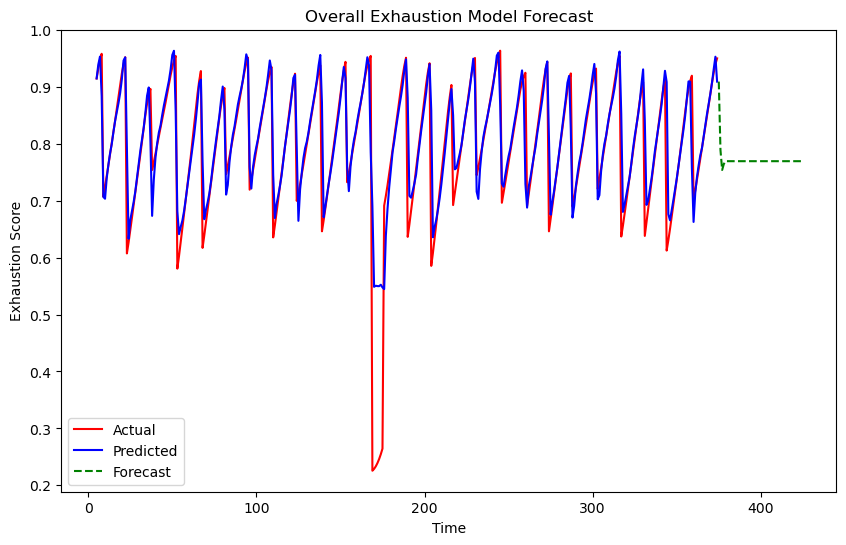

INFO: Created LSTM sequences: (370, 5, 11), (370,)


X_forecast shape: (375, 11), min: 8.951173136040325e-16, max: 90.7
X_forecast_scaled shape: (375, 11), min: -9.52469550278873, max: 4.892893554819774
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
predictions_prob shape: (370, 1), min: 0.02703256718814373, max: 0.9999830722808838
After clipping - min: 0.02703256718814373, max: 0.9999830722808838
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━

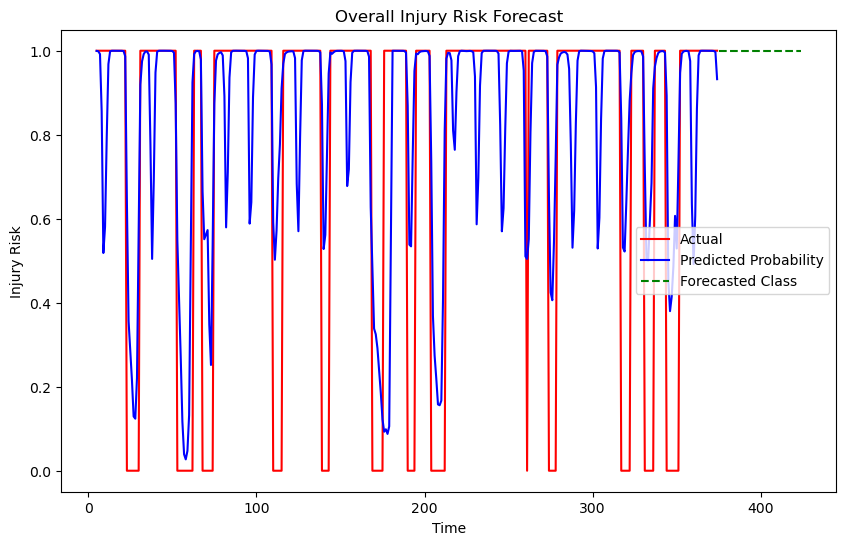

INFO: Created LSTM sequences: (370, 5, 3), (370,)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━

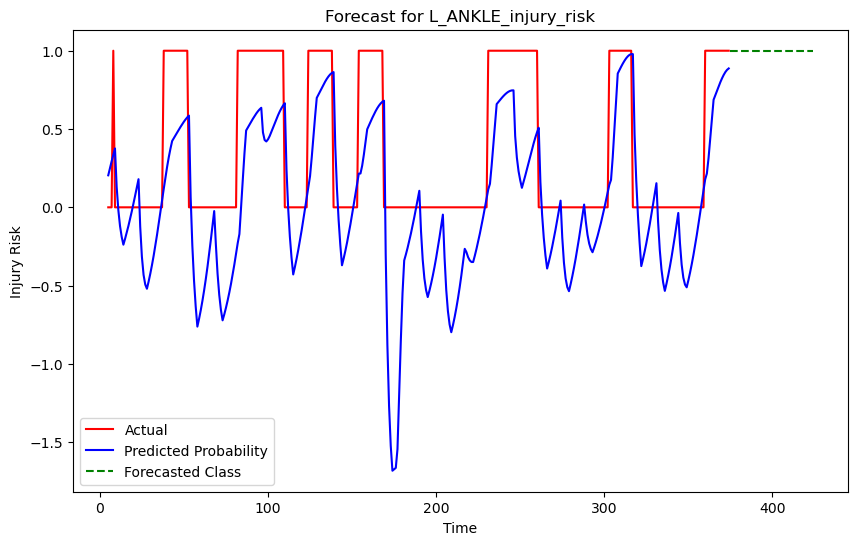

INFO: Created LSTM sequences: (370, 5, 1), (370,)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━

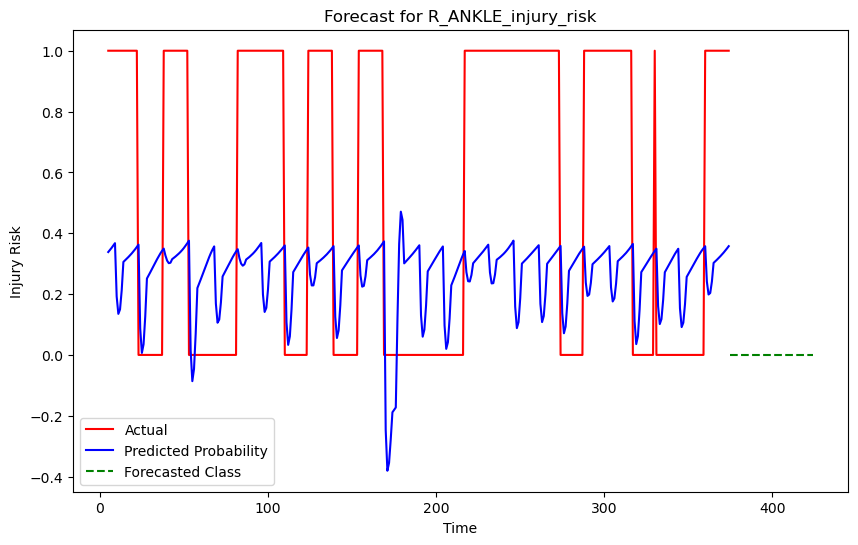

INFO: Created LSTM sequences: (370, 5, 2), (370,)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━

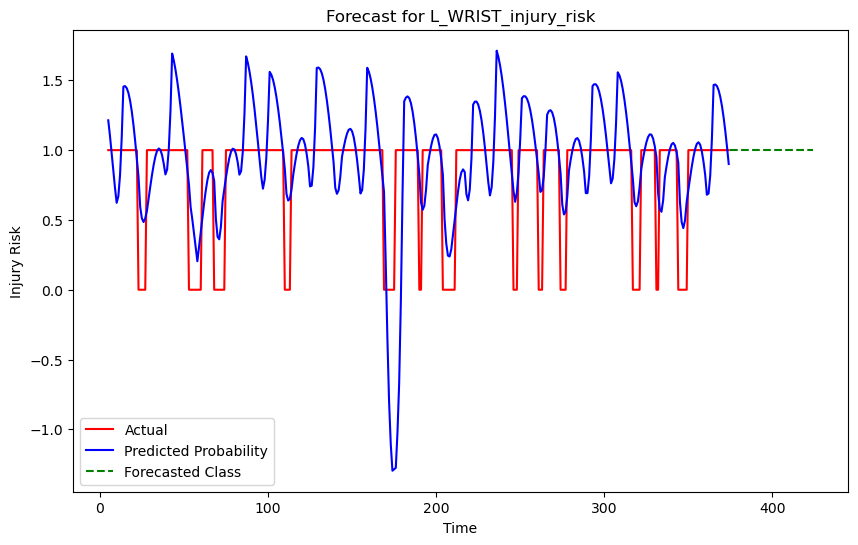

INFO: Created LSTM sequences: (370, 5, 2), (370,)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━

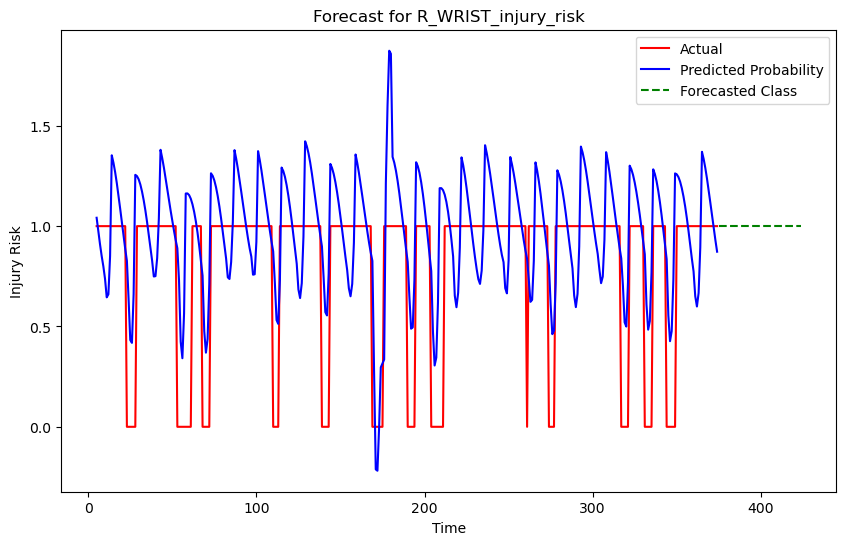

INFO: Created LSTM sequences: (370, 5, 1), (370,)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━

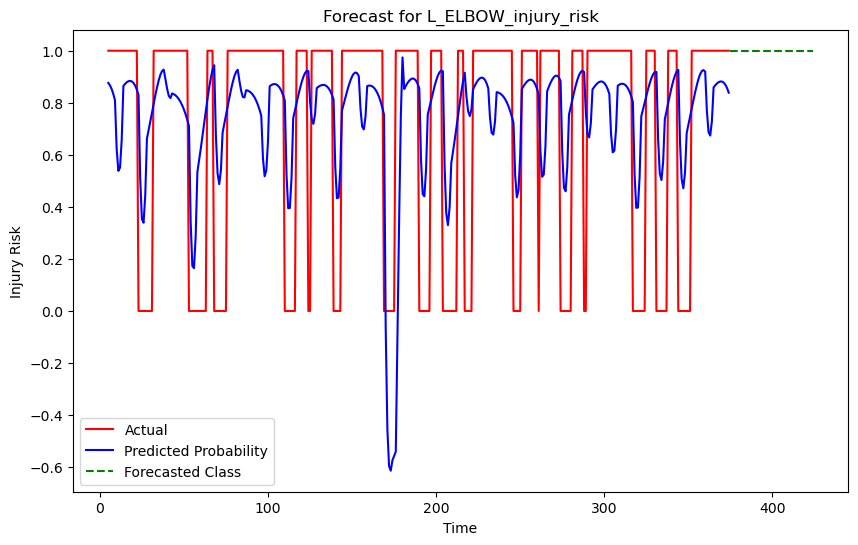

INFO: Created LSTM sequences: (370, 5, 1), (370,)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━

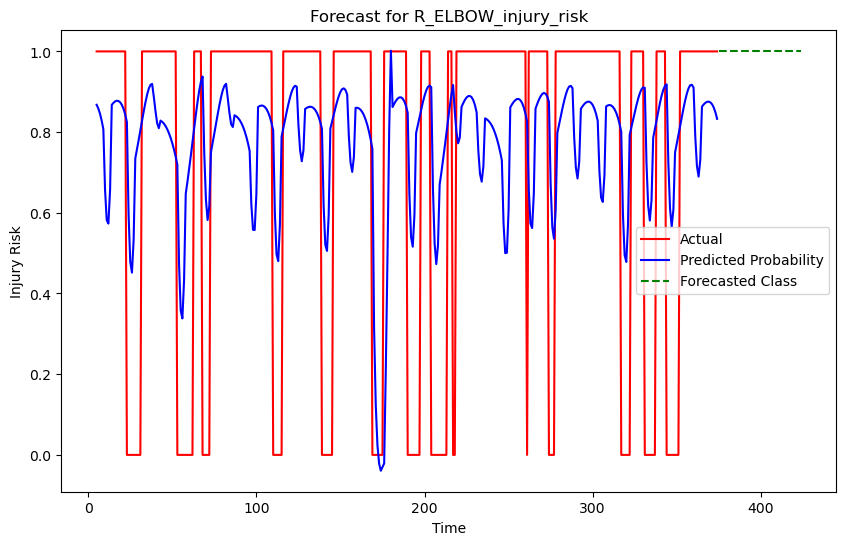

INFO: Created LSTM sequences: (370, 5, 1), (370,)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━

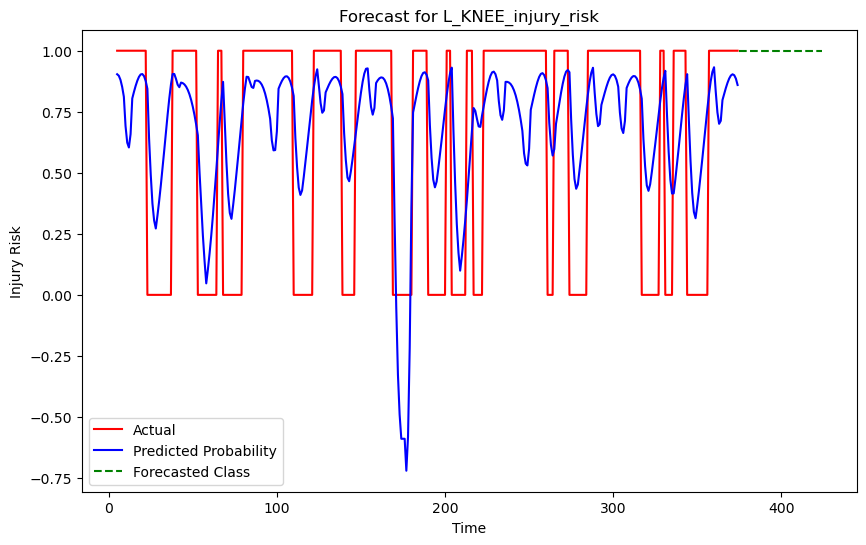

INFO: Created LSTM sequences: (370, 5, 1), (370,)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━

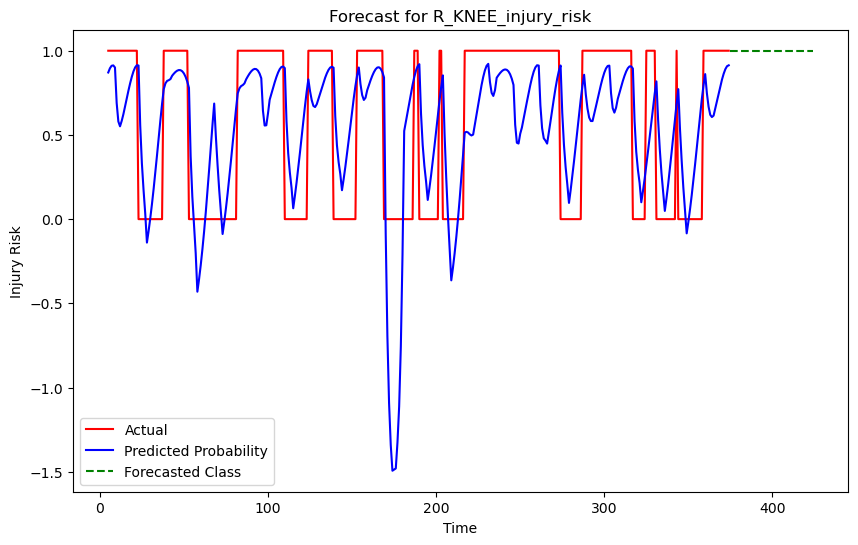

INFO: Created LSTM sequences: (370, 5, 1), (370,)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━

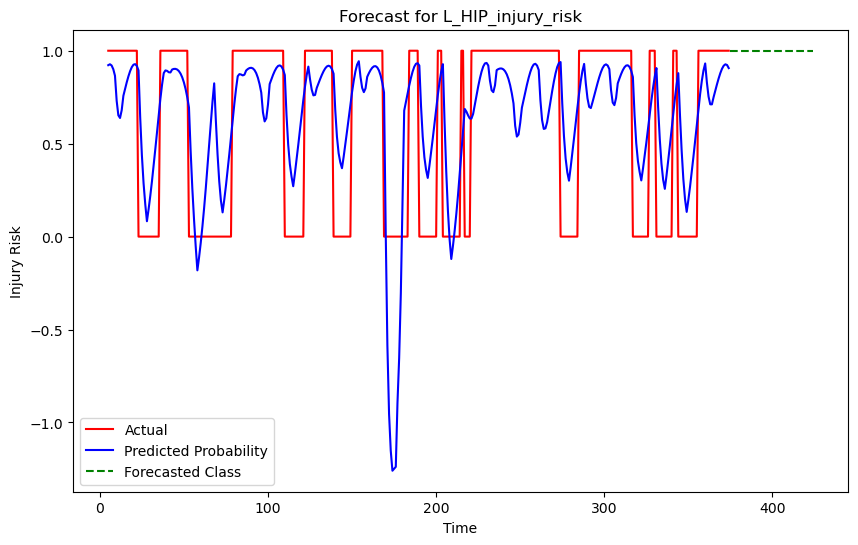

INFO: Created LSTM sequences: (370, 5, 1), (370,)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━

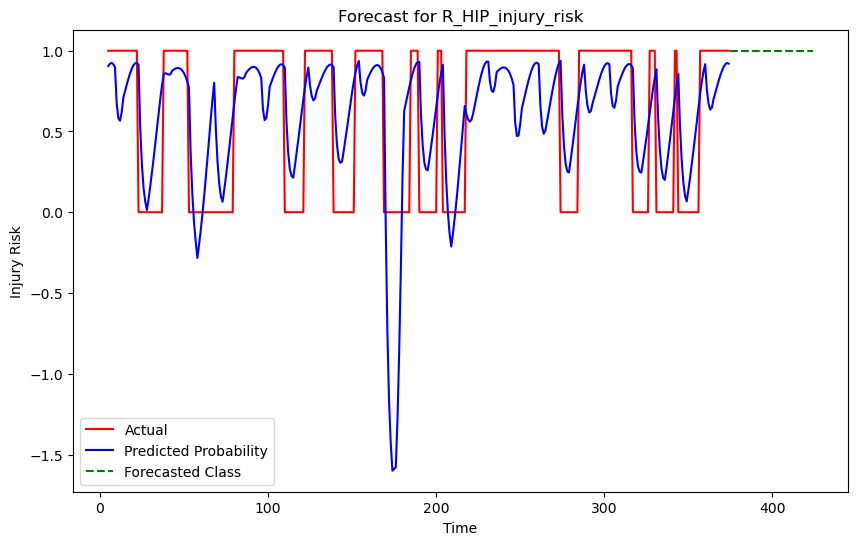

INFO: Created LSTM sequences: (370, 5, 1), (370,)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━

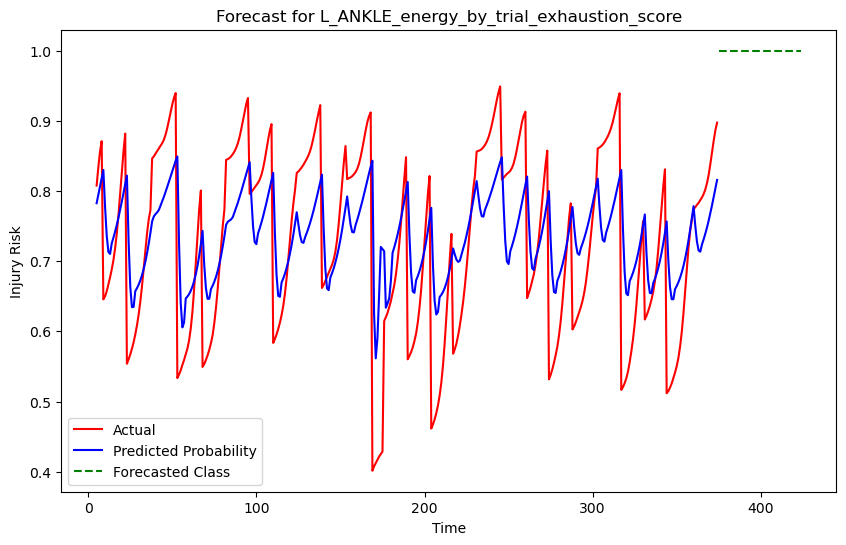

INFO: Created LSTM sequences: (370, 5, 1), (370,)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━

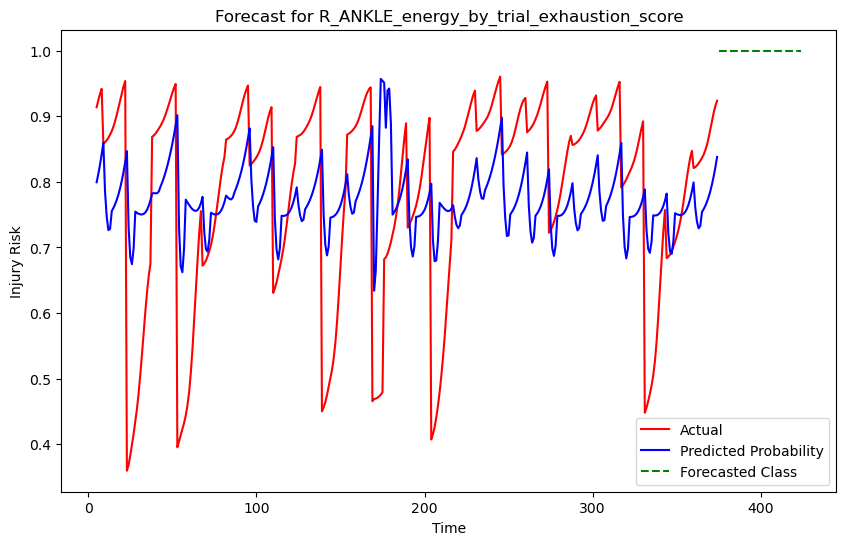

INFO: Created LSTM sequences: (370, 5, 1), (370,)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━

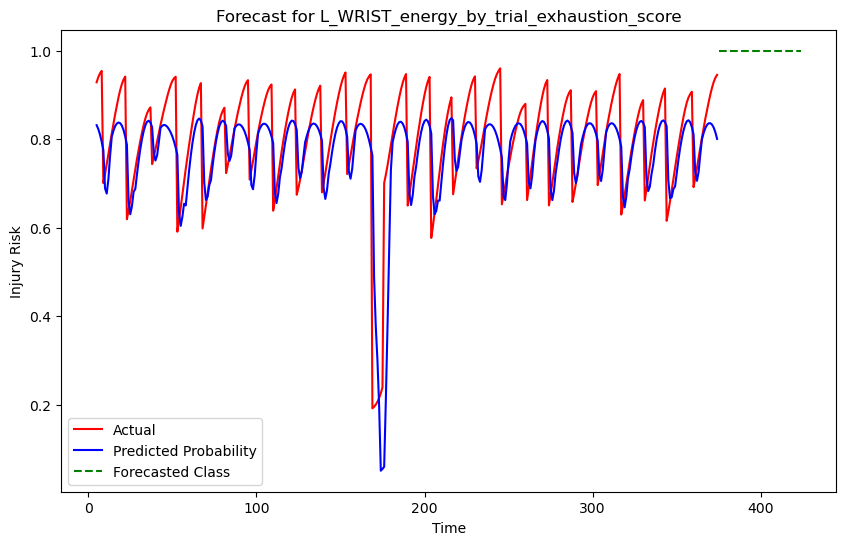

INFO: Created LSTM sequences: (370, 5, 1), (370,)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━

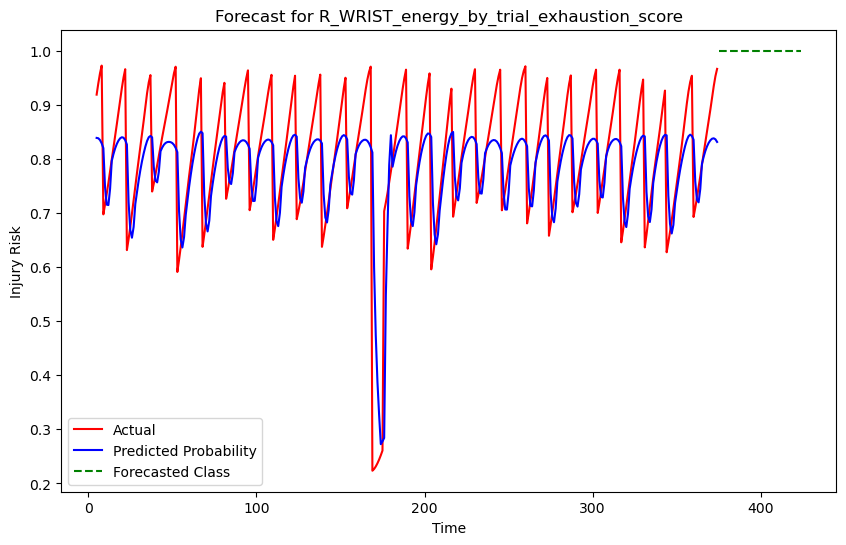

INFO: Created LSTM sequences: (370, 5, 1), (370,)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━

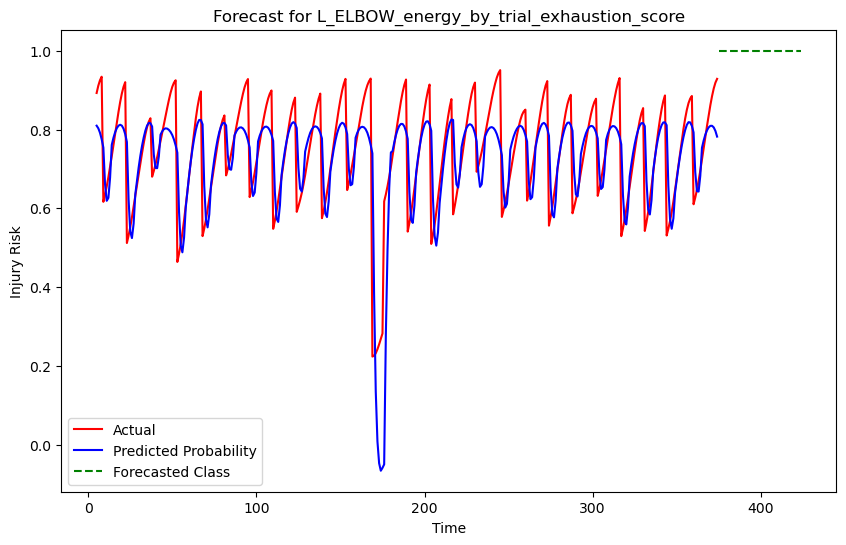

INFO: Created LSTM sequences: (370, 5, 1), (370,)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━

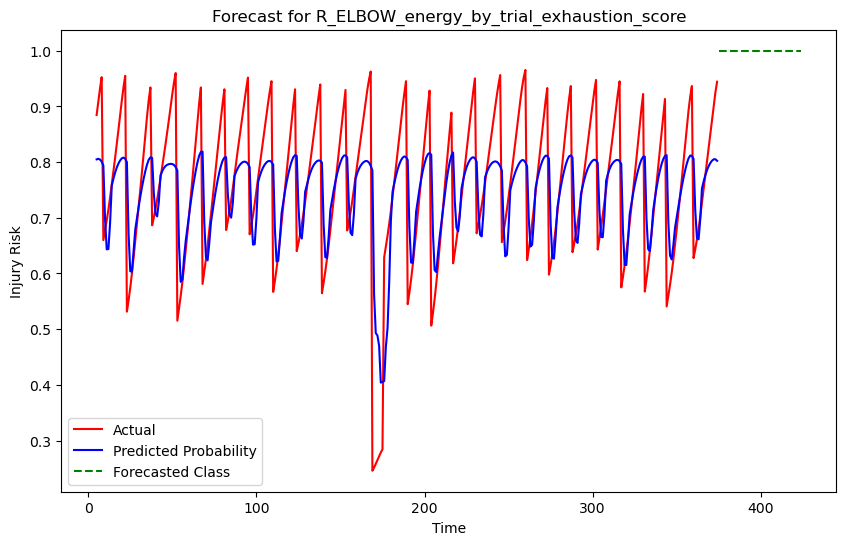

INFO: Created LSTM sequences: (370, 5, 1), (370,)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━

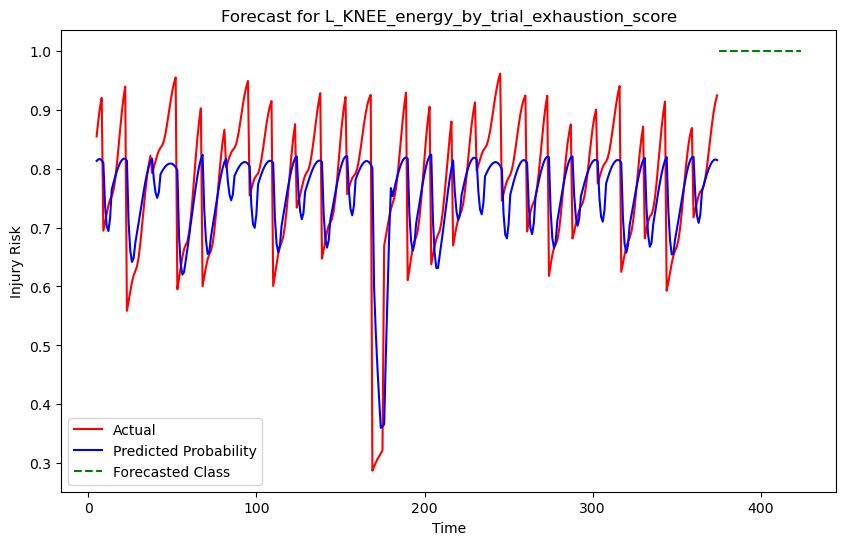

INFO: Created LSTM sequences: (370, 5, 1), (370,)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━

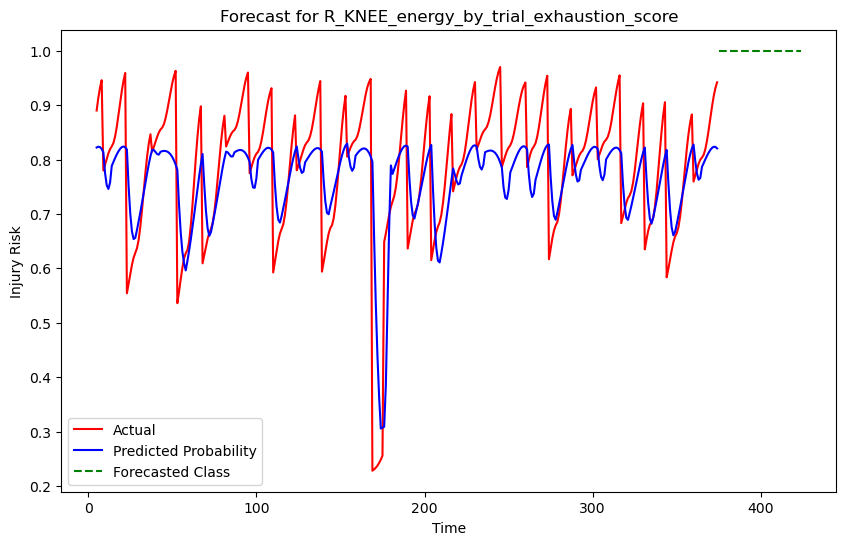

INFO: Created LSTM sequences: (370, 5, 1), (370,)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━

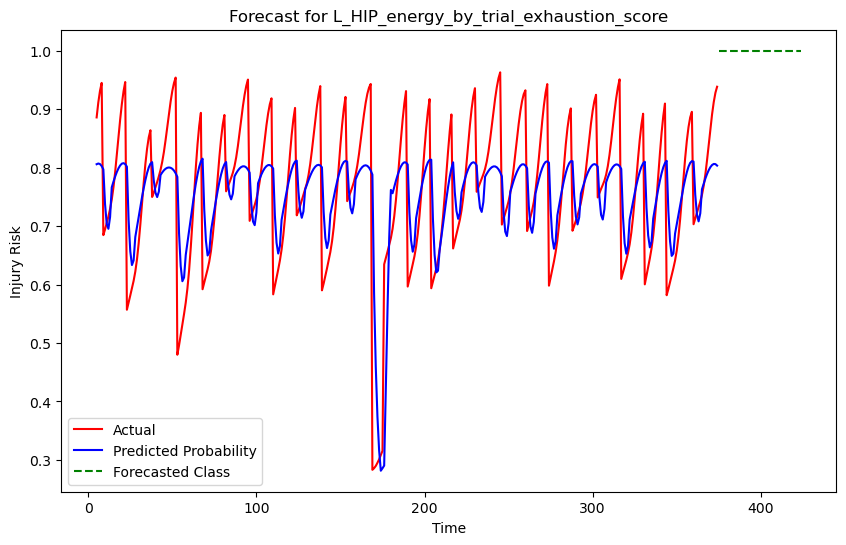

INFO: Created LSTM sequences: (370, 5, 1), (370,)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━

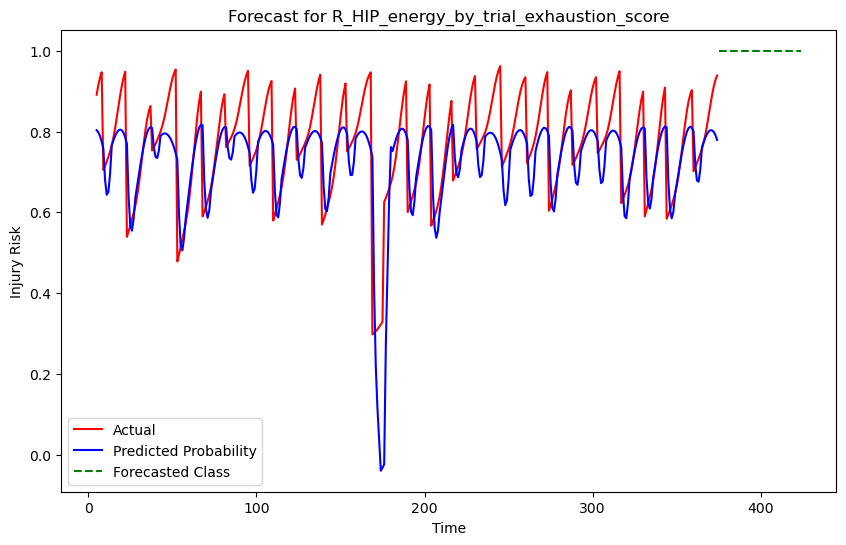

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


INFO: Created LSTM sequences: (370, 5, 3), (370,)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


INFO: Created LSTM sequences: (370, 5, 1), (370,)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


INFO: Created LSTM sequences: (370, 5, 2), (370,)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


INFO: Created LSTM sequences: (370, 5, 2), (370,)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


INFO: Created LSTM sequences: (370, 5, 1), (370,)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


INFO: Created LSTM sequences: (370, 5, 1), (370,)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


INFO: Created LSTM sequences: (370, 5, 1), (370,)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


INFO: Created LSTM sequences: (370, 5, 1), (370,)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


INFO: Created LSTM sequences: (370, 5, 1), (370,)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


INFO: Created LSTM sequences: (370, 5, 1), (370,)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


INFO: Created LSTM sequences: (370, 5, 1), (370,)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


INFO: Created LSTM sequences: (370, 5, 1), (370,)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


INFO: Created LSTM sequences: (370, 5, 1), (370,)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


INFO: Created LSTM sequences: (370, 5, 1), (370,)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


INFO: Created LSTM sequences: (370, 5, 1), (370,)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step


INFO: Created LSTM sequences: (370, 5, 1), (370,)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


INFO: Created LSTM sequences: (370, 5, 1), (370,)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


INFO: Created LSTM sequences: (370, 5, 1), (370,)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step


INFO: Created LSTM sequences: (370, 5, 1), (370,)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


INFO: Created LSTM sequences: (370, 5, 1), (370,)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


INFO: Saved summary to ../../data/Deep_Learning_Final/model_summary_final.csv
INFO: Performed temporal train-test split with test size = 0.2
INFO: Training data shape: (100, 140), Testing data shape: (25, 140)
INFO: Loaded feature list for 'by_trial_exhaustion_score': ['by_trial_exhaustion_score', 'rolling_hr_mean', 'L_HIP_energy', 'simulated_HR', 'R_HIP_energy', 'L_HIP_ongoing_power', 'R_HIP_ongoing_power', 'R_ELBOW_energy', 'exhaustion_rate_lag1', 'L_ELBOW_energy']
INFO: Loaded feature list for 'injury_risk': ['injury_risk']
INFO: Features provided for training exhaustion model: ['by_trial_exhaustion_score', 'rolling_hr_mean', 'L_HIP_energy', 'simulated_HR', 'R_HIP_energy', 'L_HIP_ongoing_power', 'R_HIP_ongoing_power', 'R_ELBOW_energy', 'exhaustion_rate_lag1', 'L_ELBOW_energy']
INFO: Available train_data columns: ['trial_id', 'joint_energy', 'L_ELBOW_energy', 'R_ELBOW_energy', 'L_WRIST_energy', 'R_WRIST_energy', 'L_KNEE_energy', 'R_KNEE_energy', 'L_HIP_energy', 'R_HIP_energy', 'joint

=== Model Summaries (Base Data) ===
                                       Model            Type       MSE  \
0                           Exhaustion Model      Regression  0.004074   
1                               Injury Model  Classification       NaN   
2                        L_ANKLE_injury_risk  Classification       NaN   
3                        R_ANKLE_injury_risk  Classification       NaN   
4                        L_WRIST_injury_risk  Classification       NaN   
5                        R_WRIST_injury_risk  Classification       NaN   
6                        L_ELBOW_injury_risk  Classification       NaN   
7                        R_ELBOW_injury_risk  Classification       NaN   
8                         L_KNEE_injury_risk  Classification       NaN   
9                         R_KNEE_injury_risk  Classification       NaN   
10                         L_HIP_injury_risk  Classification       NaN   
11                         R_HIP_injury_risk  Classification       NaN   
12

INFO: Features provided for training injury model: ['injury_risk']
INFO: Available train_data columns: ['trial_id', 'joint_energy', 'L_ELBOW_energy', 'R_ELBOW_energy', 'L_WRIST_energy', 'R_WRIST_energy', 'L_KNEE_energy', 'R_KNEE_energy', 'L_HIP_energy', 'R_HIP_energy', 'joint_power', 'L_ELBOW_ongoing_power', 'R_ELBOW_ongoing_power', 'L_WRIST_ongoing_power', 'R_WRIST_ongoing_power', 'L_KNEE_ongoing_power', 'R_KNEE_ongoing_power', 'L_HIP_ongoing_power', 'R_HIP_ongoing_power', 'elbow_asymmetry', 'wrist_asymmetry', 'knee_asymmetry', 'hip_asymmetry', 'L_ELBOW_angle', 'R_ELBOW_angle', 'L_WRIST_angle', 'R_WRIST_angle', 'L_KNEE_angle', 'R_KNEE_angle', 'L_SHOULDER_ROM', 'R_SHOULDER_ROM', 'L_WRIST_ROM', 'R_WRIST_ROM', 'L_KNEE_ROM', 'R_KNEE_ROM', 'L_HIP_ROM', 'R_HIP_ROM', 'exhaustion_rate', 'by_trial_exhaustion_score', 'injury_risk', 'energy_acceleration', 'power_avg_5', 'rolling_power_std', 'rolling_hr_mean', 'simulated_HR', 'player_height_in_meters', 'player_weight__in_kg', 'joint_energy_std', 

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.4566 - loss: 0.6903 - val_accuracy: 1.0000 - val_loss: 0.6791
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 1.0000 - loss: 0.6758 - val_accuracy: 1.0000 - val_loss: 0.6625
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 1.0000 - loss: 0.6587 - val_accuracy: 1.0000 - val_loss: 0.6426
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 1.0000 - loss: 0.6377 - val_accuracy: 1.0000 - val_loss: 0.6185
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 1.0000 - loss: 0.6124 - val_accuracy: 1.0000 - val_loss: 0.5892
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 1.0000 - loss: 0.5830 - val_accuracy: 1.0000 - val_loss: 0.5534
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 1.0000 - loss: 0.5443 - val_accuracy: 1.0000 - val_loss: 0.5096
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 1.0000 - loss: 0.4989 - val_accuracy: 1.0000 - val_loss: 0.4566


INFO: Created LSTM sequences: (20, 5, 10), (20,)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━

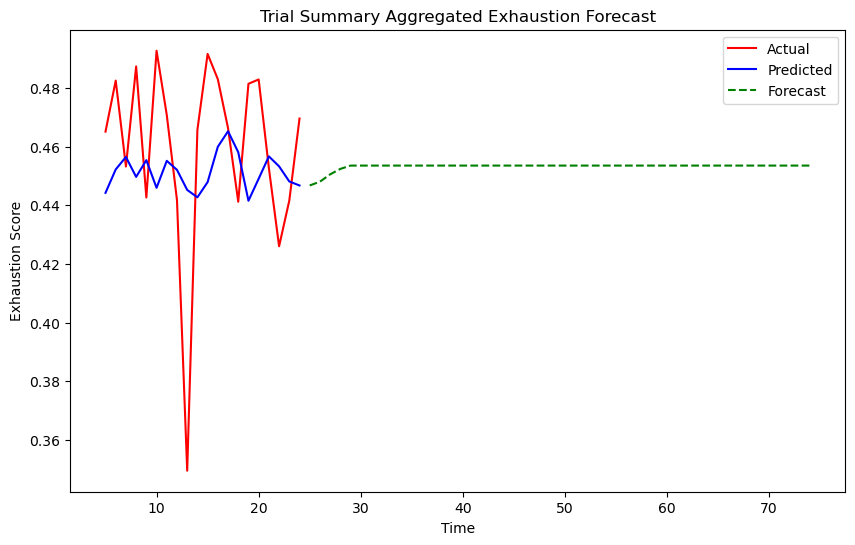

INFO: Created LSTM sequences: (20, 5, 1), (20,)


X_forecast shape: (25, 1), min: 1, max: 1
X_forecast_scaled shape: (25, 1), min: 0.0, max: 0.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
predictions_prob shape: (20, 1), min: 0.7256903052330017, max: 0.7256903052330017
After clipping - min: 0.7256903052330017, max: 0.7256903052330017
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/st

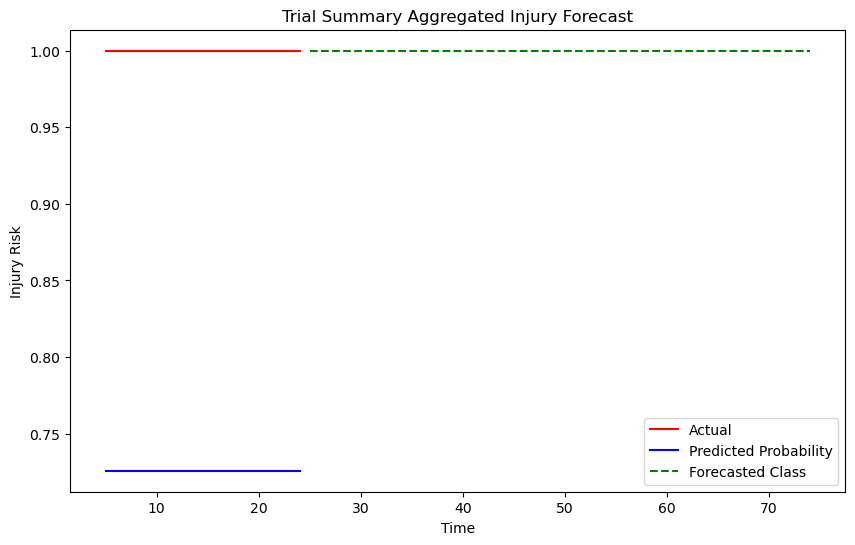

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
[DEBUG] Predictions stats: min=0.44154778122901917, max=0.46521902084350586, nan_count=0
[DEBUG] True values stats: min=0.34955048965475677, max=0.4926715974926009, nan_count=0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


INFO: Saved summary to ../../data/Deep_Learning_Final/model_summary_final.csv
INFO: Performed temporal train-test split with test size = 0.2
INFO: Training data shape: (400, 141), Testing data shape: (100, 141)
INFO: Loaded feature list for 'by_trial_exhaustion_score': ['by_trial_exhaustion_score', 'joint_energy_lag1', 'L_ELBOW_energy_lag1', 'rolling_power_std', 'L_ELBOW_ongoing_power', 'joint_energy', 'joint_power', 'L_WRIST_energy', 'L_WRIST_angle', 'R_KNEE_angle']
INFO: Loaded feature list for 'injury_risk': ['injury_risk']
INFO: Features provided for training exhaustion model: ['by_trial_exhaustion_score', 'joint_energy_lag1', 'L_ELBOW_energy_lag1', 'rolling_power_std', 'L_ELBOW_ongoing_power', 'joint_energy', 'joint_power', 'L_WRIST_energy', 'L_WRIST_angle', 'R_KNEE_angle']
INFO: Available train_data columns: ['trial_id', 'shooting_phases', 'joint_energy', 'L_ELBOW_energy', 'R_ELBOW_energy', 'L_WRIST_energy', 'R_WRIST_energy', 'L_KNEE_energy', 'R_KNEE_energy', 'L_HIP_energy', 'R_H

[DEBUG] Predicted probabilities stats: min=0.7256903052330017, max=0.7256903052330017, nan_count=0
=== Model Summaries (Trial Summary Aggregated Data) ===
              Model            Type       MSE       MAE  R2 Score  Accuracy  \
0  Exhaustion Model      Regression  0.001097  0.025746 -0.102166       NaN   
1      Injury Model  Classification       NaN       NaN       NaN       1.0   

   Precision  Recall  F1 Score  
0        NaN     NaN       NaN  
1        1.0     1.0       1.0  
Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.9215 - val_loss: 1.1641
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8138 - val_loss: 0.9952
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6343 - val_loss: 0.8671
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5010 - val_loss: 0.7631
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3992 - val_loss: 0.6763
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3228 - val_loss: 0.5660
Epo

INFO: Features provided for training injury model: ['injury_risk']
INFO: Available train_data columns: ['trial_id', 'shooting_phases', 'joint_energy', 'L_ELBOW_energy', 'R_ELBOW_energy', 'L_WRIST_energy', 'R_WRIST_energy', 'L_KNEE_energy', 'R_KNEE_energy', 'L_HIP_energy', 'R_HIP_energy', 'joint_power', 'L_ELBOW_ongoing_power', 'R_ELBOW_ongoing_power', 'L_WRIST_ongoing_power', 'R_WRIST_ongoing_power', 'L_KNEE_ongoing_power', 'R_KNEE_ongoing_power', 'L_HIP_ongoing_power', 'R_HIP_ongoing_power', 'elbow_asymmetry', 'wrist_asymmetry', 'knee_asymmetry', 'hip_asymmetry', 'L_ELBOW_angle', 'R_ELBOW_angle', 'L_WRIST_angle', 'R_WRIST_angle', 'L_KNEE_angle', 'R_KNEE_angle', 'L_SHOULDER_ROM', 'R_SHOULDER_ROM', 'L_WRIST_ROM', 'R_WRIST_ROM', 'L_KNEE_ROM', 'R_KNEE_ROM', 'L_HIP_ROM', 'R_HIP_ROM', 'exhaustion_rate', 'by_trial_exhaustion_score', 'injury_risk', 'energy_acceleration', 'power_avg_5', 'rolling_power_std', 'rolling_hr_mean', 'simulated_HR', 'player_height_in_meters', 'player_weight__in_kg', '

Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6026 - loss: 0.6831 - val_accuracy: 0.7368 - val_loss: 0.6624
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8621 - loss: 0.6163 - val_accuracy: 0.8000 - val_loss: 0.6142
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8731 - loss: 0.5172 - val_accuracy: 0.8000 - val_loss: 0.5462
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8931 - loss: 0.3679 - val_accuracy: 0.8000 - val_loss: 0.5677
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8680 - loss: 0.3741 - val_accuracy: 0.8000 - val_loss: 0.5452
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8808 - loss: 0.3455 - val_accuracy: 0.8000 - val_loss: 0.5202
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8705 - loss: 0.3607 - val_accuracy: 0.8000 - val_loss: 0.5165
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8789 - loss: 0.3385 - val_accuracy: 0.8000 - val_loss

INFO: Created LSTM sequences: (95, 5, 10), (95,)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━

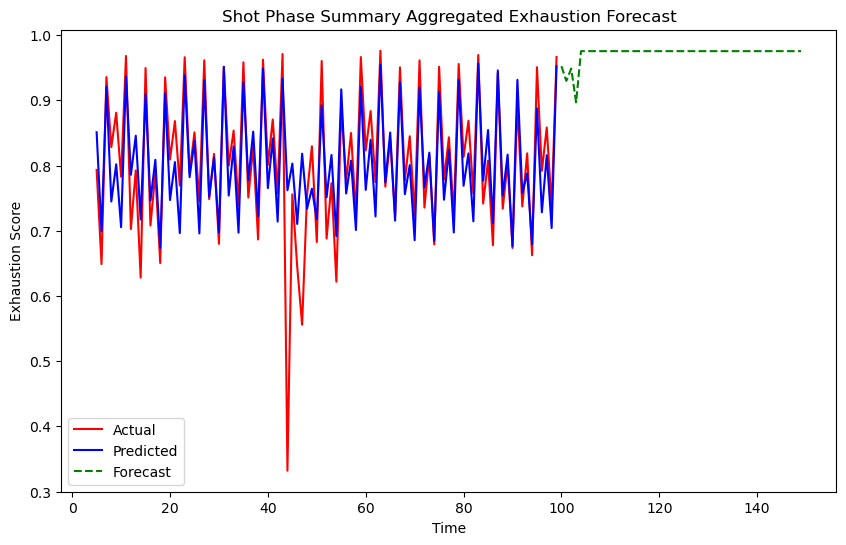

INFO: Created LSTM sequences: (95, 5, 1), (95,)


X_forecast shape: (100, 1), min: 0, max: 1
X_forecast_scaled shape: (100, 1), min: -2.808716591058786, max: 0.35603449745815613
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
predictions_prob shape: (95, 1), min: 0.7665688395500183, max: 0.9281001091003418
After clipping - min: 0.7665688395500183, max: 0.9281001091003418
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/

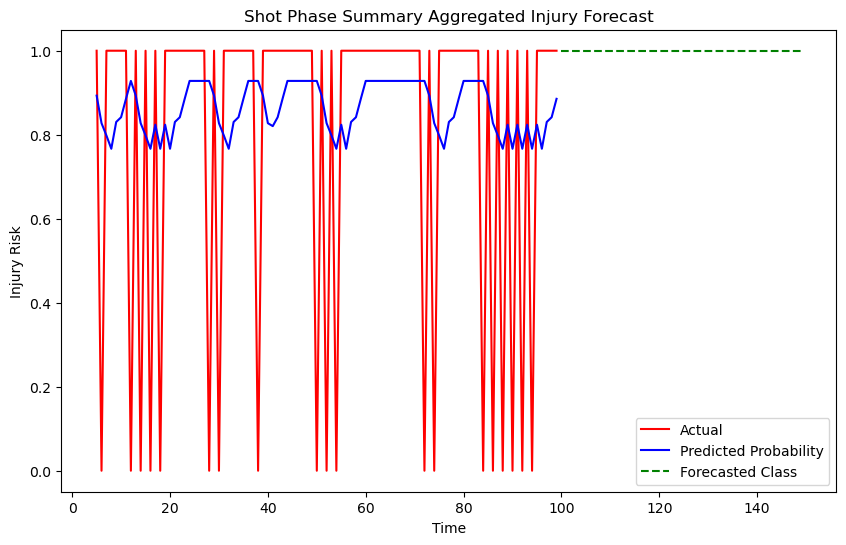

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
[DEBUG] Predictions stats: min=0.6738479733467102, max=0.9565932750701904, nan_count=0
[DEBUG] True values stats: min=0.33193255544629263, max=0.9761321942572885, nan_count=0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
[DEBUG] Predicted probabilities stats: min=0.7665688395500183, max=0.9281001091003418, nan_count=0


INFO: Saved summary to ../../data/Deep_Learning_Final/model_summary_final.csv
INFO: Created LSTM sequences: (370, 5, 3), (370,)


=== Model Summaries (Shot Phase Summary Aggregated Data) ===
              Model            Type       MSE       MAE  R2 Score  Accuracy  \
0  Exhaustion Model      Regression  0.004347  0.042204  0.656508       NaN   
1      Injury Model  Classification       NaN       NaN       NaN       0.8   

   Precision  Recall  F1 Score  
0        NaN     NaN       NaN  
1        0.8     1.0  0.888889  
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


INFO: Created LSTM sequences: (370, 5, 1), (370,)


[DEBUG] Predicted probabilities stats: min=-1.6820567846298218, max=0.9784148335456848, nan_count=0
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


INFO: Created LSTM sequences: (370, 5, 2), (370,)


[DEBUG] Predicted probabilities stats: min=-0.3806498348712921, max=0.4709113836288452, nan_count=0
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


INFO: Created LSTM sequences: (370, 5, 2), (370,)


[DEBUG] Predicted probabilities stats: min=-1.2964677810668945, max=1.7121121883392334, nan_count=0
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


INFO: Created LSTM sequences: (370, 5, 1), (370,)


[DEBUG] Predicted probabilities stats: min=-0.2188824862241745, max=1.8741801977157593, nan_count=0
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


INFO: Created LSTM sequences: (370, 5, 1), (370,)


[DEBUG] Predicted probabilities stats: min=-0.613743007183075, max=0.9743064641952515, nan_count=0
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


INFO: Created LSTM sequences: (370, 5, 1), (370,)


[DEBUG] Predicted probabilities stats: min=-0.03922327235341072, max=1.001686453819275, nan_count=0
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


INFO: Created LSTM sequences: (370, 5, 1), (370,)


[DEBUG] Predicted probabilities stats: min=-0.7202784419059753, max=0.9323871731758118, nan_count=0
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


INFO: Created LSTM sequences: (370, 5, 1), (370,)


[DEBUG] Predicted probabilities stats: min=-1.4937788248062134, max=0.9220046997070312, nan_count=0
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


INFO: Created LSTM sequences: (370, 5, 1), (370,)


[DEBUG] Predicted probabilities stats: min=-1.259505033493042, max=0.9435303807258606, nan_count=0
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


INFO: Created LSTM sequences: (370, 5, 1), (370,)


[DEBUG] Predicted probabilities stats: min=-1.6004217863082886, max=0.9372410178184509, nan_count=0
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


INFO: Created LSTM sequences: (370, 5, 1), (370,)


[DEBUG] Predictions stats: min=0.5615434050559998, max=0.849265992641449, nan_count=0
[DEBUG] True values stats: min=0.4013372650039539, max=0.9491221331401756, nan_count=0
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


INFO: Created LSTM sequences: (370, 5, 1), (370,)


[DEBUG] Predictions stats: min=0.6338970065116882, max=0.9570252895355225, nan_count=0
[DEBUG] True values stats: min=0.3594013777746643, max=0.960488776996504, nan_count=0
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


INFO: Created LSTM sequences: (370, 5, 1), (370,)


[DEBUG] Predictions stats: min=0.05118247866630554, max=0.8477599024772644, nan_count=0
[DEBUG] True values stats: min=0.1921711978744694, max=0.9602095325538852, nan_count=0
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


INFO: Created LSTM sequences: (370, 5, 1), (370,)


[DEBUG] Predictions stats: min=0.2726600766181946, max=0.8503348231315613, nan_count=0
[DEBUG] True values stats: min=0.223588582531271, max=0.9724624796971728, nan_count=0
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


INFO: Created LSTM sequences: (370, 5, 1), (370,)


[DEBUG] Predictions stats: min=-0.06596451997756958, max=0.8253674507141113, nan_count=0
[DEBUG] True values stats: min=0.223794566160889, max=0.9507798252833402, nan_count=0
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
[DEBUG] Predictions stats: min=0.40398916602134705, max=0.8188540935516357, nan_count=0
[DEBUG] True values stats: min=0.245744083217568, max=0.9654715558188964, nan_count=0


INFO: Created LSTM sequences: (370, 5, 1), (370,)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


INFO: Created LSTM sequences: (370, 5, 1), (370,)


[DEBUG] Predictions stats: min=0.3601216971874237, max=0.8236633539199829, nan_count=0
[DEBUG] True values stats: min=0.2874406875361924, max=0.9612356277204784, nan_count=0
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


INFO: Created LSTM sequences: (370, 5, 1), (370,)


[DEBUG] Predictions stats: min=0.3055048882961273, max=0.8292755484580994, nan_count=0
[DEBUG] True values stats: min=0.2279471092701698, max=0.9700971284890652, nan_count=0
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


INFO: Created LSTM sequences: (370, 5, 1), (370,)


[DEBUG] Predictions stats: min=0.2814452350139618, max=0.8153285980224609, nan_count=0
[DEBUG] True values stats: min=0.2829765571934284, max=0.9629945052000438, nan_count=0
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
[DEBUG] Predictions stats: min=-0.03959805518388748, max=0.8169514536857605, nan_count=0
[DEBUG] True values stats: min=0.297896479057592, max=0.9618370894476428, nan_count=0
=== Final Regression Summary ===
                                       Model        Type       MSE       MAE  \
0                           Exhaustion Model  Regression  0.004074  0.024826   
1   L_ANKLE_energy_by_trial_exhaustion_score  Regression  0.009858  0.079876   
2   R_ANKLE_energy_by_trial_exhaustion_score  Regression  0.021284  0.118744   
3   L_WRIST_energy_by_trial_exhaustion_score  Regression  0.008320  0.060780   
4   R_WRIST_energy_by_trial_exhaustion_score  Regression  0.007384  0.061492   
5   L_ELBOW_energy_by_trial_exhaustion_score  Regression  0.009433  0.061756   
6   R_ELBOW_energy

In [9]:
import numpy as np
import pandas as pd
import json
import sys
import logging
from pathlib import Path

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_absolute_error, r2_score, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns


# ==================== UTILS ====================
       
def temporal_train_test_split(data, test_size=0.2):
    """Time-based split maintaining temporal order"""
    split_idx = int(len(data) * (1 - test_size))
    train_data = data.iloc[:split_idx]
    test_data = data.iloc[split_idx:]
    logging.info(f"Performed temporal train-test split with test size = {test_size}")
    logging.info(f"Training data shape: {train_data.shape}, Testing data shape: {test_data.shape}")
    return train_data, test_data

def scale_features(X_train, X_test):
    """
    Scales features using StandardScaler.
    """
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    logging.info("Features have been scaled using StandardScaler.")
    return X_train_scaled, X_test_scaled, scaler

def create_sequences(X, y, timesteps):
    """
    Creates sequences of data for LSTM input.
    """
    X_seq, y_seq = [], []
    for i in range(timesteps, len(X)):
        X_seq.append(X[i-timesteps:i])
        y_seq.append(y[i])
    X_seq = np.array(X_seq)
    y_seq = np.array(y_seq)
    logging.info(f"Created LSTM sequences: {X_seq.shape}, {y_seq.shape}")
    return X_seq, y_seq
# ==================== TRAINING FUNCTIONS ====================

def train_exhaustion_model(train_data, test_data, features, timesteps, 
                           epochs=50, batch_size=32, early_stop_patience=5,
                           num_lstm_layers=1, lstm_units=64, dropout_rate=0.2,
                           dense_units=1, dense_activation=None, target_col="by_trial_exhaustion_score"):
    """
    Trains an exhaustion model (regression) with a separate target scaler.
    
    An optional parameter 'target_col' is added so that this function can be used
    for joint-specific exhaustion targets if needed. The default is "by_trial_exhaustion_score".
    
    Parameters:
      - train_data (DataFrame): Training set.
      - test_data (DataFrame): Testing set.
      - features (list): List of feature column names for exhaustion.
      - timesteps (int): Number of past observations to include in each sequence.
      - epochs (int): Number of training epochs.
      - batch_size (int): Batch size for training.
      - early_stop_patience (int): Patience for EarlyStopping callback.
      - num_lstm_layers (int): Number of LSTM layers in the model.
      - lstm_units (int): Number of units in each LSTM layer.
      - dropout_rate (float): Dropout rate applied after each LSTM layer.
      - dense_units (int): Number of units in the final Dense layer.
      - dense_activation (str or None): Activation function for the Dense layer.
      - target_col (str): The name of the target column to use. Default is "by_trial_exhaustion_score".
      
    Returns:
      - model_exhaustion: Trained Keras model.
      - scaler_exhaustion: Fitted scaler for the features.
      - target_scaler: Fitted scaler for the target values.
      - X_lstm_exhaustion_val, y_lstm_exhaustion_val: Validation sequences.
    """
    # --- Debug: Log the feature list and available columns ---
    logging.info(f"Features provided for training exhaustion model: {features}")
    logging.info(f"Available train_data columns: {train_data.columns.tolist()}")
    missing_features = [f for f in features if f not in train_data.columns]
    if missing_features:
        logging.error(f"Missing features in train_data for target {target_col}: {missing_features}")
        raise KeyError(f"{missing_features} not in train_data.columns")
    
    # Extract features and target from training and testing data using target_col
    X_train = train_data[features].values
    y_train = train_data[target_col].values
    X_test = test_data[features].values
    y_test = test_data[target_col].values

    # Scale features
    X_train_scaled, X_test_scaled, scaler_exhaustion = scale_features(X_train, X_test)
    
    # Scale target values separately
    from sklearn.preprocessing import StandardScaler
    target_scaler = StandardScaler()
    y_train_scaled = target_scaler.fit_transform(y_train.reshape(-1, 1))
    y_test_scaled = target_scaler.transform(y_test.reshape(-1, 1))
    
    # Create sequences for LSTM input
    X_lstm, y_lstm = create_sequences(X_train_scaled, y_train_scaled, timesteps)
    X_lstm_val, y_lstm_val = create_sequences(X_test_scaled, y_test_scaled, timesteps)

    # Build the LSTM model
    from tensorflow.keras import Input
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dropout, Dense

    model_exhaustion = Sequential()
    model_exhaustion.add(Input(shape=(X_lstm.shape[1], X_lstm.shape[2])))
    for i in range(num_lstm_layers):
        return_seq = True if i < num_lstm_layers - 1 else False
        model_exhaustion.add(LSTM(lstm_units, return_sequences=return_seq))
        model_exhaustion.add(Dropout(dropout_rate))
    model_exhaustion.add(Dense(dense_units, activation=dense_activation))
    
    model_exhaustion.compile(optimizer='adam', loss='mse')
    from tensorflow.keras.callbacks import EarlyStopping
    early_stop = EarlyStopping(monitor='val_loss', patience=early_stop_patience)
    
    logging.info("Training exhaustion model...")
    model_exhaustion.fit(
        X_lstm, y_lstm,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_lstm_val, y_lstm_val),
        callbacks=[early_stop]
    )
    
    return model_exhaustion, scaler_exhaustion, target_scaler, X_lstm_val, y_lstm_val


def train_injury_model(train_data, test_data, features, timesteps,
                       epochs=50, batch_size=32, early_stop_patience=5,
                       num_lstm_layers=1, lstm_units=64, dropout_rate=0.2,
                       dense_units=1, dense_activation='sigmoid', target_col="injury_risk"):
    """
    Trains an injury risk model (classification). An optional parameter 'target_col'
    is added so that this function can be used for joint-specific injury targets.
    The default is "injury_risk".
    
    Parameters:
      - train_data (DataFrame): Training set.
      - test_data (DataFrame): Testing set.
      - features (list): List of feature column names for injury risk.
      - timesteps (int): Number of past observations to include in each sequence.
      - epochs (int): Number of training epochs.
      - batch_size (int): Batch size for training.
      - num_lstm_layers (int): Number of LSTM layers in the model.
      - lstm_units (int): Number of units in each LSTM layer.
      - dropout_rate (float): Dropout rate applied after each LSTM layer.
      - dense_units (int): Number of units in the final Dense layer.
      - dense_activation (str): Activation function for the Dense layer.
      - target_col (str): The target column to use. Default is "injury_risk".
      
    Returns:
      - model_injury: Trained Keras model.
      - scaler_injury: Fitted scaler for the features.
      - X_lstm_injury_val, y_lstm_injury_val: Validation sequences.
    """
    # --- Debug: Log the feature list and available columns ---
    logging.info(f"Features provided for training injury model: {features}")
    logging.info(f"Available train_data columns: {train_data.columns.tolist()}")
    missing_features = [f for f in features if f not in train_data.columns]
    if missing_features:
        logging.error(f"Missing features in train_data for target {target_col}: {missing_features}")
        raise KeyError(f"{missing_features} not in train_data.columns")
    
    # Extract features and target using target_col
    X_train = train_data[features].values
    y_train = train_data[target_col].values
    X_test = test_data[features].values
    y_test = test_data[target_col].values

    # Scale features
    X_train_scaled, X_test_scaled, scaler_injury = scale_features(X_train, X_test)
    # Create LSTM sequences
    X_lstm, y_lstm = create_sequences(X_train_scaled, y_train, timesteps)
    X_lstm_val, y_lstm_val = create_sequences(X_test_scaled, y_test, timesteps)

    # Build the injury risk model
    from tensorflow.keras import Input
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dropout, Dense

    model_injury = Sequential()
    model_injury.add(Input(shape=(X_lstm.shape[1], X_lstm.shape[2])))
    for i in range(num_lstm_layers):
        return_seq = True if i < num_lstm_layers - 1 else False
        model_injury.add(LSTM(lstm_units, return_sequences=return_seq))
        model_injury.add(Dropout(dropout_rate))
    model_injury.add(Dense(dense_units, activation=dense_activation))
    
    model_injury.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    logging.info("Training injury risk model...")
    from tensorflow.keras.callbacks import EarlyStopping
    early_stop = EarlyStopping(monitor='val_loss', patience=early_stop_patience)
    # Include early_stop in model.fit():
    model_injury.fit(
        X_lstm, y_lstm,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_lstm_val, y_lstm_val),
        callbacks=[early_stop]
    )
    
    return model_injury, scaler_injury, X_lstm_val, y_lstm_val



# ==================== JOINT-SPECIFIC TRAINING FUNCTION ====================



def train_joint_models(train_data, test_data, joints, timesteps, feature_dir,
                       epochs=50, batch_size=32,
                       num_lstm_layers=1, lstm_units=64, dropout_rate=0.2,
                       dense_units=1, dense_activation='sigmoid',
                       joint_feature_dict=None):
    """
    Trains injury risk models for multiple joints.
    
    Parameters:
      - train_data (DataFrame): Training set.
      - test_data (DataFrame): Testing set.
      - joints (list): List of joint names.
      - timesteps (int): Number of past observations to include in each sequence.
      - feature_dir (str): Directory containing feature lists.
      - epochs (int): Number of training epochs.
      - batch_size (int): Batch size for training.
      - num_lstm_layers (int): Number of LSTM layers in the model.
      - lstm_units (int): Number of units in each LSTM layer.
      - dropout_rate (float): Dropout rate applied after each LSTM layer.
      - dense_units (int): Number of units in the final Dense layer.
      - dense_activation (str): Activation function for the Dense layer.
      - joint_feature_dict (dict or None): (Optional) Dictionary mapping each joint target (e.g., 
            "L_ANKLE_injury_risk") to a preloaded feature list. If None, the function calls
            load_top_features for each target.
      
    Returns:
      - joint_models (dict): Dictionary with joint model information.
    """
    import logging
    from tensorflow.keras import Input
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dropout, Dense
    joint_models = {}

    for joint in joints:
        for side in ['L', 'R']:
            target_joint = f"{side}_{joint}_injury_risk"
            logging.info(f"Training model for {target_joint}...")

            # If a joint_feature_dict is provided and has the target, use it;
            # otherwise, call load_top_features from the specified directory.
            if joint_feature_dict is not None and target_joint in joint_feature_dict:
                joint_features = joint_feature_dict[target_joint]
                logging.info(f"Using preloaded feature list for {target_joint}: {joint_features}")
            else:
                joint_features = load_top_features(target_joint, feature_dir=feature_dir)
            
            # Extract joint-specific features and target values.
            X_train_joint = train_data[joint_features].values
            y_train_joint = train_data[target_joint].values
            X_test_joint = test_data[joint_features].values
            y_test_joint = test_data[target_joint].values

            # Scale features for the joint-specific model.
            X_train_scaled, X_test_scaled, scaler_joint = scale_features(X_train_joint, X_test_joint)
            # Create sequences for LSTM input.
            X_lstm, y_lstm = create_sequences(X_train_scaled, y_train_joint, timesteps)
            X_lstm_val, y_lstm_val = create_sequences(X_test_scaled, y_test_joint, timesteps)

            # Build the joint model.
            model_joint = Sequential()
            model_joint.add(Input(shape=(X_lstm.shape[1], X_lstm.shape[2])))
            for i in range(num_lstm_layers):
                return_seq = True if i < num_lstm_layers - 1 else False
                model_joint.add(LSTM(lstm_units, return_sequences=return_seq))
                model_joint.add(Dropout(dropout_rate))
            model_joint.add(Dense(dense_units, activation=dense_activation))

            model_joint.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

            model_joint.fit(
                X_lstm, y_lstm,
                epochs=epochs, 
                batch_size=batch_size,
                validation_data=(X_lstm_val, y_lstm_val)
            )

            joint_models[target_joint] = {
                'model': model_joint,
                'features': joint_features,
                'scaler': scaler_joint
            }

    # Save the loaded feature lists for all joint models.
    import json
    with open("loaded_features.json", "w") as f:
        json.dump({target: info['features'] for target, info in joint_models.items()}, f, indent=4)
    logging.info("Saved loaded features list for each joint model to 'loaded_features.json'.")

    return joint_models




# ==================== FORECASTING FUNCTION ====================

def forecast_and_plot_exhaustion(model, test_data, forecast_features, scaler_exhaustion, target_scaler, timesteps, future_steps=0, title="Exhaustion Forecast"):
    """
    Generates predictions for the exhaustion target using multi-feature input.
    
    This function extracts the same features used during training (e.g. a 10-dimensional input),
    scales them with the features scaler (scaler_exhaustion), builds forecasting sequences, makes predictions,
    and finally inverse-transforms the predictions using the target scaler.
    
    Parameters:
      - model: Trained exhaustion Keras model.
      - test_data (DataFrame): The test DataFrame containing all features.
      - forecast_features (list): List of feature names used for forecasting (e.g. features_exhaustion).
      - scaler_exhaustion: Fitted StandardScaler used to scale the features.
      - target_scaler: Fitted StandardScaler used to scale the target values.
      - timesteps (int): Number of past observations to include in each sequence.
      - future_steps (int): Number of future time steps to forecast.
                          (Note: Future forecasting is approximate since it assumes constant features.)
      - title (str): Plot title.
    """
    import numpy as np
    import matplotlib.pyplot as plt

    # Extract multi-dimensional input from test data
    X_forecast = test_data[forecast_features].values  # shape (n, num_features)
    
    # Scale the features using the features scaler
    X_forecast_scaled = scaler_exhaustion.transform(X_forecast)
    
    # Create sequences for forecasting using a dummy y array (since only X is needed)
    X_seq, _ = create_sequences(X_forecast_scaled, np.zeros(len(X_forecast_scaled)), timesteps)
    
    # Make predictions on the scaled sequences
    predictions_scaled = model.predict(X_seq)
    # Inverse-transform predictions using the target scaler
    predictions = target_scaler.inverse_transform(predictions_scaled)
    
    forecast_predictions_inv = None
    if future_steps > 0:
        # For additional future steps, we assume the features remain constant.
        # WARNING: This is an approximation.
        current_sequence = X_seq[-1].copy()  # shape: (timesteps, num_features)
        forecast_predictions = []
        for _ in range(future_steps):
            next_pred = model.predict(current_sequence.reshape(1, timesteps, current_sequence.shape[1]))
            forecast_predictions.append(next_pred[0, 0])
            # Update sequence: drop the first row and append the last row (assumed constant)
            new_row = current_sequence[-1, :].copy()
            current_sequence = np.vstack([current_sequence[1:], new_row])
        forecast_predictions = np.array(forecast_predictions).reshape(-1, 1)
        forecast_predictions_inv = target_scaler.inverse_transform(forecast_predictions)
    
    # Plot actual exhaustion scores versus predictions
    plt.figure(figsize=(10, 6))
    actual = test_data['by_trial_exhaustion_score'].values
    plt.plot(range(timesteps, len(actual)), actual[timesteps:], color='red', label='Actual')
    plt.plot(range(timesteps, len(actual)), predictions, color='blue', label='Predicted')
    if forecast_predictions_inv is not None:
        future_x = list(range(len(actual), len(actual) + future_steps))
        plt.plot(future_x, forecast_predictions_inv, color='green', linestyle='--', label='Forecast')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Exhaustion Score')
    plt.legend()
    plt.show()


def forecast_and_plot_injury(model, test_data, forecast_features, scaler_injury, timesteps, future_steps=0, title="Injury Risk Forecast"):
    """
    Generates predictions for the injury risk model using multi-feature input.
    
    This function extracts the injury features from the test data, scales them using scaler_injury,
    builds forecasting sequences, and makes predictions. Since this is a classification model,
    it outputs probability predictions. These probabilities (or rounded binary classes) are compared
    to the actual injury risk (assumed to be 0 or 1).
    
    Parameters:
      - model: Trained injury risk Keras model.
      - test_data (DataFrame): The test DataFrame containing all features.
      - forecast_features (list): List of feature names used for forecasting (e.g. features_injury).
      - scaler_injury: Fitted StandardScaler used to scale the injury features.
      - timesteps (int): Number of past observations to include in each sequence.
      - future_steps (int): Number of future time steps to forecast.
                          (For classification, future forecasting is less common.)
      - title (str): Plot title.
    """
    import numpy as np
    import matplotlib.pyplot as plt

    # Extract multi-dimensional input for injury risk from test data
    X_forecast = test_data[forecast_features].values  # shape (n, num_features)
    print(f"X_forecast shape: {X_forecast.shape}, min: {X_forecast.min()}, max: {X_forecast.max()}")
        
    # Scale the features using the injury features scaler
    X_forecast_scaled = scaler_injury.transform(X_forecast)
    print(f"X_forecast_scaled shape: {X_forecast_scaled.shape}, min: {X_forecast_scaled.min()}, max: {X_forecast_scaled.max()}")
    
    # Create sequences for forecasting (dummy y used, since only X is needed)
    X_seq, _ = create_sequences(X_forecast_scaled, np.zeros(len(X_forecast_scaled)), timesteps)
    
    # Predict probabilities on the sequences
    predictions_prob = model.predict(X_seq)
    print(f"predictions_prob shape: {predictions_prob.shape}, min: {predictions_prob.min()}, max: {predictions_prob.max()}")
    
    # Add clipping to ensure valid probability range
    predictions_prob_clipped = np.clip(predictions_prob, 0, 1)
    print(f"After clipping - min: {predictions_prob_clipped.min()}, max: {predictions_prob_clipped.max()}")
    
    # Convert probabilities to binary predictions (threshold=0.5)
    predictions_class = (predictions_prob >= 0.5).astype(int)
    
    forecast_predictions = None
    if future_steps > 0:
        # For future steps, we assume features remain constant (approximation)
        current_sequence = X_seq[-1].copy()  # shape: (timesteps, num_features)
        forecast_predictions = []
        for _ in range(future_steps):
            next_pred = model.predict(current_sequence.reshape(1, timesteps, current_sequence.shape[1]))
            forecast_predictions.append((next_pred[0, 0] >= 0.5).astype(int))
            new_row = current_sequence[-1, :].copy()
            current_sequence = np.vstack([current_sequence[1:], new_row])
        forecast_predictions = np.array(forecast_predictions)
    
    # Plot the actual injury risk versus predicted probability (or binary prediction)
    plt.figure(figsize=(10, 6))
    actual = test_data['injury_risk'].values
    # For plotting, we align the sequences starting at index 'timesteps'
    plt.plot(range(timesteps, len(actual)), actual[timesteps:], color='red', label='Actual')
    plt.plot(range(timesteps, len(actual)), predictions_prob, color='blue', label='Predicted Probability')
    if forecast_predictions is not None:
        future_x = list(range(len(actual), len(actual) + future_steps))
        plt.plot(future_x, forecast_predictions, color='green', linestyle='--', label='Forecasted Class')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Injury Risk')
    plt.legend()
    plt.show()


def forecast_and_plot_joint(joint_models, test_data, timesteps, future_steps=0):
    """
    Generates forecasts for each joint model using their corresponding features and scalers.
    
    For each joint model in the joint_models dictionary (returned by train_joint_models),
    this function extracts the joint-specific features from test_data, scales them using the model's scaler,
    builds sequences, obtains predictions (probabilities), converts them to binary predictions,
    and then plots the actual joint injury risk versus predicted values.
    
    Parameters:
      - joint_models (dict): Dictionary where each key is a joint target name and each value is a dict 
                             containing 'model', 'features', and 'scaler'.
      - test_data (DataFrame): The test DataFrame containing all features.
      - timesteps (int): Number of past observations to include in each sequence.
      - future_steps (int): Number of future time steps to forecast (optional).
    """
    import numpy as np
    import matplotlib.pyplot as plt

    for target_joint, info in joint_models.items():
        model_joint = info['model']
        joint_features = info['features']
        scaler_joint = info['scaler']
        
        # Extract joint-specific features from test data
        X_forecast = test_data[joint_features].values  # shape (n, num_features)
        # Scale the features
        X_forecast_scaled = scaler_joint.transform(X_forecast)
        # Create sequences for forecasting (dummy y used)
        X_seq, _ = create_sequences(X_forecast_scaled, np.zeros(len(X_forecast_scaled)), timesteps)
        
        # Predict probabilities and convert to binary predictions
        predictions_prob = model_joint.predict(X_seq)
        predictions_class = (predictions_prob >= 0.5).astype(int)
        
        forecast_predictions = None
        if future_steps > 0:
            # Approximate forecasting by assuming constant features
            current_sequence = X_seq[-1].copy()  # shape: (timesteps, num_features)
            forecast_predictions = []
            for _ in range(future_steps):
                next_pred = model_joint.predict(current_sequence.reshape(1, timesteps, current_sequence.shape[1]))
                forecast_predictions.append((next_pred[0, 0] >= 0.5).astype(int))
                new_row = current_sequence[-1, :].copy()
                current_sequence = np.vstack([current_sequence[1:], new_row])
            forecast_predictions = np.array(forecast_predictions)
        
        # Plot for this joint model
        plt.figure(figsize=(10, 6))
        actual = test_data[target_joint].values
        plt.plot(range(timesteps, len(actual)), actual[timesteps:], color='red', label='Actual')
        plt.plot(range(timesteps, len(actual)), predictions_prob, color='blue', label='Predicted Probability')
        if forecast_predictions is not None:
            future_x = list(range(len(actual), len(actual) + future_steps))
            plt.plot(future_x, forecast_predictions, color='green', linestyle='--', label='Forecasted Class')
        plt.title(f"Forecast for {target_joint}")
        plt.xlabel('Time')
        plt.ylabel('Injury Risk')
        plt.legend()
        plt.show()


from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, precision_score, recall_score, f1_score


def summarize_regression_model(model, X_val, y_val, target_scaler=None, debug=False):
    """
    Evaluates regression model performance.
    
    Parameters:
      - model: Trained regression Keras model.
      - X_val: Validation feature sequences.
      - y_val: Validation target values (scaled).
      - target_scaler: Optional StandardScaler used to inverse-transform targets.
      - debug (bool): If True, prints detailed debug information.
      
    Returns:
      - A dictionary containing Mean Squared Error (MSE), Mean Absolute Error (MAE), and R2 Score.
    """
    preds_scaled = model.predict(X_val)
    
    if target_scaler:
        preds = target_scaler.inverse_transform(preds_scaled)
        y_true = target_scaler.inverse_transform(y_val)
    else:
        preds = preds_scaled
        y_true = y_val

    if debug:
        print(f"[DEBUG] Predictions stats: min={preds.min()}, max={preds.max()}, nan_count={np.isnan(preds).sum()}")
        print(f"[DEBUG] True values stats: min={y_true.min()}, max={y_true.max()}, nan_count={np.isnan(y_true).sum()}")

    mse = mean_squared_error(y_true, preds)
    mae = mean_absolute_error(y_true, preds)
    r2 = r2_score(y_true, preds)

    return {
        "MSE": mse,
        "MAE": mae,
        "R2 Score": r2
    }


def summarize_classification_model(model, X_val, y_val, debug=False):
    """
    Evaluates classification model performance.
    
    Parameters:
      - model: Trained classification Keras model.
      - X_val: Validation feature sequences.
      - y_val: True binary labels.
      - debug (bool): If True, prints detailed debug information.
      
    Returns:
      - A dictionary containing Accuracy, Precision, Recall, and F1 Score.
    """
    preds_prob = model.predict(X_val)
    preds_class = (preds_prob >= 0.5).astype(int)
    
    if debug:
        print(f"[DEBUG] Predicted probabilities stats: min={preds_prob.min()}, max={preds_prob.max()}, nan_count={np.isnan(preds_prob).sum()}")

    accuracy = accuracy_score(y_val, preds_class)
    precision = precision_score(y_val, preds_class, zero_division=0)
    recall = recall_score(y_val, preds_class, zero_division=0)
    f1 = f1_score(y_val, preds_class, zero_division=0)

    return {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1
    }

def summarize_joint_models(joint_models, test_data, timesteps, debug=False):
    """
    Summarizes evaluation metrics for each joint model (classification or regression).
    
    For every joint model, the function:
      - Extracts joint-specific features from test_data.
      - Scales the features.
      - Creates sequences for LSTM input.
      - Computes classification or regression metrics using the appropriate function.
    
    Parameters:
      - joint_models (dict): Dictionary with joint model info ('model', 'features', 'scaler').
      - test_data (DataFrame): Test dataset containing joint-specific features.
      - timesteps (int): Number of past observations per sequence.
      - debug (bool): If True, enables debugging outputs.
      
    Returns:
      - Dictionary mapping each joint target to its evaluation metrics.
    """
    summaries = {}
    for target_joint, info in joint_models.items():
        model_joint = info['model']
        joint_features = info['features']
        scaler_joint = info['scaler']
        
        validate_features(joint_features, test_data, context=f"summarize_joint_models for {target_joint}")
        
        X_joint = test_data[joint_features].values
        y_joint = test_data[target_joint].values

        X_joint_scaled = scaler_joint.transform(X_joint)
        X_seq, y_seq = create_sequences(X_joint_scaled, y_joint, timesteps)
        
        # Determine if this is a classification or regression model
        if 'injury_risk' in target_joint:
            metrics = summarize_classification_model(model_joint, X_seq, y_seq, debug=debug)
        elif 'by_trial_exhaustion_score' in target_joint:
            # Assuming we have a target_scaler for regression models
            target_scaler = info.get('target_scaler')
            metrics = summarize_regression_model(model_joint, X_seq, y_seq, target_scaler, debug=debug)
        else:
            logging.warning(f"Unknown model type for {target_joint}. Skipping evaluation.")
            continue
        
        summaries[target_joint] = metrics
        
        if debug:
            logging.debug(f"[DEBUG] For {target_joint}: expected features: {joint_features}")
            logging.debug(f"[DEBUG] Test data columns: {test_data.columns.tolist()}")

    return summaries



def summarize_all_models(model_exhaustion, X_val_exh, y_val_exh, target_scaler,
                         model_injury, X_val_injury, y_val_injury,
                         joint_models, test_data, timesteps, output_dir,
                         include_joint_models=True, debug=False):
    """
    Summarizes exhaustion, injury, and optionally joint models into one DataFrame.

    Parameters:
      - include_joint_models (bool): Set False when summarizing aggregated datasets to prevent errors.
    """
    summary_data = []

    # Regression model summary
    exh_metrics = summarize_regression_model(model_exhaustion, X_val_exh, y_val_exh, target_scaler, debug=debug)
    summary_data.append({
        "Model": "Exhaustion Model",
        "Type": "Regression",
        "MSE": exh_metrics["MSE"],
        "MAE": exh_metrics["MAE"],
        "R2 Score": exh_metrics["R2 Score"],
        "Accuracy": None, "Precision": None, "Recall": None, "F1 Score": None
    })

    # Classification model summary
    injury_metrics = summarize_classification_model(model_injury, X_val_injury, y_val_injury, debug=debug)
    summary_data.append({
        "Model": "Injury Model",
        "Type": "Classification",
        "MSE": None, "MAE": None, "R2 Score": None,
        "Accuracy": injury_metrics["Accuracy"],
        "Precision": injury_metrics["Precision"],
        "Recall": injury_metrics["Recall"],
        "F1 Score": injury_metrics["F1 Score"]
    })

    # Joint models summary (if included)
    if include_joint_models:
        joint_summaries = summarize_joint_models(joint_models, test_data, timesteps, debug=debug)
        for joint, metrics in joint_summaries.items():
            # Determine the model type based on the metrics available
            if "MSE" in metrics:
                # This is a regression model
                summary_data.append({
                    "Model": joint,
                    "Type": "Regression",
                    "MSE": metrics["MSE"],
                    "MAE": metrics["MAE"],
                    "R2 Score": metrics["R2 Score"],
                    "Accuracy": None, "Precision": None, "Recall": None, "F1 Score": None
                })
            elif "Accuracy" in metrics:
                # This is a classification model
                summary_data.append({
                    "Model": joint,
                    "Type": "Classification",
                    "MSE": None, "MAE": None, "R2 Score": None,
                    "Accuracy": metrics["Accuracy"],
                    "Precision": metrics["Precision"],
                    "Recall": metrics["Recall"],
                    "F1 Score": metrics["F1 Score"]
                })
            else:
                logging.warning(f"Unknown metrics type for {joint}: {list(metrics.keys())}")

    summary_df = pd.DataFrame(summary_data)
    summary_df.to_csv(Path(output_dir) / "model_summary_final.csv", index=False)
    logging.info(f"Saved summary to {output_dir}/model_summary_final.csv")
    
    return summary_df



def final_model_summary(regression_summaries, classification_summaries, 
                        regression_names=None, classification_names=None,
                        joint_summaries=None, joint_names=None):
    """
    Combines multiple summary DataFrames for regression and classification models.
    
    Parameters:
      - regression_summaries (list of DataFrame): Each DataFrame contains regression model summary metrics.
      - classification_summaries (list of DataFrame): Each DataFrame contains classification model summary metrics.
      - regression_names (list of str, optional): Names for each regression summary (e.g., "Base", "Trial Aggregated", "Shot Aggregated").
      - classification_names (list of str, optional): Names for each classification summary.
      - joint_summaries (list of DataFrame, optional): Each DataFrame contains joint model summary metrics.
      - joint_names (list of str, optional): Names for each joint summary.
    
    Returns:
      - final_reg (DataFrame): Combined regression summaries.
      - final_class (DataFrame): Combined classification summaries.
      - final_joint (DataFrame): Combined joint model summaries.
      - final_all (DataFrame): Combined DataFrame of all summaries.
    """
    # If names are provided, add a "Dataset" column to each corresponding DataFrame.
    regression_dfs = []
    if regression_names is not None:
        for df, name in zip(regression_summaries, regression_names):
            df = df.copy()
            df["Dataset"] = name
            regression_dfs.append(df)
    else:
        regression_dfs = regression_summaries

    classification_dfs = []
    if classification_names is not None:
        for df, name in zip(classification_summaries, classification_names):
            df = df.copy()
            df["Dataset"] = name
            classification_dfs.append(df)
    else:
        classification_dfs = classification_summaries
        
    joint_dfs = []
    if joint_names is not None and joint_summaries is not None:
        for df, name in zip(joint_summaries, joint_names):
            df = df.copy()
            df["Dataset"] = name
            joint_dfs.append(df)
    elif joint_summaries is not None:
        joint_dfs = joint_summaries

    # Concatenate the lists into final DataFrames.
    final_reg = pd.concat(regression_dfs, ignore_index=True)
    final_class = pd.concat(classification_dfs, ignore_index=True)
    
    if joint_dfs:
        final_joint = pd.concat(joint_dfs, ignore_index=True)
        final_all = pd.concat([final_reg, final_class, final_joint], ignore_index=True)
    else:
        final_joint = pd.DataFrame()  # Empty DataFrame
        final_all = pd.concat([final_reg, final_class], ignore_index=True)
        
    return final_reg, final_class, final_joint, final_all


def summarize_joint_exhaustion_models(joint_exh_models, test_data, timesteps, debug=False):
    """
    Computes evaluation metrics for each joint-specific exhaustion model (regression).
    
    For each model in joint_exh_models:
      - Extracts the joint-specific features from test_data.
      - Scales the features.
      - Creates sequences.
      - Computes regression metrics using summarize_regression_model.
    
    Parameters:
      - joint_exh_models (dict): Dictionary with keys as target names and values containing 'model', 'features', and 'scaler'.
      - test_data (DataFrame): Test data.
      - timesteps (int): Number of past observations per sequence.
      - debug (bool): Enables debug output if True.
      
    Returns:
      - summaries (dict): Dictionary mapping each joint exhaustion target to its evaluation metrics.
    """
    summaries = {}
    for target, info in joint_exh_models.items():
        model_exh = info['model']
        features = info['features']
        scaler = info['scaler']
        
        # Validate that the required features exist in test_data.
        validate_features(features, test_data, context=f"summarize_joint_exhaustion_models for {target}")
        
        # Extract features and target.
        X_joint = test_data[features].values
        y_joint = test_data[target].values
        
        # Scale features.
        X_joint_scaled = scaler.transform(X_joint)
        # Create sequences.
        X_seq, y_seq = create_sequences(X_joint_scaled, y_joint, timesteps)
        
        # Use the regression summary function (no target_scaler needed if y is not scaled further).
        metrics = summarize_regression_model(model_exh, X_seq, y_seq, target_scaler=None, debug=debug)
        summaries[target] = metrics
    return summaries


# --- Main Script (Updated) ---
if __name__ == "__main__":
    import os
    from pathlib import Path
    debug = True
    importance_threshold = 0.05  # Set threshold as needed
    csv_path = "../../data/processed/final_granular_dataset.csv"
    json_path = "../../data/basketball/freethrow/participant_information.json"
    feature_dir = "../../data/Deep_Learning_Final"  # Directory where feature lists were saved
    output_dir = "../../data/Deep_Learning_Final"  # Base directory
    
    # Define directories for saving feature lists per dataset type
    base_feature_dir = os.path.join(output_dir, "feature_lists/base")
    trial_feature_dir = os.path.join(output_dir, "feature_lists/trial_summary")
    shot_feature_dir = os.path.join(output_dir, "feature_lists/shot_phase_summary")
    
    # Load and process data
    data = load_data(csv_path, json_path, debug=debug)
    data = prepare_joint_features(data, debug=debug)
    data = feature_engineering(data, debug=debug)
    print("Base data columns:", data.columns.tolist())
    
    # Create aggregated datasets for trial and shot-phase analyses
    default_agg_columns = [
        'joint_energy', 'L_ELBOW_energy', 'R_ELBOW_energy', 'L_WRIST_energy', 'R_WRIST_energy',
        'L_KNEE_energy', 'R_KNEE_energy', 'L_HIP_energy', 'R_HIP_energy',
        'joint_power', 'L_ELBOW_ongoing_power', 'R_ELBOW_ongoing_power', 
        'L_WRIST_ongoing_power', 'R_WRIST_ongoing_power',
        'L_KNEE_ongoing_power', 'R_KNEE_ongoing_power', 'L_HIP_ongoing_power', 'R_HIP_ongoing_power',
        'elbow_asymmetry', 'wrist_asymmetry', 'knee_asymmetry', 'hip_asymmetry',
        'L_ELBOW_angle', 'R_ELBOW_angle', 'L_WRIST_angle', 'R_WRIST_angle', 
        'L_KNEE_angle', 'R_KNEE_angle',
        'L_SHOULDER_ROM', 'R_SHOULDER_ROM', 'L_WRIST_ROM', 'R_WRIST_ROM',
        'L_KNEE_ROM', 'R_KNEE_ROM', 'L_HIP_ROM', 'R_HIP_ROM',
        'exhaustion_rate', 'by_trial_exhaustion_score', 'injury_risk',
        'energy_acceleration', 'power_avg_5', 'rolling_power_std', 'rolling_hr_mean',
        'simulated_HR',
        'player_height_in_meters', 'player_weight__in_kg'
    ]
    
    default_lag_columns = [
        'joint_energy', 'joint_power',
        'L_ELBOW_energy', 'R_ELBOW_energy', 'L_WRIST_energy', 'R_WRIST_energy',
        'elbow_asymmetry', 'wrist_asymmetry',
        'L_ELBOW_angle', 'R_ELBOW_angle', 'L_WRIST_angle', 'R_WRIST_angle',
        'exhaustion_rate', 'by_trial_exhaustion_score',
        'simulated_HR'
    ]
    rolling_window = 3
    
    trial_data = prepare_joint_features(data, debug=True, group_trial=True)
    trial_data = feature_engineering(trial_data, debug=True, group_trial=True)
    
    trial_summary_data = summarize_data(data,
                                          groupby_cols=['trial_id'],
                                          lag_columns=default_lag_columns,
                                          rolling_window=rolling_window,
                                          agg_columns=default_agg_columns,
                                          global_lag=True,
                                          debug=True)
    
    shot_phase_data = prepare_joint_features(data, debug=True, group_trial=True, group_shot_phase=True)
    shot_phase_data = feature_engineering(shot_phase_data, debug=True, group_trial=True, group_shot_phase=True)
    shot_phase_summary_data = summarize_data(shot_phase_data,
                                               groupby_cols=['trial_id', 'shooting_phases'],
                                               lag_columns=default_lag_columns,
                                               rolling_window=rolling_window,
                                               agg_columns=default_agg_columns,
                                               phase_list=["arm_cock", "arm_release", "leg_cock", "wrist_release"],
                                               debug=True)
    print("Shot Phase Summary Sample:")
    print(shot_phase_summary_data.head())
    print("Trial Summary Sample:")
    print(trial_summary_data.head())
    
    # Filter base data for modeling
    data.drop(columns=['event_idx_leg', 'event_idx_elbow', 'event_idx_release', 'event_idx_wrist'], inplace=True)
    data = data[data['shooting_motion'] == 1]
    invalid_count = check_for_invalid_values(data)
    if invalid_count > 0:
        logging.error("Invalid values detected in feature matrix")
        sys.exit(1)
    
    # Define the base features list and target variables.
    features = [
        'joint_energy', 'joint_power', 'energy_acceleration',
        'elbow_asymmetry', 'hip_asymmetry', 'ankle_asymmetry', 'wrist_asymmetry', 'knee_asymmetry', 
        '1stfinger_asymmetry', '5thfinger_asymmetry',
        'elbow_power_ratio', 'hip_power_ratio', 'ankle_power_ratio', 'wrist_power_ratio', 
        'knee_power_ratio', '1stfinger_power_ratio', '5thfinger_power_ratio',
        'L_KNEE_ROM', 'L_KNEE_ROM_deviation', 'L_KNEE_ROM_extreme',
        'R_KNEE_ROM', 'R_KNEE_ROM_deviation', 'R_KNEE_ROM_extreme',
        'L_SHOULDER_ROM', 'L_SHOULDER_ROM_deviation', 'L_SHOULDER_ROM_extreme',
        'R_SHOULDER_ROM', 'R_SHOULDER_ROM_deviation', 'R_SHOULDER_ROM_extreme',
        'L_HIP_ROM', 'L_HIP_ROM_deviation', 'L_HIP_ROM_extreme',
        'R_HIP_ROM', 'R_HIP_ROM_deviation', 'R_HIP_ROM_extreme',
        'L_ANKLE_ROM', 'L_ANKLE_ROM_deviation', 'L_ANKLE_ROM_extreme',
        'R_ANKLE_ROM', 'R_ANKLE_ROM_deviation', 'R_ANKLE_ROM_extreme',
        'exhaustion_lag1', 'power_avg_5', 'rolling_power_std', 'rolling_hr_mean',
        'time_since_start', 'ema_exhaustion', 'rolling_exhaustion', 'rolling_energy_std',
        'simulated_HR',
        'player_height_in_meters', 'player_weight__in_kg'
    ]
    
    # Build target lists without duplication
    base_targets = ['by_trial_exhaustion_score', 'injury_risk']

    # Create joint-specific targets for each joint and side
    joints = ['ANKLE', 'WRIST', 'ELBOW', 'KNEE', 'HIP']
    joint_injury_targets = [f"{side}_{joint}_injury_risk" for joint in joints for side in ['L', 'R']]

    # Use the correct column naming pattern that exists in the dataset
    joint_exhaustion_targets = [f"{side}_{joint}_energy_by_trial_exhaustion_score" for joint in joints for side in ['L', 'R']]
    joint_targets = joint_injury_targets + joint_exhaustion_targets

    # Combine all targets
    all_targets = base_targets + joint_injury_targets + joint_exhaustion_targets

    # # Run feature importance analysis for all targets on the base dataset.
    # results = run_feature_importance_analysis(
    #     dataset=data,
    #     features=features,
    #     targets=all_targets,
    #     base_output_dir=output_dir,
    #     output_subdir="feature_lists/base",
    #     debug=debug,
    #     dataset_label="Base Data",
    #     importance_threshold=importance_threshold
    # )
    
    # Now, step by step, test that each joint-specific feature list is saved and can be loaded.
    # Build a dictionary of joint-specific feature lists for each joint target.
    joint_feature_dict = {}
    for target in joint_targets:
        try:
            features_loaded = load_top_features(target, feature_dir=base_feature_dir, df=data, n_top=10)
            logging.info(f"Test Load: Features for {target}: {features_loaded}")
            joint_feature_dict[target] = features_loaded
        except Exception as e:
            logging.error(f"Error loading features for {target}: {e}")
    # --- Aggregated Datasets: Run Feature Importance Analysis for Trial and Shot-Phase ---
    summary_features = default_agg_columns + [f"{col}_lag1" for col in default_lag_columns]
    logging.info(f"Summary features for aggregated datasets: {summary_features}")
    summary_targets = ['by_trial_exhaustion_score', 'injury_risk']
    
    # trial_results = run_feature_importance_analysis(
    #     dataset=trial_summary_data,
    #     features=summary_features,
    #     targets=summary_targets,
    #     base_output_dir=output_dir,
    #     output_subdir="feature_lists/trial_summary",
    #     debug=debug,
    #     dataset_label="Trial Summary Data",
    #     importance_threshold=importance_threshold
    # )
    
    # shot_results = run_feature_importance_analysis(
    #     dataset=shot_phase_summary_data,
    #     features=summary_features,
    #     targets=summary_targets,
    #     base_output_dir=output_dir,
    #     output_subdir="feature_lists/shot_phase_summary",
    #     debug=debug,
    #     dataset_label="Shot Phase Summary Data",
    #     importance_threshold=importance_threshold
    # )
    
    # Test loading a feature list for trial_summary (e.g., for "by_trial_exhaustion_score")
    loaded_features_trial = load_top_features("by_trial_exhaustion_score", feature_dir=trial_feature_dir, df=trial_summary_data, n_top=10)
    logging.info(f"Test Load: Trial Summary features for by_trial_exhaustion_score: {loaded_features_trial}")
    
    # Test loading a feature list for shot_phase_summary (e.g., for "by_trial_exhaustion_score")
    loaded_features_shot = load_top_features("by_trial_exhaustion_score", feature_dir=shot_feature_dir, df=shot_phase_summary_data, n_top=10)
    logging.info(f"Test Load: Shot Phase Summary features for by_trial_exhaustion_score: {loaded_features_shot}")
    
        
    # ------------------------------
    # 5. Split Base Data for Training Models
    # ------------------------------
    train_data, test_data = temporal_train_test_split(data, test_size=0.2)
    timesteps = 5

    # Hyperparameters and architecture definitions.
    hyperparams = {
        "epochs": 10,
        "batch_size": 32,
        "early_stop_patience": 5
    }
    arch_exhaustion = {
        "num_lstm_layers": 1,
        "lstm_units": 64,
        "dropout_rate": 0.2,
        "dense_units": 1,
        "dense_activation": None
    }
    arch_injury = {
        "num_lstm_layers": 1,
        "lstm_units": 64,
        "dropout_rate": 0.2,
        "dense_units": 1,
        "dense_activation": "sigmoid"
    }

    # ------------------------------
    # 6a. Train Models on Base Data for Overall Exhaustion and Injury Risk
    # ------------------------------
    model_exhaustion, scaler_exhaustion, target_scaler, X_val_exh, y_val_exh = train_exhaustion_model(
        train_data, test_data, features_exhaustion, timesteps,
        epochs=hyperparams["epochs"],
        batch_size=hyperparams["batch_size"],
        early_stop_patience=hyperparams["early_stop_patience"],
        num_lstm_layers=arch_exhaustion["num_lstm_layers"],
        lstm_units=arch_exhaustion["lstm_units"],
        dropout_rate=arch_exhaustion["dropout_rate"],
        dense_units=arch_exhaustion["dense_units"],
        dense_activation=arch_exhaustion["dense_activation"]
    )
    model_injury, scaler_injury, X_val_injury, y_val_injury = train_injury_model(
        train_data, test_data, features_injury, timesteps,
        epochs=hyperparams["epochs"],
        batch_size=hyperparams["batch_size"],
        num_lstm_layers=arch_injury["num_lstm_layers"],
        lstm_units=arch_injury["lstm_units"],
        dropout_rate=arch_injury["dropout_rate"],
        dense_units=arch_injury["dense_units"],
        dense_activation=arch_injury["dense_activation"]
    )
    # For joint models, we train using the base data and the corresponding features saved earlier.
    joints = ['ANKLE', 'WRIST', 'ELBOW', 'KNEE', 'HIP']
    # Now train joint models by passing the preloaded joint feature dictionary.
    # Assume joint_feature_dict is already built (or loaded) mapping each joint target to its feature list.
    # For example:
    # joint_feature_dict = {
    #    "L_ANKLE_injury_risk": [list of features],
    #    "R_ANKLE_injury_risk": [list of features],
    #    "L_WRIST_injury_risk": [list of features],
    #    ... etc.
    # }
    # 6b. Train Models on Base Data for individual joint Exhaustion and Injury Risk
    joint_models = {}
    for joint_target, features_list in joint_feature_dict.items():
        try:
            logging.info(f"Training joint-specific injury model for {joint_target} using features: {features_list}")
            model, scaler, X_val_joint, y_val_joint = train_injury_model(
                train_data, test_data,
                features=features_list,
                timesteps=timesteps, 
                epochs=hyperparams["epochs"],
                batch_size=hyperparams["batch_size"],
                early_stop_patience=hyperparams["early_stop_patience"],
                num_lstm_layers=arch_exhaustion["num_lstm_layers"],
                lstm_units=arch_exhaustion["lstm_units"],
                dropout_rate=arch_exhaustion["dropout_rate"],
                dense_units=arch_exhaustion["dense_units"],
                dense_activation=arch_exhaustion["dense_activation"],  # Use the same activation as for injury models, typically sigmoid for binary classification
                target_col=joint_target  # use the joint-specific target
            )
            joint_models[joint_target] = {
                'model': model,
                'features': features_list,
                'scaler': scaler
            }
            logging.info(f"Successfully trained joint model for {joint_target}.")
        except Exception as e:
            logging.error(f"Error training joint model for {joint_target}: {e}")



    # 6c. Train Models on Base Data for individual joint Exhaustion (by_trial_exhaustion) 
    #    (in addition to the injury models)
    joint_exhaustion_models = {}
    for joint in joints:
        for side in ['L', 'R']:
            target_joint_exh = f"{side}_{joint}_energy_by_trial_exhaustion_score"
            try:
                # Try to use the preloaded feature list if available; otherwise, load it.
                if target_joint_exh in joint_feature_dict:
                    features_list = joint_feature_dict[target_joint_exh]
                    logging.info(f"Using preloaded features for {target_joint_exh}: {features_list}")
                else:
                    features_list = load_top_features(target_joint_exh, feature_dir=base_feature_dir, df=data, n_top=10)
                    logging.info(f"Loaded features for {target_joint_exh}: {features_list}")
                
                # Train a regression model for the joint-specific exhaustion score.
                model_exh, scaler_exh, X_val_joint_exh, y_val_joint_exh = train_exhaustion_model(
                    train_data, test_data,
                    features=features_list,
                    timesteps=timesteps,
                    epochs=hyperparams["epochs"],
                    batch_size=hyperparams["batch_size"],
                    early_stop_patience=hyperparams["early_stop_patience"],
                    num_lstm_layers=arch_exhaustion["num_lstm_layers"],
                    lstm_units=arch_exhaustion["lstm_units"],
                    dropout_rate=arch_exhaustion["dropout_rate"],
                    dense_units=arch_exhaustion["dense_units"],
                    dense_activation=arch_exhaustion["dense_activation"],
                    target_col=target_joint_exh
                )
                joint_exhaustion_models[target_joint_exh] = {
                    'model': model_exh,
                    'features': features_list,
                    'scaler': scaler_exh
                }
                logging.info(f"Successfully trained joint exhaustion model for {target_joint_exh}.")
            except Exception as e:
                logging.error(f"Error training joint exhaustion model for {target_joint_exh}: {e}")

    # ------------------------------
    # 7a. Forecasting for Base Models
    # ------------------------------
    forecast_and_plot_exhaustion(
        model=model_exhaustion,
        test_data=test_data,
        forecast_features=features_exhaustion,
        scaler_exhaustion=scaler_exhaustion,
        target_scaler=target_scaler,
        timesteps=timesteps,
        future_steps=50,
        title="Overall Exhaustion Model Forecast"
    )
    forecast_and_plot_injury(
        model=model_injury,
        test_data=test_data,
        forecast_features=features_injury,
        scaler_injury=scaler_injury,
        timesteps=timesteps,
        future_steps=50,
        title="Overall Injury Risk Forecast"
    )
    forecast_and_plot_joint(
        joint_models=joint_models,
        test_data=test_data,
        timesteps=timesteps,
        future_steps=50
    )

    # ------------------------------
    # 8. Summarize Base Model Testing Results
    # ------------------------------
    summary_df = summarize_all_models(
        model_exhaustion, X_val_exh, y_val_exh, target_scaler,
        model_injury, X_val_injury, y_val_injury,
        joint_models, test_data, timesteps, output_dir
    )
    print("=== Model Summaries (Base Data) ===")
    print(summary_df)

    # ------------------------------
    # 9. Train, Forecast, and Summarize Aggregated Models
    # ------------------------------
    # Instead of using a hard-coded summary_features list, we now load the top features
    # specific to each aggregated dataset (which were saved using the threshold filter).
    
    # --- 9a. Process Trial Summary Data ---
    trial_train_data, trial_test_data = temporal_train_test_split(trial_summary_data, test_size=0.2)
    
    # Load the dataset-specific features from the "trial_summary" folder.
    features_exhaustion_trial = load_top_features('by_trial_exhaustion_score',
                                                feature_dir=os.path.join(feature_dir, "trial_summary"),
                                                df=trial_summary_data,
                                                n_top=10)
    features_injury_trial = load_top_features('injury_risk',
                                            feature_dir=os.path.join(feature_dir, "trial_summary"),
                                            df=trial_summary_data,
                                            n_top=10)

    model_exhaustion_trial, scaler_exhaustion_trial, target_scaler_trial, X_val_exh_trial, y_val_exh_trial = train_exhaustion_model(
        trial_train_data, trial_test_data, features_exhaustion_trial, timesteps,
        epochs=hyperparams["epochs"],
        batch_size=hyperparams["batch_size"],
        early_stop_patience=hyperparams["early_stop_patience"],
        num_lstm_layers=arch_exhaustion["num_lstm_layers"],
        lstm_units=arch_exhaustion["lstm_units"],
        dropout_rate=arch_exhaustion["dropout_rate"],
        dense_units=arch_exhaustion["dense_units"],
        dense_activation=arch_exhaustion["dense_activation"]
    )
    model_injury_trial, scaler_injury_trial, X_val_injury_trial, y_val_injury_trial = train_injury_model(
        trial_train_data, trial_test_data, features_injury_trial, timesteps,
        epochs=hyperparams["epochs"],
        batch_size=hyperparams["batch_size"],
        num_lstm_layers=arch_injury["num_lstm_layers"],
        lstm_units=arch_injury["lstm_units"],
        dropout_rate=arch_injury["dropout_rate"],
        dense_units=arch_injury["dense_units"],
        dense_activation=arch_injury["dense_activation"]
    )
    
    forecast_and_plot_exhaustion(
        model=model_exhaustion_trial,
        test_data=trial_test_data,
        forecast_features=features_exhaustion_trial,
        scaler_exhaustion=scaler_exhaustion_trial,
        target_scaler=target_scaler_trial,
        timesteps=timesteps,
        future_steps=50,
        title="Trial Summary Aggregated Exhaustion Forecast"
    )
    forecast_and_plot_injury(
        model=model_injury_trial,
        test_data=trial_test_data,
        forecast_features=features_injury_trial,
        scaler_injury=scaler_injury_trial,
        timesteps=timesteps,
        future_steps=50,
        title="Trial Summary Aggregated Injury Forecast"
    )
    
    trial_summary_df = summarize_all_models(
        model_exhaustion_trial, X_val_exh_trial, y_val_exh_trial, target_scaler_trial,
        model_injury_trial, X_val_injury_trial, y_val_injury_trial,
        joint_models, trial_test_data, timesteps, output_dir,
        include_joint_models=False, debug=debug
    )

    print("=== Model Summaries (Trial Summary Aggregated Data) ===")
    print(trial_summary_df)
    
    # --- 9b. Process Shot Phase Summary Data ---
    shot_train_data, shot_test_data = temporal_train_test_split(shot_phase_summary_data, test_size=0.2)
    
    # Load the dataset-specific features from the "shot_phase_summary" folder.
    features_exhaustion_shot = load_top_features('by_trial_exhaustion_score',
                                                feature_dir=os.path.join(feature_dir, "shot_phase_summary"),
                                                df=shot_phase_summary_data,
                                                n_top=10)
    features_injury_shot = load_top_features('injury_risk',
                                            feature_dir=os.path.join(feature_dir, "shot_phase_summary"),
                                            df=shot_phase_summary_data,
                                            n_top=10)

    model_exhaustion_shot, scaler_exhaustion_shot, target_scaler_shot, X_val_exh_shot, y_val_exh_shot = train_exhaustion_model(
        shot_train_data, shot_test_data, features_exhaustion_shot, timesteps,
        epochs=hyperparams["epochs"],
        batch_size=hyperparams["batch_size"],
        early_stop_patience=hyperparams["early_stop_patience"],
        num_lstm_layers=arch_exhaustion["num_lstm_layers"],
        lstm_units=arch_exhaustion["lstm_units"],
        dropout_rate=arch_exhaustion["dropout_rate"],
        dense_units=arch_exhaustion["dense_units"],
        dense_activation=arch_exhaustion["dense_activation"]
    )
    model_injury_shot, scaler_injury_shot, X_val_injury_shot, y_val_injury_shot = train_injury_model(
        shot_train_data, shot_test_data, features_injury_shot, timesteps,
        epochs=hyperparams["epochs"],
        batch_size=hyperparams["batch_size"],
        num_lstm_layers=arch_injury["num_lstm_layers"],
        lstm_units=arch_injury["lstm_units"],
        dropout_rate=arch_injury["dropout_rate"],
        dense_units=arch_injury["dense_units"],
        dense_activation=arch_injury["dense_activation"]
    )
    
    forecast_and_plot_exhaustion(
        model=model_exhaustion_shot,
        test_data=shot_test_data,
        forecast_features=features_exhaustion_shot,
        scaler_exhaustion=scaler_exhaustion_shot,
        target_scaler=target_scaler_shot,
        timesteps=timesteps,
        future_steps=50,
        title="Shot Phase Summary Aggregated Exhaustion Forecast"
    )
    forecast_and_plot_injury(
        model=model_injury_shot,
        test_data=shot_test_data,
        forecast_features=features_injury_shot,
        scaler_injury=scaler_injury_shot,
        timesteps=timesteps,
        future_steps=50,
        title="Shot Phase Summary Aggregated Injury Forecast"
    )
    
    shot_summary_df = summarize_all_models(
        model_exhaustion_shot, X_val_exh_shot, y_val_exh_shot, target_scaler_shot,
        model_injury_shot, X_val_injury_shot, y_val_injury_shot,
        joint_models, shot_test_data, timesteps, output_dir,
        include_joint_models=False, debug=debug
    )

    print("=== Model Summaries (Shot Phase Summary Aggregated Data) ===")
    print(shot_summary_df)


    # ------------------------------
    # Final Step: Group and Compare Summaries Across Datasets
    # ------------------------------

    # Separate base summary into regression and classification parts.
    base_reg = summary_df[summary_df["Type"] == "Regression"]
    base_class = summary_df[summary_df["Type"] == "Classification"]

    trial_reg = trial_summary_df[trial_summary_df["Type"] == "Regression"]
    trial_class = trial_summary_df[trial_summary_df["Type"] == "Classification"]

    shot_reg = shot_summary_df[shot_summary_df["Type"] == "Regression"]
    shot_class = shot_summary_df[shot_summary_df["Type"] == "Classification"]

    # Generate joint injury summary from the base test data.
    joint_injury_dict = summarize_joint_models(joint_models, test_data, timesteps, debug=debug)
    joint_injury_df = pd.DataFrame.from_dict(joint_injury_dict, orient='index').reset_index().rename(columns={'index': 'Model'})
    joint_injury_df["Type"] = "Classification"

    # Generate joint exhaustion summary from the base test data.
    joint_exh_dict = summarize_joint_exhaustion_models(joint_exhaustion_models, test_data, timesteps, debug=debug)
    joint_exh_df = pd.DataFrame.from_dict(joint_exh_dict, orient='index').reset_index().rename(columns={'index': 'Model'})
    joint_exh_df["Type"] = "Regression"

    # Build lists for each group.
    regression_summaries = [base_reg, trial_reg, shot_reg]
    classification_summaries = [base_class, trial_class, shot_class]
    # Combine both joint summaries into one list.
    joint_summaries = [joint_injury_df, joint_exh_df]

    # Provide names for each dataset.
    dataset_names = ["Base", "Trial Aggregated", "Shot Aggregated"]
    # For joint models, you may label them as "Joint Injury" and "Joint Exhaustion".
    joint_names = ["Joint Injury Models", "Joint Exhaustion Models"]

    # Get the final combined summaries (including joint summaries).
    final_reg, final_class, final_joint, final_all = final_model_summary(
        regression_summaries, classification_summaries, 
        regression_names=dataset_names, classification_names=dataset_names,
        joint_summaries=joint_summaries, joint_names=joint_names
    )

    print("=== Final Regression Summary ===")
    print(final_reg)
    print("\n=== Final Classification Summary ===")
    print(final_class)
    print("\n=== Final Joint Summary ===")
    print(final_joint)
    print("\n=== Final Combined Summary ===")
    print(final_all)
    